## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


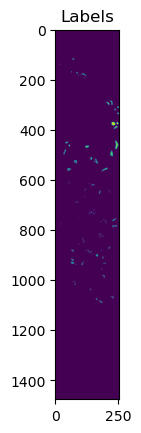

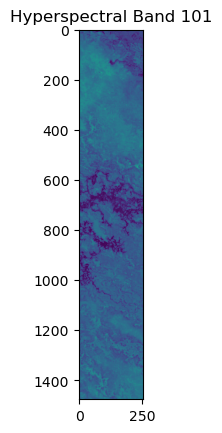

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(560, 5, 5, 145)
(70, 5, 5, 145)
(2618, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2226, PSNR: -9.4525


Epoch [1/50] Training Loss: 0.2126, PSNR: -8.6269
	[Val]   Batch [1/11] Loss: 0.2031, PSNR: -6.1144
	[Val]   Batch [10/11] Loss: 0.2032, PSNR: -8.3531
Epoch [1/50] Validation Loss: 0.2031, PSNR: -8.0453

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1980, PSNR: -10.4548


Epoch [2/50] Training Loss: 0.1906, PSNR: -8.3630
	[Val]   Batch [1/11] Loss: 0.1795, PSNR: -5.5777
	[Val]   Batch [10/11] Loss: 0.1798, PSNR: -7.8210
Epoch [2/50] Validation Loss: 0.1794, PSNR: -7.5075

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1773, PSNR: -9.1104


Epoch [3/50] Training Loss: 0.1699, PSNR: -7.8610
	[Val]   Batch [1/11] Loss: 0.1556, PSNR: -4.9567
	[Val]   Batch [10/11] Loss: 0.1559, PSNR: -7.2002
Epoch [3/50] Validation Loss: 0.1555, PSNR: -6.8863

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1567, PSNR: -7.3796


Epoch [4/50] Training Loss: 0.1500, PSNR: -7.2742
	[Val]   Batch [1/11] Loss: 0.1363, PSNR: -4.3805
	[Val]   Batch [10/11] Loss: 0.1364, PSNR: -6.6204
Epoch [4/50] Validation Loss: 0.1362, PSNR: -6.3086

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1369, PSNR: -7.2525


Epoch [5/50] Training Loss: 0.1312, PSNR: -6.7496
	[Val]   Batch [1/11] Loss: 0.1176, PSNR: -3.7413
	[Val]   Batch [10/11] Loss: 0.1177, PSNR: -5.9802
Epoch [5/50] Validation Loss: 0.1175, PSNR: -5.6683

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1199, PSNR: -8.1576


Epoch [6/50] Training Loss: 0.1136, PSNR: -6.2489
	[Val]   Batch [1/11] Loss: 0.1011, PSNR: -3.0838
	[Val]   Batch [10/11] Loss: 0.1012, PSNR: -5.3232
Epoch [6/50] Validation Loss: 0.1010, PSNR: -5.0123

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1040, PSNR: -5.1436


Epoch [7/50] Training Loss: 0.0980, PSNR: -5.3965
	[Val]   Batch [1/11] Loss: 0.0866, PSNR: -2.4123
	[Val]   Batch [10/11] Loss: 0.0867, PSNR: -4.6533
Epoch [7/50] Validation Loss: 0.0866, PSNR: -4.3414

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0887, PSNR: -5.4572


Epoch [8/50] Training Loss: 0.0843, PSNR: -4.8443
	[Val]   Batch [1/11] Loss: 0.0746, PSNR: -1.7619
	[Val]   Batch [10/11] Loss: 0.0746, PSNR: -4.0021
Epoch [8/50] Validation Loss: 0.0745, PSNR: -3.6914

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0768, PSNR: -3.8241


Epoch [9/50] Training Loss: 0.0726, PSNR: -3.9174
	[Val]   Batch [1/11] Loss: 0.0649, PSNR: -1.1571
	[Val]   Batch [10/11] Loss: 0.0649, PSNR: -3.3956
Epoch [9/50] Validation Loss: 0.0648, PSNR: -3.0868

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0652, PSNR: -2.4992


Epoch [10/50] Training Loss: 0.0628, PSNR: -3.4743
	[Val]   Batch [1/11] Loss: 0.0571, PSNR: -0.6031
	[Val]   Batch [10/11] Loss: 0.0571, PSNR: -2.8400
Epoch [10/50] Validation Loss: 0.0571, PSNR: -2.5323

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0570, PSNR: -2.1795


Epoch [11/50] Training Loss: 0.0547, PSNR: -2.7820
	[Val]   Batch [1/11] Loss: 0.0500, PSNR: -0.0285
	[Val]   Batch [10/11] Loss: 0.0500, PSNR: -2.2656
Epoch [11/50] Validation Loss: 0.0500, PSNR: -1.9572

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0503, PSNR: -1.6395


Epoch [12/50] Training Loss: 0.0479, PSNR: -2.2483
	[Val]   Batch [1/11] Loss: 0.0445, PSNR: 0.4836
	[Val]   Batch [10/11] Loss: 0.0445, PSNR: -1.7541
Epoch [12/50] Validation Loss: 0.0444, PSNR: -1.4457

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0438, PSNR: -1.3854


Epoch [13/50] Training Loss: 0.0423, PSNR: -1.8045
	[Val]   Batch [1/11] Loss: 0.0396, PSNR: 0.9857
	[Val]   Batch [10/11] Loss: 0.0396, PSNR: -1.2523
Epoch [13/50] Validation Loss: 0.0396, PSNR: -0.9435

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0396, PSNR: -1.4337


Epoch [14/50] Training Loss: 0.0375, PSNR: -1.2533
	[Val]   Batch [1/11] Loss: 0.0356, PSNR: 1.4527
	[Val]   Batch [10/11] Loss: 0.0356, PSNR: -0.7852
Epoch [14/50] Validation Loss: 0.0356, PSNR: -0.4768

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0346, PSNR: -2.8814


Epoch [15/50] Training Loss: 0.0335, PSNR: -0.8050
	[Val]   Batch [1/11] Loss: 0.0320, PSNR: 1.9142
	[Val]   Batch [10/11] Loss: 0.0320, PSNR: -0.3229
Epoch [15/50] Validation Loss: 0.0320, PSNR: -0.0148

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0310, PSNR: -2.2793


Epoch [16/50] Training Loss: 0.0302, PSNR: -0.3099
	[Val]   Batch [1/11] Loss: 0.0290, PSNR: 2.3417
	[Val]   Batch [10/11] Loss: 0.0290, PSNR: 0.1040
Epoch [16/50] Validation Loss: 0.0290, PSNR: 0.4132

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0277, PSNR: 0.5978


Epoch [17/50] Training Loss: 0.0273, PSNR: 0.2245
	[Val]   Batch [1/11] Loss: 0.0264, PSNR: 2.7473
	[Val]   Batch [10/11] Loss: 0.0264, PSNR: 0.5104
Epoch [17/50] Validation Loss: 0.0264, PSNR: 0.8195

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0263, PSNR: -1.1755


Epoch [18/50] Training Loss: 0.0248, PSNR: 0.4846
	[Val]   Batch [1/11] Loss: 0.0239, PSNR: 3.1714
	[Val]   Batch [10/11] Loss: 0.0239, PSNR: 0.9341
Epoch [18/50] Validation Loss: 0.0239, PSNR: 1.2427

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0237, PSNR: 3.2102


Epoch [19/50] Training Loss: 0.0227, PSNR: 0.9720
	[Val]   Batch [1/11] Loss: 0.0223, PSNR: 3.4862
	[Val]   Batch [10/11] Loss: 0.0223, PSNR: 1.2502
Epoch [19/50] Validation Loss: 0.0223, PSNR: 1.5574

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0217, PSNR: 1.6595


Epoch [20/50] Training Loss: 0.0208, PSNR: 1.3916
	[Val]   Batch [1/11] Loss: 0.0203, PSNR: 3.8876
	[Val]   Batch [10/11] Loss: 0.0203, PSNR: 1.6511
Epoch [20/50] Validation Loss: 0.0203, PSNR: 1.9593

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0194, PSNR: 1.1443


Epoch [21/50] Training Loss: 0.0191, PSNR: 1.6398
	[Val]   Batch [1/11] Loss: 0.0188, PSNR: 4.2160
	[Val]   Batch [10/11] Loss: 0.0188, PSNR: 1.9799
Epoch [21/50] Validation Loss: 0.0188, PSNR: 2.2881

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0183, PSNR: 4.3443


Epoch [22/50] Training Loss: 0.0177, PSNR: 1.9960
	[Val]   Batch [1/11] Loss: 0.0174, PSNR: 4.5593
	[Val]   Batch [10/11] Loss: 0.0174, PSNR: 2.3247
Epoch [22/50] Validation Loss: 0.0174, PSNR: 2.6317

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0164, PSNR: 4.8165


Epoch [23/50] Training Loss: 0.0164, PSNR: 2.5775
	[Val]   Batch [1/11] Loss: 0.0164, PSNR: 4.8102
	[Val]   Batch [10/11] Loss: 0.0164, PSNR: 2.5768
Epoch [23/50] Validation Loss: 0.0164, PSNR: 2.8844

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0161, PSNR: 0.5766


Epoch [24/50] Training Loss: 0.0153, PSNR: 2.7162
	[Val]   Batch [1/11] Loss: 0.0152, PSNR: 5.1392
	[Val]   Batch [10/11] Loss: 0.0152, PSNR: 2.9066
Epoch [24/50] Validation Loss: 0.0152, PSNR: 3.2140

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0144, PSNR: 4.0658


Epoch [25/50] Training Loss: 0.0142, PSNR: 3.0496
	[Val]   Batch [1/11] Loss: 0.0141, PSNR: 5.4741
	[Val]   Batch [10/11] Loss: 0.0141, PSNR: 3.2392
Epoch [25/50] Validation Loss: 0.0141, PSNR: 3.5486

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0134, PSNR: 2.3789


Epoch [26/50] Training Loss: 0.0133, PSNR: 3.2244
	[Val]   Batch [1/11] Loss: 0.0133, PSNR: 5.7098
	[Val]   Batch [10/11] Loss: 0.0133, PSNR: 3.4750
Epoch [26/50] Validation Loss: 0.0133, PSNR: 3.7841

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0127, PSNR: 5.9328


Epoch [27/50] Training Loss: 0.0124, PSNR: 3.4023
	[Val]   Batch [1/11] Loss: 0.0125, PSNR: 6.0056
	[Val]   Batch [10/11] Loss: 0.0125, PSNR: 3.7713
Epoch [27/50] Validation Loss: 0.0125, PSNR: 4.0797

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0119, PSNR: 6.1933


Epoch [28/50] Training Loss: 0.0117, PSNR: 3.9357
	[Val]   Batch [1/11] Loss: 0.0116, PSNR: 6.3061
	[Val]   Batch [10/11] Loss: 0.0116, PSNR: 4.0725
Epoch [28/50] Validation Loss: 0.0116, PSNR: 4.3800

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0111, PSNR: 3.0851


Epoch [29/50] Training Loss: 0.0110, PSNR: 4.2352
	[Val]   Batch [1/11] Loss: 0.0110, PSNR: 6.5349
	[Val]   Batch [10/11] Loss: 0.0110, PSNR: 4.3020
Epoch [29/50] Validation Loss: 0.0110, PSNR: 4.6092

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0104, PSNR: 3.8545


Epoch [30/50] Training Loss: 0.0103, PSNR: 4.2980
	[Val]   Batch [1/11] Loss: 0.0104, PSNR: 6.7930
	[Val]   Batch [10/11] Loss: 0.0104, PSNR: 4.5600
Epoch [30/50] Validation Loss: 0.0104, PSNR: 4.8674

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 4.1182


Epoch [31/50] Training Loss: 0.0098, PSNR: 4.4619
	[Val]   Batch [1/11] Loss: 0.0098, PSNR: 7.0687
	[Val]   Batch [10/11] Loss: 0.0098, PSNR: 4.8354
Epoch [31/50] Validation Loss: 0.0097, PSNR: 5.1430

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0094, PSNR: 4.4077


Epoch [32/50] Training Loss: 0.0092, PSNR: 4.9126
	[Val]   Batch [1/11] Loss: 0.0092, PSNR: 7.3157
	[Val]   Batch [10/11] Loss: 0.0092, PSNR: 5.0827
Epoch [32/50] Validation Loss: 0.0092, PSNR: 5.3899

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0089, PSNR: 3.2589


Epoch [33/50] Training Loss: 0.0087, PSNR: 4.8659
	[Val]   Batch [1/11] Loss: 0.0088, PSNR: 7.5312
	[Val]   Batch [10/11] Loss: 0.0088, PSNR: 5.2978
Epoch [33/50] Validation Loss: 0.0088, PSNR: 5.6058

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0084, PSNR: 4.7619


Epoch [34/50] Training Loss: 0.0083, PSNR: 5.3769
	[Val]   Batch [1/11] Loss: 0.0083, PSNR: 7.7951
	[Val]   Batch [10/11] Loss: 0.0083, PSNR: 5.5615
Epoch [34/50] Validation Loss: 0.0082, PSNR: 5.8699

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0077, PSNR: 6.7630


Epoch [35/50] Training Loss: 0.0078, PSNR: 5.5233
	[Val]   Batch [1/11] Loss: 0.0079, PSNR: 7.9790
	[Val]   Batch [10/11] Loss: 0.0079, PSNR: 5.7459
Epoch [35/50] Validation Loss: 0.0079, PSNR: 6.0542

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0077, PSNR: 6.7712


Epoch [36/50] Training Loss: 0.0075, PSNR: 5.7245
	[Val]   Batch [1/11] Loss: 0.0075, PSNR: 8.2107
	[Val]   Batch [10/11] Loss: 0.0075, PSNR: 5.9787
Epoch [36/50] Validation Loss: 0.0075, PSNR: 6.2862

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 5.9321


Epoch [37/50] Training Loss: 0.0071, PSNR: 6.0632
	[Val]   Batch [1/11] Loss: 0.0071, PSNR: 8.4384
	[Val]   Batch [10/11] Loss: 0.0071, PSNR: 6.2062
Epoch [37/50] Validation Loss: 0.0071, PSNR: 6.5143

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 6.6929


Epoch [38/50] Training Loss: 0.0068, PSNR: 6.3026
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6354
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.4022
Epoch [38/50] Validation Loss: 0.0068, PSNR: 6.7112

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0069, PSNR: 4.0100


Epoch [39/50] Training Loss: 0.0064, PSNR: 6.3657
	[Val]   Batch [1/11] Loss: 0.0065, PSNR: 8.8210
	[Val]   Batch [10/11] Loss: 0.0065, PSNR: 6.5884
Epoch [39/50] Validation Loss: 0.0065, PSNR: 6.8969

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0064, PSNR: 6.9826


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.6842
	[Val]   Batch [1/11] Loss: 0.0062, PSNR: 9.0168
	[Val]   Batch [10/11] Loss: 0.0062, PSNR: 6.7835
Epoch [40/50] Validation Loss: 0.0062, PSNR: 7.0927

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 7.0767


Epoch [41/50] Training Loss: 0.0059, PSNR: 6.4614
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2187
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 6.9858
Epoch [41/50] Validation Loss: 0.0059, PSNR: 7.2950

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0059, PSNR: 9.2620


Epoch [42/50] Training Loss: 0.0056, PSNR: 6.7135
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4344
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.2012
Epoch [42/50] Validation Loss: 0.0057, PSNR: 7.5108

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0055, PSNR: 6.6422


Epoch [43/50] Training Loss: 0.0054, PSNR: 7.1586
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5965
	[Val]   Batch [10/11] Loss: 0.0054, PSNR: 7.3632
Epoch [43/50] Validation Loss: 0.0054, PSNR: 7.6730

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 7.7956


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.3690
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7898
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5578
Epoch [44/50] Validation Loss: 0.0052, PSNR: 7.8662

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 7.6276


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.5809
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9705
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7389
Epoch [45/50] Validation Loss: 0.0050, PSNR: 8.0472

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 7.2140


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.6201
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1620
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.9311
Epoch [46/50] Validation Loss: 0.0048, PSNR: 8.2390

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 7.3524


Epoch [47/50] Training Loss: 0.0045, PSNR: 8.0459
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3384
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.1076
Epoch [47/50] Validation Loss: 0.0046, PSNR: 8.4153

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.6399


Epoch [48/50] Training Loss: 0.0044, PSNR: 7.9589
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5081
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2769
Epoch [48/50] Validation Loss: 0.0044, PSNR: 8.5852

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 7.2552


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.1936
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6675
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4363
Epoch [49/50] Validation Loss: 0.0043, PSNR: 8.7447

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 9.6078


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.3895
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8458
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.6149
Epoch [50/50] Validation Loss: 0.0041, PSNR: 8.9233


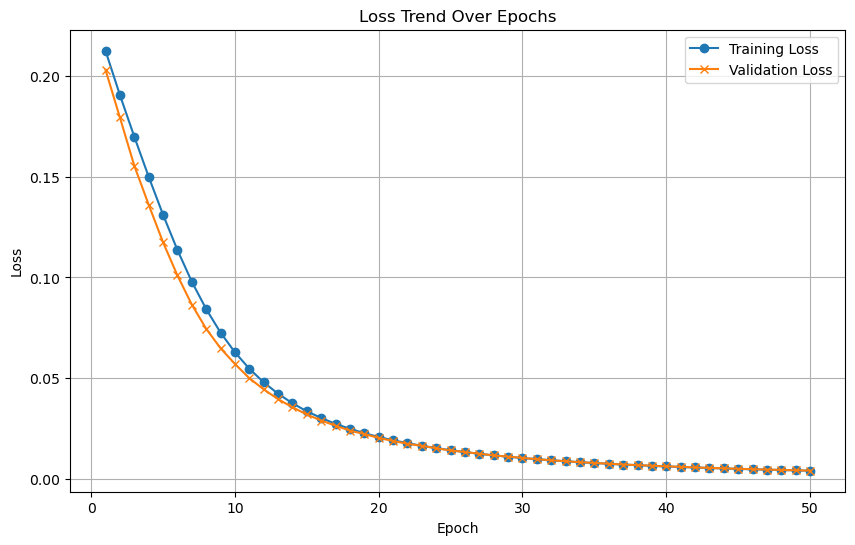

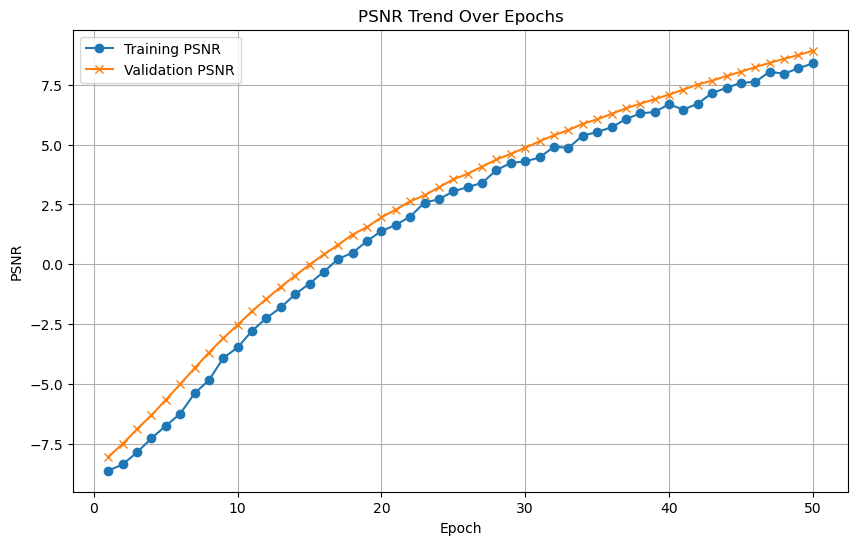

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/11 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6157
    Validation Batch [1/1], Loss: 2.6438
Validation Loss: 2.6438, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6438. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5602
    Validation Batch [1/1], Loss: 2.6437
Validation Loss: 2.6437, Validation Accuracy: 7.14%
Validation loss improved from 2.6438 to 2.6437. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5043
    Validation Batch [1/1], Loss: 2.6437
Validation Loss: 2.6437, Validation Accuracy: 7.14%
Validation loss improved from 2.6437 to 2.6437. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.4775
    Validation Batch [1/1], Loss: 2.6437
Validation Loss: 2.6437, Validation Accuracy: 7.14%
Validation loss improved from 2.6437 to 2.6437. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

Epoch [9/1000] completed, Average Training Loss: 2.3506
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss improved from 2.6434 to 2.6432. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.3213
    Validation Batch [1/1], Loss: 2.6430
Validation Loss: 2.6430, Validation Accuracy: 7.14%
Validation loss improved from 2.6432 to 2.6430. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.2983
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6430 to 2.6428. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.2781
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6428. Saving model...

LOG: Epoch [13/1000] - Training


Epoch [13/1000] completed, Average Training Loss: 2.2755
    Validation Batch [1/1], Loss: 2.6425
Validation Loss: 2.6425, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6425. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.2385
    Validation Batch [1/1], Loss: 2.6421
Validation Loss: 2.6421, Validation Accuracy: 7.14%
Validation loss improved from 2.6425 to 2.6421. Saving model...

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 2.2278
    Validation Batch [1/1], Loss: 2.6416
Validation Loss: 2.6416, Validation Accuracy: 7.14%
Validation loss improved from 2.6421 to 2.6416. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.2119
    Validation Batch [1/1], Loss: 2.6404
Validation Loss: 2.6404, Validation Accuracy: 7.14%
Validation loss improved from 2.6416 to 2.6404. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/10

Epoch [22/1000] completed, Average Training Loss: 2.0982
    Validation Batch [1/1], Loss: 2.6283
Validation Loss: 2.6283, Validation Accuracy: 12.86%
Validation loss improved from 2.6314 to 2.6283. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.0805
    Validation Batch [1/1], Loss: 2.6236
Validation Loss: 2.6236, Validation Accuracy: 17.14%
Validation loss improved from 2.6283 to 2.6236. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.0571
    Validation Batch [1/1], Loss: 2.6178
Validation Loss: 2.6178, Validation Accuracy: 21.43%
Validation loss improved from 2.6236 to 2.6178. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.0445
    Validation Batch [1/1], Loss: 2.6110
Validation Loss: 2.6110, Validation Accuracy: 21.43%
Validation loss improved from 2.6178 to 2.6110. Saving model...

LOG: Epoch [26/1000] - Training


Epoch [26/1000] completed, Average Training Loss: 2.0160
    Validation Batch [1/1], Loss: 2.6030
Validation Loss: 2.6030, Validation Accuracy: 21.43%
Validation loss improved from 2.6110 to 2.6030. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.0048
    Validation Batch [1/1], Loss: 2.5932
Validation Loss: 2.5932, Validation Accuracy: 21.43%
Validation loss improved from 2.6030 to 2.5932. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 1.9921
    Validation Batch [1/1], Loss: 2.5823
Validation Loss: 2.5823, Validation Accuracy: 21.43%
Validation loss improved from 2.5932 to 2.5823. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 1.9589
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 21.43%
Validation loss improved from 2.5823 to 2.5701. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [3

Epoch [35/1000] completed, Average Training Loss: 1.8555
    Validation Batch [1/1], Loss: 2.3821
Validation Loss: 2.3821, Validation Accuracy: 50.00%
Validation loss improved from 2.4267 to 2.3821. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.8454
    Validation Batch [1/1], Loss: 2.3239
Validation Loss: 2.3239, Validation Accuracy: 52.86%
Validation loss improved from 2.3821 to 2.3239. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.8202
    Validation Batch [1/1], Loss: 2.2630
Validation Loss: 2.2630, Validation Accuracy: 55.71%
Validation loss improved from 2.3239 to 2.2630. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.8226
    Validation Batch [1/1], Loss: 2.1954
Validation Loss: 2.1954, Validation Accuracy: 57.14%
Validation loss improved from 2.2630 to 2.1954. Saving model...

LOG: Epoch [39/1000] - Training


Epoch [39/1000] completed, Average Training Loss: 1.7981
    Validation Batch [1/1], Loss: 2.1438
Validation Loss: 2.1438, Validation Accuracy: 57.14%
Validation loss improved from 2.1954 to 2.1438. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.7892
    Validation Batch [1/1], Loss: 2.0890
Validation Loss: 2.0890, Validation Accuracy: 55.71%
Validation loss improved from 2.1438 to 2.0890. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.7654
    Validation Batch [1/1], Loss: 2.0263
Validation Loss: 2.0263, Validation Accuracy: 62.86%
Validation loss improved from 2.0890 to 2.0263. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.7453
    Validation Batch [1/1], Loss: 1.9596
Validation Loss: 1.9596, Validation Accuracy: 62.86%
Validation loss improved from 2.0263 to 1.9596. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

Epoch [48/1000] completed, Average Training Loss: 1.6442
    Validation Batch [1/1], Loss: 1.7289
Validation Loss: 1.7289, Validation Accuracy: 74.29%
Validation loss improved from 1.7538 to 1.7289. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.6093
    Validation Batch [1/1], Loss: 1.6774
Validation Loss: 1.6774, Validation Accuracy: 78.57%
Validation loss improved from 1.7289 to 1.6774. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.5898
    Validation Batch [1/1], Loss: 1.6726
Validation Loss: 1.6726, Validation Accuracy: 74.29%
Validation loss improved from 1.6774 to 1.6726. Saving model...

LOG: Epoch [51/1000] - Training


Epoch [51/1000] completed, Average Training Loss: 1.5861
    Validation Batch [1/1], Loss: 1.6201
Validation Loss: 1.6201, Validation Accuracy: 80.00%
Validation loss improved from 1.6726 to 1.6201. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.5739
    Validation Batch [1/1], Loss: 1.6019
Validation Loss: 1.6019, Validation Accuracy: 78.57%
Validation loss improved from 1.6201 to 1.6019. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.5445
    Validation Batch [1/1], Loss: 1.5619
Validation Loss: 1.5619, Validation Accuracy: 81.43%
Validation loss improved from 1.6019 to 1.5619. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.5282
    Validation Batch [1/1], Loss: 1.5616
Validation Loss: 1.5616, Validation Accuracy: 81.43%
Validation loss improved from 1.5619 to 1.5616. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

Epoch [61/1000] completed, Average Training Loss: 1.4073


    Validation Batch [1/1], Loss: 1.3659
Validation Loss: 1.3659, Validation Accuracy: 80.00%
Validation loss improved from 1.3818 to 1.3659. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.3766
    Validation Batch [1/1], Loss: 1.3596
Validation Loss: 1.3596, Validation Accuracy: 80.00%
Validation loss improved from 1.3659 to 1.3596. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.3682
    Validation Batch [1/1], Loss: 1.3473
Validation Loss: 1.3473, Validation Accuracy: 82.86%
Validation loss improved from 1.3596 to 1.3473. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.3417
    Validation Batch [1/1], Loss: 1.3201
Validation Loss: 1.3201, Validation Accuracy: 84.29%
Validation loss improved from 1.3473 to 1.3201. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.3336
    Vali

    Validation Batch [1/1], Loss: 1.1803
Validation Loss: 1.1803, Validation Accuracy: 82.86%
Validation loss improved from 1.1872 to 1.1803. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.1916
    Validation Batch [1/1], Loss: 1.1434
Validation Loss: 1.1434, Validation Accuracy: 87.14%
Validation loss improved from 1.1803 to 1.1434. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.1679
    Validation Batch [1/1], Loss: 1.1334
Validation Loss: 1.1334, Validation Accuracy: 85.71%
Validation loss improved from 1.1434 to 1.1334. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.1459
    Validation Batch [1/1], Loss: 1.1188
Validation Loss: 1.1188, Validation Accuracy: 85.71%
Validation loss improved from 1.1334 to 1.1188. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.1428
    Vali

Epoch [85/1000] completed, Average Training Loss: 1.0213
    Validation Batch [1/1], Loss: 1.0148
Validation Loss: 1.0148, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 0.9936
    Validation Batch [1/1], Loss: 0.9651
Validation Loss: 0.9651, Validation Accuracy: 88.57%
Validation loss improved from 0.9903 to 0.9651. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.0035
    Validation Batch [1/1], Loss: 0.9629
Validation Loss: 0.9629, Validation Accuracy: 84.29%
Validation loss improved from 0.9651 to 0.9629. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 0.9821
    Validation Batch [1/1], Loss: 0.9311
Validation Loss: 0.9311, Validation Accuracy: 88.57%
Validation loss improved from 0.9629 to 0.9311. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] complet

Epoch [97/1000] completed, Average Training Loss: 0.8489
    Validation Batch [1/1], Loss: 0.8193
Validation Loss: 0.8193, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 0.8244
    Validation Batch [1/1], Loss: 0.7877
Validation Loss: 0.7877, Validation Accuracy: 92.86%
Validation loss improved from 0.8146 to 0.7877. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 0.8277
    Validation Batch [1/1], Loss: 0.8270
Validation Loss: 0.8270, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 0.8125
    Validation Batch [1/1], Loss: 0.7632
Validation Loss: 0.7632, Validation Accuracy: 94.29%
Validation loss improved from 0.7877 to 0.7632. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average

Epoch [109/1000] completed, Average Training Loss: 0.6902
    Validation Batch [1/1], Loss: 0.6981
Validation Loss: 0.6981, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.7082
    Validation Batch [1/1], Loss: 0.6455
Validation Loss: 0.6455, Validation Accuracy: 97.14%
Validation loss improved from 0.6952 to 0.6455. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.6622
    Validation Batch [1/1], Loss: 0.6380
Validation Loss: 0.6380, Validation Accuracy: 95.71%
Validation loss improved from 0.6455 to 0.6380. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.6564
    Validation Batch [1/1], Loss: 0.6979
Validation Loss: 0.6979, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Av

Epoch [122/1000] completed, Average Training Loss: 0.5364
    Validation Batch [1/1], Loss: 0.5121
Validation Loss: 0.5121, Validation Accuracy: 98.57%
Validation loss improved from 0.5224 to 0.5121. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.5487
    Validation Batch [1/1], Loss: 0.4987
Validation Loss: 0.4987, Validation Accuracy: 98.57%
Validation loss improved from 0.5121 to 0.4987. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.5294
    Validation Batch [1/1], Loss: 0.5120
Validation Loss: 0.5120, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.5101
    Validation Batch [1/1], Loss: 0.4914
Validation Loss: 0.4914, Validation Accuracy: 98.57%
Validation loss improved from 0.4987 to 0.4914. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000

Epoch [135/1000] completed, Average Training Loss: 0.4329
    Validation Batch [1/1], Loss: 0.4501
Validation Loss: 0.4501, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.4134
    Validation Batch [1/1], Loss: 0.3683
Validation Loss: 0.3683, Validation Accuracy: 98.57%
Validation loss improved from 0.4162 to 0.3683. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.4070
    Validation Batch [1/1], Loss: 0.3760
Validation Loss: 0.3760, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.4005
    Validation Batch [1/1], Loss: 0.3743
Validation Loss: 0.3743, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training 

Epoch [147/1000] completed, Average Training Loss: 0.3408
    Validation Batch [1/1], Loss: 0.3626
Validation Loss: 0.3626, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.3097
    Validation Batch [1/1], Loss: 0.3824
Validation Loss: 0.3824, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.3274
    Validation Batch [1/1], Loss: 0.2935
Validation Loss: 0.2935, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.3069
    Validation Batch [1/1], Loss: 0.2884
Validation Loss: 0.2884, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.3084
  

    Validation Batch [1/1], Loss: 0.2289
Validation Loss: 0.2289, Validation Accuracy: 98.57%
Validation loss improved from 0.2425 to 0.2289. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.2568
    Validation Batch [1/1], Loss: 0.2450
Validation Loss: 0.2450, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.2526
    Validation Batch [1/1], Loss: 0.2271
Validation Loss: 0.2271, Validation Accuracy: 98.57%
Validation loss improved from 0.2289 to 0.2271. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.2597
    Validation Batch [1/1], Loss: 0.2167
Validation Loss: 0.2167, Validation Accuracy: 98.57%
Validation loss improved from 0.2271 to 0.2167. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.2503
    Validation 

    Validation Batch [1/1], Loss: 0.2152
Validation Loss: 0.2152, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.2017
    Validation Batch [1/1], Loss: 0.1838
Validation Loss: 0.1838, Validation Accuracy: 98.57%
Validation loss improved from 0.1991 to 0.1838. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.2020
    Validation Batch [1/1], Loss: 0.1832
Validation Loss: 0.1832, Validation Accuracy: 98.57%
Validation loss improved from 0.1838 to 0.1832. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.2046
    Validation Batch [1/1], Loss: 0.1881
Validation Loss: 0.1881, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.1966
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.1388
Validation Loss: 0.1388, Validation Accuracy: 98.57%
Validation loss improved from 0.1442 to 0.1388. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.1661
    Validation Batch [1/1], Loss: 0.1449
Validation Loss: 0.1449, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.1711
    Validation Batch [1/1], Loss: 0.1452
Validation Loss: 0.1452, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.1700
    Validation Batch [1/1], Loss: 0.1507
Validation Loss: 0.1507, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.1714
    Validation Batch [1/1], Loss: 0.1331
Vali

Epoch [198/1000] completed, Average Training Loss: 0.1472
    Validation Batch [1/1], Loss: 0.1144
Validation Loss: 0.1144, Validation Accuracy: 98.57%
Validation loss improved from 0.1258 to 0.1144. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.1333
    Validation Batch [1/1], Loss: 0.1193
Validation Loss: 0.1193, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.1340
    Validation Batch [1/1], Loss: 0.1124
Validation Loss: 0.1124, Validation Accuracy: 98.57%
Validation loss improved from 0.1144 to 0.1124. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.1374
    Validation Batch [1/1], Loss: 0.1119
Validation Loss: 0.1119, Validation Accuracy: 98.57%
Validation loss improved from 0.1124 to 0.1119. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000

    Validation Batch [1/1], Loss: 0.1030
Validation Loss: 0.1030, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.1136
    Validation Batch [1/1], Loss: 0.1064
Validation Loss: 0.1064, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.1108
    Validation Batch [1/1], Loss: 0.1154
Validation Loss: 0.1154, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.1218
    Validation Batch [1/1], Loss: 0.1162
Validation Loss: 0.1162, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.1234
    Validation Batch [1/1], Loss: 0.1132
Validation Loss: 0.

Validation Loss: 0.1106, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 0.0969
Validation Loss: 0.0969, Validation Accuracy: 98.57%
Validation loss improved from 0.1014 to 0.0969. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.1058
    Validation Batch [1/1], Loss: 0.1076
Validation Loss: 0.1076, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.1161
    Validation Batch [1/1], Loss: 0.1097
Validation Loss: 0.1097, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.1038
    Validation Batch [1/1], Loss: 0.1083
Validation Loss: 0.1083, Validation Accuracy

Epoch [230/1000] completed, Average Training Loss: 0.0996
    Validation Batch [1/1], Loss: 0.0878
Validation Loss: 0.0878, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.0937
    Validation Batch [1/1], Loss: 0.1071
Validation Loss: 0.1071, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.0754
Validation Loss: 0.0754, Validation Accuracy: 98.57%
Validation loss improved from 0.0829 to 0.0754. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.0931
    Validation Batch [1/1], Loss: 0.0905
Validation Loss: 0.0905, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training 

Epoch [243/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.0789
Validation Loss: 0.0789, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.0821
    Validation Batch [1/1], Loss: 0.0940
Validation Loss: 0.0940, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.0767
    Validation Batch [1/1], Loss: 0.0918
Validation Loss: 0.0918, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 0.0876
Validation Loss: 0.0876, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.079

Epoch [256/1000] completed, Average Training Loss: 0.0743
    Validation Batch [1/1], Loss: 0.0879
Validation Loss: 0.0879, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.0696
    Validation Batch [1/1], Loss: 0.0706
Validation Loss: 0.0706, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.0692
    Validation Batch [1/1], Loss: 0.0694
Validation Loss: 0.0694, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0751
    Validation Batch [1/1], Loss: 0.0855
Validation Loss: 0.0855, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0741
 

Epoch [269/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.0772
Validation Loss: 0.0772, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0632
    Validation Batch [1/1], Loss: 0.0705
Validation Loss: 0.0705, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0606
    Validation Batch [1/1], Loss: 0.1060
Validation Loss: 0.1060, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.0659
Validation Loss: 0.0659, Validation Accuracy: 98.57%
Validation loss improved from 0.0682 to 0.0659. Saving model...

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Traini

Epoch [282/1000] completed, Average Training Loss: 0.0606
    Validation Batch [1/1], Loss: 0.0669
Validation Loss: 0.0669, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.0587
    Validation Batch [1/1], Loss: 0.0575
Validation Loss: 0.0575, Validation Accuracy: 98.57%
Validation loss improved from 0.0601 to 0.0575. Saving model...

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.0609
Validation Loss: 0.0609, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0708
    Validation Batch [1/1], Loss: 0.0680
Validation Loss: 0.0680, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training 

Epoch [294/1000] completed, Average Training Loss: 0.0607
    Validation Batch [1/1], Loss: 0.0588
Validation Loss: 0.0588, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.0558
Validation Loss: 0.0558, Validation Accuracy: 98.57%
Validation loss improved from 0.0575 to 0.0558. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.0558
Validation Loss: 0.0558, Validation Accuracy: 98.57%
Validation loss improved from 0.0558 to 0.0558. Saving model...

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.0574
    Validation Batch [1/1], Loss: 0.0586
Validation Loss: 0.0586, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, A

Epoch [307/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.0585
Validation Loss: 0.0585, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.0719
Validation Loss: 0.0719, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.0676
Validation Loss: 0.0676, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.0444
    Validation Batch [1/1], Loss: 0.0650
Validation Loss: 0.0650, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.056

Epoch [320/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.0610
Validation Loss: 0.0610, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.0635
Validation Loss: 0.0635, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.0630
Validation Loss: 0.0630, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.0627
Validation Loss: 0.0627, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.0393
  

Epoch [333/1000] completed, Average Training Loss: 0.0381
    Validation Batch [1/1], Loss: 0.0476
Validation Loss: 0.0476, Validation Accuracy: 98.57%
Validation loss improved from 0.0493 to 0.0476. Saving model...

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0599
Validation Loss: 0.0599, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.0581
Validation Loss: 0.0581, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0369
    Validation Batch [1/1], Loss: 0.0587
Validation Loss: 0.0587, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training 

Epoch [345/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.0483
Validation Loss: 0.0483, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.0531
Validation Loss: 0.0531, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.0575
Validation Loss: 0.0575, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.0557
Validation Loss: 0.0557, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.038

Epoch [358/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.0591
Validation Loss: 0.0591, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.0521
Validation Loss: 0.0521, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0311
    Validation Batch [1/1], Loss: 0.0500
Validation Loss: 0.0500, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.0466
Validation Loss: 0.0466, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0336
  

Epoch [372/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.0557
Validation Loss: 0.0557, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.0532
Validation Loss: 0.0532, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.0496
Validation Loss: 0.0496, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0295
    Validation Batch [1/1], Loss: 0.0444
Validation Loss: 0.0444, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.029

Epoch [385/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.0537
Validation Loss: 0.0537, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.0559
Validation Loss: 0.0559, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.0505
Validation Loss: 0.0505, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0308
    Validation Batch [1/1], Loss: 0.0419
Validation Loss: 0.0419, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.026

Epoch [398/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.0553
Validation Loss: 0.0553, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0233
    Validation Batch [1/1], Loss: 0.0540
Validation Loss: 0.0540, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0277
    Validation Batch [1/1], Loss: 0.0879
Validation Loss: 0.0879, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.0504
Validation Loss: 0.0504, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.029

Epoch [411/1000] completed, Average Training Loss: 0.0292
    Validation Batch [1/1], Loss: 0.0542
Validation Loss: 0.0542, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.0475
Validation Loss: 0.0475, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.0488
Validation Loss: 0.0488, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.0475
Validation Loss: 0.0475, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.023

Epoch [424/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.0544
Validation Loss: 0.0544, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0260
    Validation Batch [1/1], Loss: 0.0785
Validation Loss: 0.0785, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0214
    Validation Batch [1/1], Loss: 0.2355
Validation Loss: 0.2355, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0204
    Validation Batch [1/1], Loss: 0.0717
Validation Loss: 0.0717, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0265
  

Epoch [437/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0589
Validation Loss: 0.0589, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.0878
Validation Loss: 0.0878, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.0672
Validation Loss: 0.0672, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0253
    Validation Batch [1/1], Loss: 0.0438
Validation Loss: 0.0438, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.027

Epoch [450/1000] completed, Average Training Loss: 0.0226
    Validation Batch [1/1], Loss: 0.0502
Validation Loss: 0.0502, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.0482
Validation Loss: 0.0482, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0227
    Validation Batch [1/1], Loss: 0.0442
Validation Loss: 0.0442, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0423
Validation Loss: 0.0423, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.019

    Validation Batch [1/1], Loss: 0.0585
Validation Loss: 0.0585, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.0526
Validation Loss: 0.0526, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.0484
Validation Loss: 0.0484, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.0446
Validation Loss: 0.0446, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.0436
Validation Loss

Epoch [476/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.1121
Validation Loss: 0.1121, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.1198
Validation Loss: 0.1198, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.0731
Validation Loss: 0.0731, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.0552
Validation Loss: 0.0552, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.018

Epoch [489/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.0591
Validation Loss: 0.0591, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.0604
Validation Loss: 0.0604, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.0558
Validation Loss: 0.0558, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.0512
Validation Loss: 0.0512, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.016

Epoch [502/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0422
Validation Loss: 0.0422, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.0453
Validation Loss: 0.0453, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0527
Validation Loss: 0.0527, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.0521
Validation Loss: 0.0521, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0157
  

Epoch [515/1000] completed, Average Training Loss: 0.0137
    Validation Batch [1/1], Loss: 0.0529
Validation Loss: 0.0529, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0145
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.0451
Validation Loss: 0.0451, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0398
Validation Loss: 0.0398, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.015

Epoch [528/1000] completed, Average Training Loss: 0.0126
    Validation Batch [1/1], Loss: 0.0460
Validation Loss: 0.0460, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.0418
Validation Loss: 0.0418, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0146
    Validation Batch [1/1], Loss: 0.0354
Validation Loss: 0.0354, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.0848
Validation Loss: 0.0848, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.012

Epoch [541/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.1375
Validation Loss: 0.1375, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.0426
Validation Loss: 0.0426, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0126
    Validation Batch [1/1], Loss: 0.0541
Validation Loss: 0.0541, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0137
    Validation Batch [1/1], Loss: 0.1287
Validation Loss: 0.1287, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.015

Epoch [554/1000] completed, Average Training Loss: 0.0104
    Validation Batch [1/1], Loss: 0.0428
Validation Loss: 0.0428, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0460
Validation Loss: 0.0460, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0455
Validation Loss: 0.0455, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0406
Validation Loss: 0.0406, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.011

Epoch [567/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0493
Validation Loss: 0.0493, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0456
Validation Loss: 0.0456, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0114
    Validation Batch [1/1], Loss: 0.0560
Validation Loss: 0.0560, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0126
    Validation Batch [1/1], Loss: 0.0502
Validation Loss: 0.0502, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0134
 

Epoch [580/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.0519
Validation Loss: 0.0519, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0439
Validation Loss: 0.0439, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0121
    Validation Batch [1/1], Loss: 0.0473
Validation Loss: 0.0473, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0115
    Validation Batch [1/1], Loss: 0.0454
Validation Loss: 0.0454, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.012

Epoch [593/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.0483
Validation Loss: 0.0483, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0540
Validation Loss: 0.0540, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.0456
Validation Loss: 0.0456, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0425
Validation Loss: 0.0425, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.011

Epoch [606/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0455
Validation Loss: 0.0455, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0469
Validation Loss: 0.0469, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0450
Validation Loss: 0.0450, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0110
    Validation Batch [1/1], Loss: 0.0375
Validation Loss: 0.0375, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.009

Epoch [619/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0472
Validation Loss: 0.0472, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0468
Validation Loss: 0.0468, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0464
Validation Loss: 0.0464, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0437
Validation Loss: 0.0437, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.011

    Validation Batch [1/1], Loss: 0.0440
Validation Loss: 0.0440, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0382
Validation Loss: 0.0382, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0316
Validation Loss: 0.0316, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0245
Validation Loss: 0.0245, Validation Accuracy: 98.57%
Validation loss improved from 0.0284 to 0.0245. Saving model...

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0221
V

Epoch [644/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0518
Validation Loss: 0.0518, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0086
    Validation Batch [1/1], Loss: 0.0496
Validation Loss: 0.0496, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0079
    Validation Batch [1/1], Loss: 0.0480
Validation Loss: 0.0480, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0469
Validation Loss: 0.0469, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0097

Epoch [657/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0448
Validation Loss: 0.0448, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0473
Validation Loss: 0.0473, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.0089
    Validation Batch [1/1], Loss: 0.0499
Validation Loss: 0.0499, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0474
Validation Loss: 0.0474, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.008

Epoch [670/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0481
Validation Loss: 0.0481, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0488
Validation Loss: 0.0488, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0468
Validation Loss: 0.0468, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0470
Validation Loss: 0.0470, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.008

    Validation Batch [1/1], Loss: 0.0361
Validation Loss: 0.0361, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0083
    Validation Batch [1/1], Loss: 0.0289
Validation Loss: 0.0289, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0242
Validation Loss: 0.0242, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0238
Validation Loss: 0.0238, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0092
    Validation Batch [1/1], Loss: 0.0361
Validation Loss

Epoch [694/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0503
Validation Loss: 0.0503, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0527
Validation Loss: 0.0527, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0478
Validation Loss: 0.0478, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0079
    Validation Batch [1/1], Loss: 0.0435
Validation Loss: 0.0435, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.008

Epoch [707/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0421
Validation Loss: 0.0421, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0.0071
    Validation Batch [1/1], Loss: 0.0405
Validation Loss: 0.0405, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [709/1000] - Training
Epoch [709/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.0394
Validation Loss: 0.0394, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0077
    Validation Batch [1/1], Loss: 0.0396
Validation Loss: 0.0396, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.007

Epoch [720/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0491
Validation Loss: 0.0491, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0584
Validation Loss: 0.0584, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.0461
Validation Loss: 0.0461, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [724/1000] - Training
Epoch [724/1000] completed, Average Training Loss: 0.008

Epoch [733/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0355
Validation Loss: 0.0355, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [734/1000] - Training
Epoch [734/1000] completed, Average Training Loss: 0.0059
    Validation Batch [1/1], Loss: 0.0403
Validation Loss: 0.0403, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [735/1000] - Training
Epoch [735/1000] completed, Average Training Loss: 0.0073
    Validation Batch [1/1], Loss: 0.0441
Validation Loss: 0.0441, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 735. No improvement for 100 epochs.
Loading the best model weights...


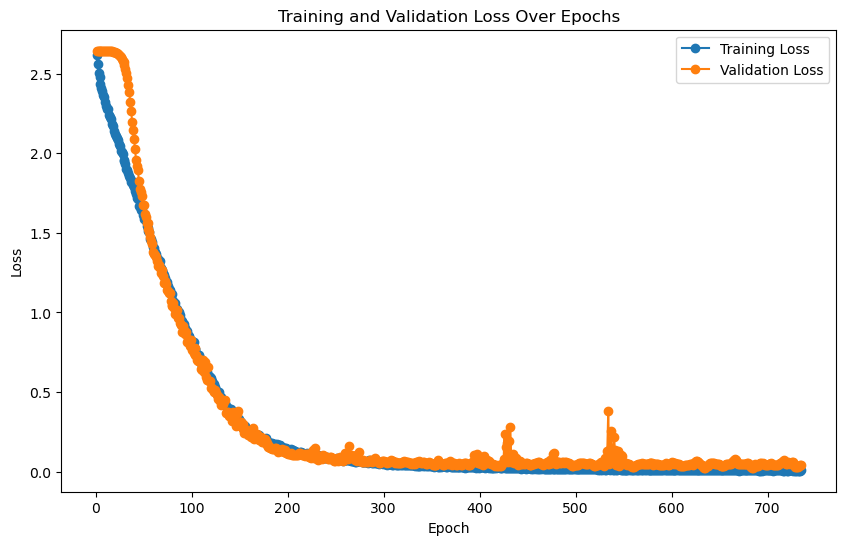

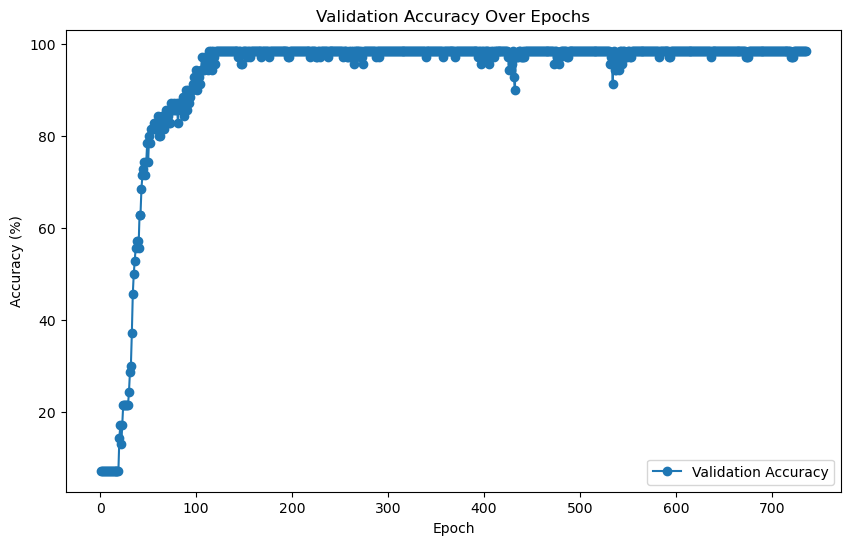


Evaluating on the test set...
    Test Batch [1/11], Loss: 0.0132

Final Test Loss: 0.0341, Test Accuracy: 98.89%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)

LOG: Training features shape: (560, 64), Training labels shape: (560,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2618, 64), Test labels shape: (2618,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       0.83      1.00      0.91         5
           3       0.57      0.80      0.67         5
           4       1.00      0.60      0.75         5
           5       0.67      0.40      0.50         5
           6       0.71      1.00      0.83         5
           7       1.00      0.60      0.75         5
           8       1.00      0.40      0.57         5
           9       0.71      1.00      0.83         5
          10       0.71      1.00      0.83         5
          11       1.00      1.00      1.00         5
          12       1.00      0.60      0.75         5
          13       1.00      1.00      1.00         5

    accuracy                          

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)
Train reps shape: (560, 64)
Train labels shape: (560,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2618, 64)
Test labels shape: (2618,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6317  |  Val Loss: 2.5987
Validation loss improved from inf to 2.5987.
[Epoch 2/1000] Train Loss: 2.5893  |  Val Loss: 2.5668
Validation loss improved from 2.5987 to 2.5668.
[Epoch 3/1000] Train Loss: 2.5574  |  Val Loss: 2.5338
Validation loss improved from 2.5668 to 2.5338.
[Epoch 4/1000] Train Loss: 2.5227  |  Val Loss: 2.4866
Validation loss improved from 2.5338 to 2.4866.
[Epoch 5/1000] Train Loss: 2.4672  |  Val Loss: 2.4356
Validation loss improved from 2.4866 to 2.4356.
[Epoch 6/1000] Train Loss: 2.4085  |  Val Loss: 2.3699
Validation loss improved from 2.4356 to 2.3699.
[Epoch 7/1000] Train Loss: 2.3394  |  Val Loss: 2.2896
Validation loss improved from 2.3699 to 2.2896.


[Epoch 8/1000] Train Loss: 2.2740  |  Val Loss: 2.2155
Validation loss improved from 2.2896 to 2.2155.
[Epoch 9/1000] Train Loss: 2.1832  |  Val Loss: 2.1338
Validation loss improved from 2.2155 to 2.1338.
[Epoch 10/1000] Train Loss: 2.1125  |  Val Loss: 2.0661
Validation loss improved from 2.1338 to 2.0661.


[Epoch 11/1000] Train Loss: 2.0375  |  Val Loss: 1.9963
Validation loss improved from 2.0661 to 1.9963.
[Epoch 12/1000] Train Loss: 1.9669  |  Val Loss: 1.9086
Validation loss improved from 1.9963 to 1.9086.
[Epoch 13/1000] Train Loss: 1.8923  |  Val Loss: 1.8645
Validation loss improved from 1.9086 to 1.8645.
[Epoch 14/1000] Train Loss: 1.8294  |  Val Loss: 1.7771
Validation loss improved from 1.8645 to 1.7771.
[Epoch 15/1000] Train Loss: 1.7708  |  Val Loss: 1.7224
Validation loss improved from 1.7771 to 1.7224.
[Epoch 16/1000] Train Loss: 1.7327  |  Val Loss: 1.6895
Validation loss improved from 1.7224 to 1.6895.
[Epoch 17/1000] Train Loss: 1.6708  |  Val Loss: 1.6257
Validation loss improved from 1.6895 to 1.6257.
[Epoch 18/1000] Train Loss: 1.6169  |  Val Loss: 1.6194
Validation loss improved from 1.6257 to 1.6194.
[Epoch 19/1000] Train Loss: 1.5927  |  Val Loss: 1.5516
Validation loss improved from 1.6194 to 1.5516.


[Epoch 20/1000] Train Loss: 1.5598  |  Val Loss: 1.5299
Validation loss improved from 1.5516 to 1.5299.


[Epoch 21/1000] Train Loss: 1.5392  |  Val Loss: 1.4906
Validation loss improved from 1.5299 to 1.4906.
[Epoch 22/1000] Train Loss: 1.5244  |  Val Loss: 1.4694
Validation loss improved from 1.4906 to 1.4694.
[Epoch 23/1000] Train Loss: 1.4995  |  Val Loss: 1.4817
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 1.4671  |  Val Loss: 1.4147
Validation loss improved from 1.4694 to 1.4147.
[Epoch 25/1000] Train Loss: 1.4307  |  Val Loss: 1.4009
Validation loss improved from 1.4147 to 1.4009.
[Epoch 26/1000] Train Loss: 1.4154  |  Val Loss: 1.4194
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 1.4279  |  Val Loss: 1.3609
Validation loss improved from 1.4009 to 1.3609.
[Epoch 28/1000] Train Loss: 1.3977  |  Val Loss: 1.3488
Validation loss improved from 1.3609 to 1.3488.
[Epoch 29/1000] Train Loss: 1.3659  |  Val Loss: 1.3623
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 30/1000] Train Loss: 1.3548  |  Val Los

[Epoch 31/1000] Train Loss: 1.3393  |  Val Loss: 1.3100
Validation loss improved from 1.3217 to 1.3100.
[Epoch 32/1000] Train Loss: 1.3365  |  Val Loss: 1.3052
Validation loss improved from 1.3100 to 1.3052.
[Epoch 33/1000] Train Loss: 1.3400  |  Val Loss: 1.2921
Validation loss improved from 1.3052 to 1.2921.
[Epoch 34/1000] Train Loss: 1.3142  |  Val Loss: 1.3139
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 1.3047  |  Val Loss: 1.2805
Validation loss improved from 1.2921 to 1.2805.
[Epoch 36/1000] Train Loss: 1.2956  |  Val Loss: 1.2766
Validation loss improved from 1.2805 to 1.2766.
[Epoch 37/1000] Train Loss: 1.2933  |  Val Loss: 1.2978
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 1.3133  |  Val Loss: 1.3273
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 39/1000] Train Loss: 1.2948  |  Val Loss: 1.2586
Validation loss improved from 1.2766 to 1.2586.
[Epoch 40/1000] Train Loss: 1.2652  |  Val Los

[Epoch 42/1000] Train Loss: 1.2581  |  Val Loss: 1.2390
Validation loss improved from 1.2481 to 1.2390.
[Epoch 43/1000] Train Loss: 1.2559  |  Val Loss: 1.2393
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 1.2594  |  Val Loss: 1.2360
Validation loss improved from 1.2390 to 1.2360.
[Epoch 45/1000] Train Loss: 1.2438  |  Val Loss: 1.2204
Validation loss improved from 1.2360 to 1.2204.
[Epoch 46/1000] Train Loss: 1.2280  |  Val Loss: 1.2160
Validation loss improved from 1.2204 to 1.2160.
[Epoch 47/1000] Train Loss: 1.2251  |  Val Loss: 1.2095
Validation loss improved from 1.2160 to 1.2095.
[Epoch 48/1000] Train Loss: 1.2445  |  Val Loss: 1.2459
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 1.2253  |  Val Loss: 1.2115
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 1.2301  |  Val Loss: 1.2228
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 51/1000] Train Loss: 1.2351  |  V

[Epoch 53/1000] Train Loss: 1.2200  |  Val Loss: 1.1985
Validation loss improved from 1.2049 to 1.1985.
[Epoch 54/1000] Train Loss: 1.2063  |  Val Loss: 1.2014
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 1.2064  |  Val Loss: 1.2078
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 1.2037  |  Val Loss: 1.1903
Validation loss improved from 1.1985 to 1.1903.
[Epoch 57/1000] Train Loss: 1.1991  |  Val Loss: 1.2098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 1.2024  |  Val Loss: 1.1843
Validation loss improved from 1.1903 to 1.1843.
[Epoch 59/1000] Train Loss: 1.1946  |  Val Loss: 1.1889
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 1.1985  |  Val Loss: 1.2009
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 1.1937  |  Val Loss: 1.2074
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 

[Epoch 63/1000] Train Loss: 1.1996  |  Val Loss: 1.1903
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.1970  |  Val Loss: 1.1698
Validation loss improved from 1.1776 to 1.1698.
[Epoch 65/1000] Train Loss: 1.1926  |  Val Loss: 1.1870
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 1.1880  |  Val Loss: 1.1900
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 1.1905  |  Val Loss: 1.2016
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 68/1000] Train Loss: 1.1918  |  Val Loss: 1.1679
Validation loss improved from 1.1698 to 1.1679.
[Epoch 69/1000] Train Loss: 1.1892  |  Val Loss: 1.1723
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 1.1806  |  Val Loss: 1.1928
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 1.1789  |  Val Loss: 1.1662
Validation loss improved from 1.1679 to 1.1662.
[Epoch 72/1000] Train Loss: 

[Epoch 74/1000] Train Loss: 1.2728  |  Val Loss: 1.1846
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 1.2194  |  Val Loss: 1.2653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 1.2360  |  Val Loss: 1.2771
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 77/1000] Train Loss: 1.2028  |  Val Loss: 1.1636
Validation loss improved from 1.1662 to 1.1636.
[Epoch 78/1000] Train Loss: 1.2376  |  Val Loss: 1.1493
Validation loss improved from 1.1636 to 1.1493.
[Epoch 79/1000] Train Loss: 1.1918  |  Val Loss: 1.2198
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 80/1000] Train Loss: 1.1928  |  Val Loss: 1.1706
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 81/1000] Train Loss: 1.1862  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 82/1000] Train Loss: 1.2164  |  Val Loss: 1.1767
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 83/1000] Train 

[Epoch 85/1000] Train Loss: 1.1615  |  Val Loss: 1.1641
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 1.1647  |  Val Loss: 1.1587
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 1.1550  |  Val Loss: 1.1312
Validation loss improved from 1.1467 to 1.1312.
[Epoch 88/1000] Train Loss: 1.1521  |  Val Loss: 1.1293
Validation loss improved from 1.1312 to 1.1293.
[Epoch 89/1000] Train Loss: 1.1606  |  Val Loss: 1.1431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 90/1000] Train Loss: 1.1798  |  Val Loss: 1.2300
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91/1000] Train Loss: 1.1759  |  Val Loss: 1.1576
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 1.1512  |  Val Loss: 1.1764
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 93/1000] Train Loss: 1.1741  |  Val Loss: 1.1656
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 94/1000] Train 

[Epoch 96/1000] Train Loss: 1.1307  |  Val Loss: 1.1266
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 1.1432  |  Val Loss: 1.1202
Validation loss improved from 1.1243 to 1.1202.
[Epoch 98/1000] Train Loss: 1.1587  |  Val Loss: 1.1409
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 1.1540  |  Val Loss: 1.1490
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 100/1000] Train Loss: 1.1671  |  Val Loss: 1.1337
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 101/1000] Train Loss: 1.1531  |  Val Loss: 1.1640
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 102/1000] Train Loss: 1.1983  |  Val Loss: 1.1269
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 103/1000] Train Loss: 1.1745  |  Val Loss: 1.1070
Validation loss improved from 1.1202 to 1.1070.
[Epoch 104/1000] Train Loss: 1.1396  |  Val Loss: 1.1729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] 

[Epoch 106/1000] Train Loss: 1.1328  |  Val Loss: 1.1303
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 1.1219  |  Val Loss: 1.1298
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 1.1200  |  Val Loss: 1.1121
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 109/1000] Train Loss: 1.1197  |  Val Loss: 1.1793
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 110/1000] Train Loss: 1.1435  |  Val Loss: 1.1377
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 111/1000] Train Loss: 1.1345  |  Val Loss: 1.1025
Validation loss improved from 1.1070 to 1.1025.
[Epoch 112/1000] Train Loss: 1.1127  |  Val Loss: 1.1141
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 1.1129  |  Val Loss: 1.1148
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 114/1000] Train Loss: 1.1100  |  Val Loss: 1.1045
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 117/1000] Train Loss: 1.1169  |  Val Loss: 1.1247
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 118/1000] Train Loss: 1.1114  |  Val Loss: 1.1041
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 119/1000] Train Loss: 1.1143  |  Val Loss: 1.1163
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 120/1000] Train Loss: 1.1269  |  Val Loss: 1.1112
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 121/1000] Train Loss: 1.1315  |  Val Loss: 1.1049
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 122/1000] Train Loss: 1.1078  |  Val Loss: 1.1051
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 123/1000] Train Loss: 1.1086  |  Val Loss: 1.1030
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 124/1000] Train Loss: 1.1243  |  Val Loss: 1.0918
Validation loss improved from 1.1025 to 1.0918.
[Epoch 125/1000] Train Loss: 1.1206  |  Val Loss: 1.0998
!! Validation loss did NOT improve !! Patience: 1/100
[Epo

[Epoch 128/1000] Train Loss: 1.1299  |  Val Loss: 1.1083
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 1.1099  |  Val Loss: 1.1092
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 1.1092  |  Val Loss: 1.1004
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 131/1000] Train Loss: 1.1083  |  Val Loss: 1.1580
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 132/1000] Train Loss: 1.1227  |  Val Loss: 1.0972
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 133/1000] Train Loss: 1.1118  |  Val Loss: 1.0910
Validation loss improved from 1.0918 to 1.0910.
[Epoch 134/1000] Train Loss: 1.1192  |  Val Loss: 1.0925
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 1.1486  |  Val Loss: 1.1014
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 136/1000] Train Loss: 1.1783  |  Val Loss: 1.1693
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 139/1000] Train Loss: 1.1136  |  Val Loss: 1.0987
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 140/1000] Train Loss: 1.1125  |  Val Loss: 1.0851
Validation loss improved from 1.0910 to 1.0851.
[Epoch 141/1000] Train Loss: 1.1295  |  Val Loss: 1.0993
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 1.1187  |  Val Loss: 1.1330
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 143/1000] Train Loss: 1.1077  |  Val Loss: 1.1098
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 144/1000] Train Loss: 1.1059  |  Val Loss: 1.0830
Validation loss improved from 1.0851 to 1.0830.
[Epoch 145/1000] Train Loss: 1.1116  |  Val Loss: 1.0930
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 1.1289  |  Val Loss: 1.0858
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 147/1000] Train Loss: 1.1022  |  Val Loss: 1.0873
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 148/10

[Epoch 150/1000] Train Loss: 1.1416  |  Val Loss: 1.0927
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 151/1000] Train Loss: 1.1118  |  Val Loss: 1.1057
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 152/1000] Train Loss: 1.0956  |  Val Loss: 1.1230
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 153/1000] Train Loss: 1.1193  |  Val Loss: 1.1287
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 154/1000] Train Loss: 1.1444  |  Val Loss: 1.0825
Validation loss improved from 1.0830 to 1.0825.
[Epoch 155/1000] Train Loss: 1.1108  |  Val Loss: 1.0710
Validation loss improved from 1.0825 to 1.0710.
[Epoch 156/1000] Train Loss: 1.0970  |  Val Loss: 1.1090
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.1247  |  Val Loss: 1.0730
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 1.0806  |  Val Loss: 1.0814
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 159/10

[Epoch 161/1000] Train Loss: 1.1150  |  Val Loss: 1.1364
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 162/1000] Train Loss: 1.1154  |  Val Loss: 1.1429
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 163/1000] Train Loss: 1.1047  |  Val Loss: 1.1008
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 164/1000] Train Loss: 1.1261  |  Val Loss: 1.2113
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 165/1000] Train Loss: 1.1033  |  Val Loss: 1.1347
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 166/1000] Train Loss: 1.0900  |  Val Loss: 1.0901
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 167/1000] Train Loss: 1.0791  |  Val Loss: 1.1075
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 168/1000] Train Loss: 1.0936  |  Val Loss: 1.0942
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 169/1000] Train Loss: 1.0706  |  Val Loss: 1.0884
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 172/1000] Train Loss: 1.0935  |  Val Loss: 1.1074
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 173/1000] Train Loss: 1.0685  |  Val Loss: 1.0732
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 174/1000] Train Loss: 1.0663  |  Val Loss: 1.0578
Validation loss improved from 1.0710 to 1.0578.
[Epoch 175/1000] Train Loss: 1.0714  |  Val Loss: 1.0628
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 1.0766  |  Val Loss: 1.0668
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 1.0876  |  Val Loss: 1.0668
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Loss: 1.1089  |  Val Loss: 1.0727
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 179/1000] Train Loss: 1.0877  |  Val Loss: 1.0957
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 180/1000] Train Loss: 1.0841  |  Val Loss: 1.0518
Validation loss improved from 1.0578 to 1.0518.
[Epoch 181/

[Epoch 183/1000] Train Loss: 1.0809  |  Val Loss: 1.0755
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 184/1000] Train Loss: 1.1026  |  Val Loss: 1.0949
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 185/1000] Train Loss: 1.1176  |  Val Loss: 1.1290
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 186/1000] Train Loss: 1.0788  |  Val Loss: 1.0734
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 187/1000] Train Loss: 1.0729  |  Val Loss: 1.0557
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 188/1000] Train Loss: 1.0637  |  Val Loss: 1.0599
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 189/1000] Train Loss: 1.0613  |  Val Loss: 1.0567
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 190/1000] Train Loss: 1.0718  |  Val Loss: 1.0587
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 191/1000] Train Loss: 1.0715  |  Val Loss: 1.0849
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 194/1000] Train Loss: 1.0725  |  Val Loss: 1.0615
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 195/1000] Train Loss: 1.0614  |  Val Loss: 1.0621
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 196/1000] Train Loss: 1.0887  |  Val Loss: 1.0873
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 197/1000] Train Loss: 1.0737  |  Val Loss: 1.0908
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 198/1000] Train Loss: 1.0695  |  Val Loss: 1.0931
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 199/1000] Train Loss: 1.0809  |  Val Loss: 1.0723
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 200/1000] Train Loss: 1.0783  |  Val Loss: 1.0585
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 201/1000] Train Loss: 1.0803  |  Val Loss: 1.0639
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 202/1000] Train Loss: 1.1200  |  Val Loss: 1.2301
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 1.0568  |  Val Loss: 1.0459
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 206/1000] Train Loss: 1.0621  |  Val Loss: 1.0493
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 207/1000] Train Loss: 1.0598  |  Val Loss: 1.0470
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 208/1000] Train Loss: 1.0589  |  Val Loss: 1.0436
Validation loss improved from 1.0438 to 1.0436.
[Epoch 209/1000] Train Loss: 1.0562  |  Val Loss: 1.0406
Validation loss improved from 1.0436 to 1.0406.
[Epoch 210/1000] Train Loss: 1.0452  |  Val Loss: 1.0380
Validation loss improved from 1.0406 to 1.0380.
[Epoch 211/1000] Train Loss: 1.0353  |  Val Loss: 1.0331
Validation loss improved from 1.0380 to 1.0331.
[Epoch 212/1000] Train Loss: 1.0403  |  Val Loss: 1.0339
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 1.0414  |  Val Loss: 1.0376
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 214/1000] Train Lo

[Epoch 216/1000] Train Loss: 1.0831  |  Val Loss: 1.2775
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 217/1000] Train Loss: 1.1192  |  Val Loss: 1.0812
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 218/1000] Train Loss: 1.0858  |  Val Loss: 1.0535
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 219/1000] Train Loss: 1.0511  |  Val Loss: 1.0494
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 220/1000] Train Loss: 1.0569  |  Val Loss: 1.0499
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 221/1000] Train Loss: 1.0756  |  Val Loss: 1.0503
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 222/1000] Train Loss: 1.0827  |  Val Loss: 1.0551
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 223/1000] Train Loss: 1.0619  |  Val Loss: 1.0399
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 224/1000] Train Loss: 1.0904  |  Val Loss: 1.0696
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 227/1000] Train Loss: 1.0512  |  Val Loss: 1.0354
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 228/1000] Train Loss: 1.0428  |  Val Loss: 1.0450
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 229/1000] Train Loss: 1.0361  |  Val Loss: 1.0726
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 230/1000] Train Loss: 1.0420  |  Val Loss: 1.0258
Validation loss improved from 1.0331 to 1.0258.
[Epoch 231/1000] Train Loss: 1.0297  |  Val Loss: 1.0345
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 1.0404  |  Val Loss: 1.0346
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 233/1000] Train Loss: 1.0400  |  Val Loss: 1.0180
Validation loss improved from 1.0258 to 1.0180.
[Epoch 234/1000] Train Loss: 1.0498  |  Val Loss: 1.0338
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 1.0396  |  Val Loss: 1.1334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236

[Epoch 238/1000] Train Loss: 1.1078  |  Val Loss: 1.1667
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 239/1000] Train Loss: 1.1243  |  Val Loss: 1.0443
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 240/1000] Train Loss: 1.0743  |  Val Loss: 1.0240
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 241/1000] Train Loss: 1.0536  |  Val Loss: 1.0855
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 242/1000] Train Loss: 1.0441  |  Val Loss: 1.1101
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 243/1000] Train Loss: 1.0450  |  Val Loss: 1.0303
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 244/1000] Train Loss: 1.0719  |  Val Loss: 1.0519
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 245/1000] Train Loss: 1.0658  |  Val Loss: 1.0186
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 246/1000] Train Loss: 1.0410  |  Val Loss: 1.0248
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 249/1000] Train Loss: 1.0267  |  Val Loss: 1.0228
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 250/1000] Train Loss: 1.0312  |  Val Loss: 1.0437
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 251/1000] Train Loss: 1.0404  |  Val Loss: 1.0354
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 252/1000] Train Loss: 1.0223  |  Val Loss: 1.0159
Validation loss improved from 1.0180 to 1.0159.
[Epoch 253/1000] Train Loss: 1.0146  |  Val Loss: 1.0169
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 254/1000] Train Loss: 1.0219  |  Val Loss: 1.0117
Validation loss improved from 1.0159 to 1.0117.
[Epoch 255/1000] Train Loss: 1.0288  |  Val Loss: 1.0809
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 1.0332  |  Val Loss: 1.0145
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 1.0424  |  Val Loss: 1.0498
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258

[Epoch 260/1000] Train Loss: 1.0335  |  Val Loss: 1.0603
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 1.0493  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 262/1000] Train Loss: 1.0216  |  Val Loss: 1.0543
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 263/1000] Train Loss: 1.0109  |  Val Loss: 1.0638
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 264/1000] Train Loss: 1.0219  |  Val Loss: 1.0075
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 265/1000] Train Loss: 1.0123  |  Val Loss: 1.0139
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 266/1000] Train Loss: 1.0078  |  Val Loss: 1.0014
Validation loss improved from 1.0058 to 1.0014.
[Epoch 267/1000] Train Loss: 1.0417  |  Val Loss: 1.0073
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Loss: 1.0336  |  Val Loss: 1.0359
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 271/1000] Train Loss: 1.0422  |  Val Loss: 1.0818
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 272/1000] Train Loss: 1.0438  |  Val Loss: 1.0927
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 273/1000] Train Loss: 1.0095  |  Val Loss: 1.0212
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 274/1000] Train Loss: 0.9977  |  Val Loss: 1.0524
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 275/1000] Train Loss: 1.0015  |  Val Loss: 1.0269
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 276/1000] Train Loss: 1.0108  |  Val Loss: 1.0340
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 277/1000] Train Loss: 1.0334  |  Val Loss: 1.0319
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 278/1000] Train Loss: 1.0083  |  Val Loss: 1.0183
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 279/1000] Train Loss: 1.0290  |  Val Loss: 1.0174
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 282/1000] Train Loss: 1.0273  |  Val Loss: 1.0186
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 283/1000] Train Loss: 0.9998  |  Val Loss: 0.9912
Validation loss improved from 1.0014 to 0.9912.
[Epoch 284/1000] Train Loss: 1.0025  |  Val Loss: 1.0072
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 285/1000] Train Loss: 0.9930  |  Val Loss: 1.0177
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 286/1000] Train Loss: 1.0017  |  Val Loss: 0.9983
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 287/1000] Train Loss: 1.0093  |  Val Loss: 1.0224
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 288/1000] Train Loss: 1.0108  |  Val Loss: 0.9908
Validation loss improved from 0.9912 to 0.9908.
[Epoch 289/1000] Train Loss: 0.9887  |  Val Loss: 1.0065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.9988  |  Val Loss: 0.9998
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 291/1

[Epoch 293/1000] Train Loss: 0.9902  |  Val Loss: 1.0086
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 294/1000] Train Loss: 0.9898  |  Val Loss: 0.9815
Validation loss improved from 0.9908 to 0.9815.
[Epoch 295/1000] Train Loss: 0.9904  |  Val Loss: 0.9789
Validation loss improved from 0.9815 to 0.9789.
[Epoch 296/1000] Train Loss: 1.0033  |  Val Loss: 0.9796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 297/1000] Train Loss: 1.0234  |  Val Loss: 1.0183
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 298/1000] Train Loss: 1.0229  |  Val Loss: 1.0443
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 299/1000] Train Loss: 1.0172  |  Val Loss: 1.0286
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 300/1000] Train Loss: 1.0087  |  Val Loss: 0.9920
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 301/1000] Train Loss: 1.0492  |  Val Loss: 1.0800
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 302/10

[Epoch 304/1000] Train Loss: 0.9959  |  Val Loss: 0.9937
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 305/1000] Train Loss: 1.0084  |  Val Loss: 1.0959
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 306/1000] Train Loss: 0.9790  |  Val Loss: 1.0119
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 307/1000] Train Loss: 0.9745  |  Val Loss: 0.9875
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 308/1000] Train Loss: 0.9950  |  Val Loss: 0.9707
Validation loss improved from 0.9789 to 0.9707.
[Epoch 309/1000] Train Loss: 0.9795  |  Val Loss: 0.9989
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.9720  |  Val Loss: 1.0226
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 0.9875  |  Val Loss: 0.9673
Validation loss improved from 0.9707 to 0.9673.
[Epoch 312/1000] Train Loss: 0.9728  |  Val Loss: 0.9795
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 313

[Epoch 314/1000] Train Loss: 1.0088  |  Val Loss: 1.0039
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 1.0126  |  Val Loss: 0.9538
Validation loss improved from 0.9556 to 0.9538.
[Epoch 316/1000] Train Loss: 0.9663  |  Val Loss: 0.9874
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 317/1000] Train Loss: 0.9706  |  Val Loss: 0.9725
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 318/1000] Train Loss: 0.9688  |  Val Loss: 0.9513
Validation loss improved from 0.9538 to 0.9513.
[Epoch 319/1000] Train Loss: 0.9567  |  Val Loss: 0.9527
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 0.9859  |  Val Loss: 0.9687
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 321/1000] Train Loss: 0.9970  |  Val Loss: 0.9797
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 322/1000] Train Loss: 0.9853  |  Val Loss: 0.9761
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 323/10

[Epoch 325/1000] Train Loss: 0.9912  |  Val Loss: 0.9607
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 326/1000] Train Loss: 0.9510  |  Val Loss: 0.9752
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 327/1000] Train Loss: 0.9516  |  Val Loss: 0.9600
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 328/1000] Train Loss: 0.9602  |  Val Loss: 1.0376
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 329/1000] Train Loss: 0.9557  |  Val Loss: 1.0099
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 330/1000] Train Loss: 0.9449  |  Val Loss: 0.9402
Validation loss improved from 0.9513 to 0.9402.
[Epoch 331/1000] Train Loss: 0.9508  |  Val Loss: 0.9400
Validation loss improved from 0.9402 to 0.9400.
[Epoch 332/1000] Train Loss: 0.9349  |  Val Loss: 0.9431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 333/1000] Train Loss: 0.9386  |  Val Loss: 0.9819
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 334/

[Epoch 336/1000] Train Loss: 0.9526  |  Val Loss: 0.9708
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 337/1000] Train Loss: 0.9765  |  Val Loss: 0.9304
Validation loss improved from 0.9364 to 0.9304.
[Epoch 338/1000] Train Loss: 0.9878  |  Val Loss: 0.9474
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 339/1000] Train Loss: 0.9682  |  Val Loss: 0.9468
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 340/1000] Train Loss: 0.9416  |  Val Loss: 0.9667
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 341/1000] Train Loss: 0.9386  |  Val Loss: 0.9984
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 342/1000] Train Loss: 0.9516  |  Val Loss: 0.9446
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 343/1000] Train Loss: 0.9881  |  Val Loss: 0.9884
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 344/1000] Train Loss: 0.9745  |  Val Loss: 0.9980
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 347/1000] Train Loss: 0.9361  |  Val Loss: 0.9364
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 348/1000] Train Loss: 0.9353  |  Val Loss: 0.9311
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 349/1000] Train Loss: 0.9163  |  Val Loss: 0.9259
Validation loss improved from 0.9304 to 0.9259.
[Epoch 350/1000] Train Loss: 0.9357  |  Val Loss: 0.9324
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 351/1000] Train Loss: 0.9606  |  Val Loss: 0.9325
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 352/1000] Train Loss: 0.9639  |  Val Loss: 0.9160
Validation loss improved from 0.9259 to 0.9160.
[Epoch 353/1000] Train Loss: 0.9500  |  Val Loss: 0.9325
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 354/1000] Train Loss: 0.9220  |  Val Loss: 0.9547
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 355/1000] Train Loss: 0.9518  |  Val Loss: 1.1157
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 356/

[Epoch 358/1000] Train Loss: 0.9539  |  Val Loss: 0.9341
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 359/1000] Train Loss: 0.9451  |  Val Loss: 0.9734
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 360/1000] Train Loss: 0.9422  |  Val Loss: 0.9536
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 361/1000] Train Loss: 0.9359  |  Val Loss: 0.9259
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 362/1000] Train Loss: 0.9361  |  Val Loss: 0.9354
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 363/1000] Train Loss: 0.8989  |  Val Loss: 0.9250
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 364/1000] Train Loss: 0.9028  |  Val Loss: 0.9216
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 365/1000] Train Loss: 0.9010  |  Val Loss: 0.9068
Validation loss improved from 0.9160 to 0.9068.
[Epoch 366/1000] Train Loss: 0.8932  |  Val Loss: 0.9001
Validation loss improved from 0.9068 to 0.9001.
[Epoch 367

[Epoch 369/1000] Train Loss: 0.9330  |  Val Loss: 0.9225
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 370/1000] Train Loss: 0.9314  |  Val Loss: 0.8994
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 371/1000] Train Loss: 0.8957  |  Val Loss: 0.8826
Validation loss improved from 0.8954 to 0.8826.
[Epoch 372/1000] Train Loss: 0.8880  |  Val Loss: 0.8765
Validation loss improved from 0.8826 to 0.8765.
[Epoch 373/1000] Train Loss: 0.8897  |  Val Loss: 0.9372
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 374/1000] Train Loss: 0.8942  |  Val Loss: 0.9342
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 375/1000] Train Loss: 0.8960  |  Val Loss: 0.8715
Validation loss improved from 0.8765 to 0.8715.
[Epoch 376/1000] Train Loss: 0.8795  |  Val Loss: 0.8851
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 377/1000] Train Loss: 0.8876  |  Val Loss: 0.8727
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 378/1000] Tr

[Epoch 380/1000] Train Loss: 0.8824  |  Val Loss: 0.8780
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 381/1000] Train Loss: 0.8527  |  Val Loss: 0.9013
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 382/1000] Train Loss: 0.8621  |  Val Loss: 0.9318
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 383/1000] Train Loss: 0.8755  |  Val Loss: 0.8951
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 384/1000] Train Loss: 0.8554  |  Val Loss: 0.9999
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 385/1000] Train Loss: 0.8728  |  Val Loss: 0.9695
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 386/1000] Train Loss: 0.8953  |  Val Loss: 0.9380
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 387/1000] Train Loss: 0.9132  |  Val Loss: 0.8836
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 388/1000] Train Loss: 0.9163  |  Val Loss: 0.8933
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 391/1000] Train Loss: 0.8790  |  Val Loss: 0.8892
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 392/1000] Train Loss: 0.8608  |  Val Loss: 0.9655
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 393/1000] Train Loss: 0.8910  |  Val Loss: 0.9570
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 394/1000] Train Loss: 0.8761  |  Val Loss: 0.9492
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 395/1000] Train Loss: 0.9136  |  Val Loss: 0.8681
Validation loss improved from 0.8714 to 0.8681.
[Epoch 396/1000] Train Loss: 0.8657  |  Val Loss: 0.8718
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 397/1000] Train Loss: 0.8442  |  Val Loss: 0.8698
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 398/1000] Train Loss: 0.8453  |  Val Loss: 0.8986
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 399/1000] Train Loss: 0.8716  |  Val Loss: 0.8366
Validation loss improved from 0.8681 to 0.8366.
[Epoch 400/10

[Epoch 402/1000] Train Loss: 0.8416  |  Val Loss: 0.9026
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 403/1000] Train Loss: 0.8155  |  Val Loss: 0.8424
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 404/1000] Train Loss: 0.8246  |  Val Loss: 0.9142
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 405/1000] Train Loss: 0.8578  |  Val Loss: 0.8776
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 406/1000] Train Loss: 0.7998  |  Val Loss: 0.8669
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 407/1000] Train Loss: 0.8251  |  Val Loss: 0.8370
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 408/1000] Train Loss: 0.8126  |  Val Loss: 0.8102
Validation loss improved from 0.8350 to 0.8102.
[Epoch 409/1000] Train Loss: 0.8047  |  Val Loss: 0.8548
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 410/1000] Train Loss: 0.8658  |  Val Loss: 0.8477
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 413/1000] Train Loss: 0.8239  |  Val Loss: 0.8125
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 414/1000] Train Loss: 0.7870  |  Val Loss: 0.8212
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 415/1000] Train Loss: 0.7892  |  Val Loss: 0.8141
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 416/1000] Train Loss: 0.8087  |  Val Loss: 0.8266
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 417/1000] Train Loss: 0.8125  |  Val Loss: 0.8193
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 418/1000] Train Loss: 0.8041  |  Val Loss: 0.8081
Validation loss improved from 0.8102 to 0.8081.
[Epoch 419/1000] Train Loss: 0.7849  |  Val Loss: 0.8387
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 420/1000] Train Loss: 0.7721  |  Val Loss: 0.8217
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 421/1000] Train Loss: 0.7813  |  Val Loss: 0.7916
Validation loss improved from 0.8081 to 0.7916.
[Epoch 422/10

[Epoch 424/1000] Train Loss: 0.7884  |  Val Loss: 0.8444
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 425/1000] Train Loss: 0.8385  |  Val Loss: 0.8692
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 426/1000] Train Loss: 0.8579  |  Val Loss: 0.7891
Validation loss improved from 0.7916 to 0.7891.
[Epoch 427/1000] Train Loss: 0.8288  |  Val Loss: 0.7849
Validation loss improved from 0.7891 to 0.7849.
[Epoch 428/1000] Train Loss: 0.7745  |  Val Loss: 0.7894
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 429/1000] Train Loss: 0.7690  |  Val Loss: 0.7826
Validation loss improved from 0.7849 to 0.7826.
[Epoch 430/1000] Train Loss: 0.7649  |  Val Loss: 0.8221
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 431/1000] Train Loss: 0.7654  |  Val Loss: 0.8265
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 432/1000] Train Loss: 0.7541  |  Val Loss: 0.8504
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 433/1000] Tr

[Epoch 435/1000] Train Loss: 0.7902  |  Val Loss: 0.8633
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 436/1000] Train Loss: 0.7834  |  Val Loss: 0.7589
Validation loss improved from 0.7826 to 0.7589.
[Epoch 437/1000] Train Loss: 0.7595  |  Val Loss: 0.7660
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 438/1000] Train Loss: 0.7438  |  Val Loss: 0.7747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 439/1000] Train Loss: 0.7605  |  Val Loss: 0.7907
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 440/1000] Train Loss: 0.7382  |  Val Loss: 0.7612
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 441/1000] Train Loss: 0.7350  |  Val Loss: 0.7693
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 442/1000] Train Loss: 0.7454  |  Val Loss: 0.7531
Validation loss improved from 0.7589 to 0.7531.
[Epoch 443/1000] Train Loss: 0.7362  |  Val Loss: 0.7935
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 444/10

[Epoch 446/1000] Train Loss: 0.7227  |  Val Loss: 0.8715
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 447/1000] Train Loss: 0.7573  |  Val Loss: 0.7688
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 448/1000] Train Loss: 0.7751  |  Val Loss: 0.7490
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 449/1000] Train Loss: 0.7389  |  Val Loss: 0.7677
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 450/1000] Train Loss: 0.7012  |  Val Loss: 0.8317
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 451/1000] Train Loss: 0.7164  |  Val Loss: 0.7443
Validation loss improved from 0.7483 to 0.7443.
[Epoch 452/1000] Train Loss: 0.7130  |  Val Loss: 0.7273
Validation loss improved from 0.7443 to 0.7273.
[Epoch 453/1000] Train Loss: 0.7185  |  Val Loss: 0.7306
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 454/1000] Train Loss: 0.7251  |  Val Loss: 0.7271
Validation loss improved from 0.7273 to 0.7271.
[Epoch 455/1000] Tr

[Epoch 457/1000] Train Loss: 0.6957  |  Val Loss: 0.7826
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 458/1000] Train Loss: 0.6872  |  Val Loss: 0.7269
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 459/1000] Train Loss: 0.7031  |  Val Loss: 0.7170
Validation loss improved from 0.7236 to 0.7170.
[Epoch 460/1000] Train Loss: 0.6991  |  Val Loss: 0.7457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 461/1000] Train Loss: 0.6971  |  Val Loss: 0.7179
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 462/1000] Train Loss: 0.7269  |  Val Loss: 0.7900
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 463/1000] Train Loss: 0.6910  |  Val Loss: 0.7387
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 464/1000] Train Loss: 0.6814  |  Val Loss: 0.7229
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 465/1000] Train Loss: 0.6914  |  Val Loss: 0.6942
Validation loss improved from 0.7170 to 0.6942.
[Epoch 466/10

[Epoch 468/1000] Train Loss: 0.6817  |  Val Loss: 0.7146
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 469/1000] Train Loss: 0.6649  |  Val Loss: 0.7653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 470/1000] Train Loss: 0.6553  |  Val Loss: 0.7434
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 471/1000] Train Loss: 0.6711  |  Val Loss: 0.7901
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 472/1000] Train Loss: 0.6679  |  Val Loss: 0.6857
Validation loss improved from 0.6942 to 0.6857.
[Epoch 473/1000] Train Loss: 0.6556  |  Val Loss: 0.7120
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 474/1000] Train Loss: 0.6547  |  Val Loss: 0.6938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 475/1000] Train Loss: 0.6539  |  Val Loss: 0.6741
Validation loss improved from 0.6857 to 0.6741.
[Epoch 476/1000] Train Loss: 0.6655  |  Val Loss: 0.7837
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 477/10

[Epoch 478/1000] Train Loss: 0.6375  |  Val Loss: 0.7062
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 479/1000] Train Loss: 0.6652  |  Val Loss: 0.6784
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 480/1000] Train Loss: 0.6752  |  Val Loss: 0.6947
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 481/1000] Train Loss: 0.6787  |  Val Loss: 0.7004
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 482/1000] Train Loss: 0.6764  |  Val Loss: 0.7025
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 483/1000] Train Loss: 0.6614  |  Val Loss: 0.6963
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 484/1000] Train Loss: 0.6484  |  Val Loss: 0.6680
Validation loss improved from 0.6741 to 0.6680.
[Epoch 485/1000] Train Loss: 0.6272  |  Val Loss: 0.6781
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 486/1000] Train Loss: 0.6809  |  Val Loss: 0.6924
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 489/1000] Train Loss: 0.6251  |  Val Loss: 0.7248
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 490/1000] Train Loss: 0.6304  |  Val Loss: 0.6740
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 491/1000] Train Loss: 0.6486  |  Val Loss: 0.7588
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 492/1000] Train Loss: 0.6846  |  Val Loss: 0.6977
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 493/1000] Train Loss: 0.6549  |  Val Loss: 0.6504
Validation loss improved from 0.6680 to 0.6504.
[Epoch 494/1000] Train Loss: 0.6202  |  Val Loss: 0.6759
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 495/1000] Train Loss: 0.6355  |  Val Loss: 0.7413
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 496/1000] Train Loss: 0.6363  |  Val Loss: 0.6667
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 497/1000] Train Loss: 0.6671  |  Val Loss: 0.6478
Validation loss improved from 0.6504 to 0.6478.
[Epoch 498/10

[Epoch 500/1000] Train Loss: 0.6140  |  Val Loss: 0.6829
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 501/1000] Train Loss: 0.6392  |  Val Loss: 0.7183
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 502/1000] Train Loss: 0.6225  |  Val Loss: 0.7222
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 503/1000] Train Loss: 0.5871  |  Val Loss: 0.6292
Validation loss improved from 0.6478 to 0.6292.
[Epoch 504/1000] Train Loss: 0.5983  |  Val Loss: 0.6634
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 505/1000] Train Loss: 0.5915  |  Val Loss: 0.6255
Validation loss improved from 0.6292 to 0.6255.
[Epoch 506/1000] Train Loss: 0.5884  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 507/1000] Train Loss: 0.6244  |  Val Loss: 0.6997
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 508/1000] Train Loss: 0.6020  |  Val Loss: 0.6574
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 509/10

[Epoch 511/1000] Train Loss: 0.6035  |  Val Loss: 0.6671
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 512/1000] Train Loss: 0.6567  |  Val Loss: 0.6227
Validation loss improved from 0.6255 to 0.6227.
[Epoch 513/1000] Train Loss: 0.6032  |  Val Loss: 0.6080
Validation loss improved from 0.6227 to 0.6080.
[Epoch 514/1000] Train Loss: 0.5679  |  Val Loss: 0.6806
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 515/1000] Train Loss: 0.6140  |  Val Loss: 0.5913
Validation loss improved from 0.6080 to 0.5913.
[Epoch 516/1000] Train Loss: 0.5763  |  Val Loss: 0.6013
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 517/1000] Train Loss: 0.5811  |  Val Loss: 0.6184
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 518/1000] Train Loss: 0.6460  |  Val Loss: 0.7176
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 519/1000] Train Loss: 0.6385  |  Val Loss: 0.6442
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 520/1000] Tr

[Epoch 523/1000] Train Loss: 0.5659  |  Val Loss: 0.6636
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 524/1000] Train Loss: 0.5480  |  Val Loss: 0.6164
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 525/1000] Train Loss: 0.5474  |  Val Loss: 0.5922
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 526/1000] Train Loss: 0.5575  |  Val Loss: 0.6563
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 527/1000] Train Loss: 0.5618  |  Val Loss: 0.6135
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 528/1000] Train Loss: 0.5656  |  Val Loss: 0.7279
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 529/1000] Train Loss: 0.5606  |  Val Loss: 0.6684
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 530/1000] Train Loss: 0.5481  |  Val Loss: 0.6342
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 531/1000] Train Loss: 0.5377  |  Val Loss: 0.5841
Validation loss improved from 0.5913 to 0.5841.
[

[Epoch 534/1000] Train Loss: 0.5828  |  Val Loss: 0.5762
Validation loss improved from 0.5808 to 0.5762.
[Epoch 535/1000] Train Loss: 0.5660  |  Val Loss: 0.6098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 536/1000] Train Loss: 0.5526  |  Val Loss: 0.6293
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 537/1000] Train Loss: 0.5551  |  Val Loss: 0.5902
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 538/1000] Train Loss: 0.5492  |  Val Loss: 0.5755
Validation loss improved from 0.5762 to 0.5755.
[Epoch 539/1000] Train Loss: 0.5516  |  Val Loss: 0.5832
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 540/1000] Train Loss: 0.5448  |  Val Loss: 0.7241
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 541/1000] Train Loss: 0.5905  |  Val Loss: 0.6198
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 542/1000] Train Loss: 0.5500  |  Val Loss: 0.7219
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 543/10

[Epoch 546/1000] Train Loss: 0.5241  |  Val Loss: 0.6044
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 547/1000] Train Loss: 0.5575  |  Val Loss: 0.7791
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 548/1000] Train Loss: 0.5839  |  Val Loss: 0.6349
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 549/1000] Train Loss: 0.5459  |  Val Loss: 0.6972
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 550/1000] Train Loss: 0.5605  |  Val Loss: 0.6088
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 551/1000] Train Loss: 0.5227  |  Val Loss: 0.5477
Validation loss improved from 0.5755 to 0.5477.
[Epoch 552/1000] Train Loss: 0.5441  |  Val Loss: 0.6976
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 553/1000] Train Loss: 0.5151  |  Val Loss: 0.5384
Validation loss improved from 0.5477 to 0.5384.
[Epoch 554/1000] Train Loss: 0.5549  |  Val Loss: 0.5410
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 555

[Epoch 557/1000] Train Loss: 0.5844  |  Val Loss: 0.5485
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 558/1000] Train Loss: 0.5744  |  Val Loss: 0.6675
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 559/1000] Train Loss: 0.5491  |  Val Loss: 0.7417
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 560/1000] Train Loss: 0.5149  |  Val Loss: 0.5830
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 561/1000] Train Loss: 0.5177  |  Val Loss: 0.5496
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 562/1000] Train Loss: 0.4881  |  Val Loss: 0.5724
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 563/1000] Train Loss: 0.4998  |  Val Loss: 0.5269
Validation loss improved from 0.5384 to 0.5269.
[Epoch 564/1000] Train Loss: 0.5098  |  Val Loss: 0.6891
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 565/1000] Train Loss: 0.6643  |  Val Loss: 1.1861
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 569/1000] Train Loss: 0.5394  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 570/1000] Train Loss: 0.4957  |  Val Loss: 0.6113
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 571/1000] Train Loss: 0.5164  |  Val Loss: 0.5169
Validation loss improved from 0.5269 to 0.5169.
[Epoch 572/1000] Train Loss: 0.6063  |  Val Loss: 0.5256
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 573/1000] Train Loss: 0.6099  |  Val Loss: 0.5422
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 574/1000] Train Loss: 0.5569  |  Val Loss: 0.5209
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 575/1000] Train Loss: 0.5200  |  Val Loss: 0.7452
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 576/1000] Train Loss: 0.5344  |  Val Loss: 0.6434
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 577/1000] Train Loss: 0.5699  |  Val Loss: 0.6165
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 581/1000] Train Loss: 0.5100  |  Val Loss: 0.5348
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 582/1000] Train Loss: 0.4930  |  Val Loss: 0.5865
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 583/1000] Train Loss: 0.4828  |  Val Loss: 0.5155
Validation loss improved from 0.5169 to 0.5155.
[Epoch 584/1000] Train Loss: 0.5168  |  Val Loss: 0.6775
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 585/1000] Train Loss: 0.5235  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 586/1000] Train Loss: 0.5226  |  Val Loss: 0.6900
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 587/1000] Train Loss: 0.5307  |  Val Loss: 0.5522
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 588/1000] Train Loss: 0.5306  |  Val Loss: 0.5693
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 589/1000] Train Loss: 0.4822  |  Val Loss: 0.5606
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 592/1000] Train Loss: 0.4589  |  Val Loss: 0.5767
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 593/1000] Train Loss: 0.4593  |  Val Loss: 0.5663
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 594/1000] Train Loss: 0.4641  |  Val Loss: 0.5428
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 595/1000] Train Loss: 0.4666  |  Val Loss: 0.5806
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 596/1000] Train Loss: 0.5143  |  Val Loss: 0.5999
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 597/1000] Train Loss: 0.4613  |  Val Loss: 0.6501
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 598/1000] Train Loss: 0.4964  |  Val Loss: 0.6233
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 599/1000] Train Loss: 0.5685  |  Val Loss: 0.7631
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 600/1000] Train Loss: 0.5422  |  Val Loss: 0.5469
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 604/1000] Train Loss: 0.4560  |  Val Loss: 0.5072
Validation loss improved from 0.5121 to 0.5072.
[Epoch 605/1000] Train Loss: 0.4733  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 606/1000] Train Loss: 0.4809  |  Val Loss: 0.5388
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 607/1000] Train Loss: 0.4763  |  Val Loss: 0.5248
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 608/1000] Train Loss: 0.4913  |  Val Loss: 0.5551
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 609/1000] Train Loss: 0.4791  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 610/1000] Train Loss: 0.4954  |  Val Loss: 0.5115
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 611/1000] Train Loss: 0.4555  |  Val Loss: 0.5831
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 612/1000] Train Loss: 0.4804  |  Val Loss: 0.5429
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 615/1000] Train Loss: 0.5072  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 616/1000] Train Loss: 0.5510  |  Val Loss: 0.7226
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 617/1000] Train Loss: 0.5186  |  Val Loss: 0.4938
Validation loss improved from 0.5072 to 0.4938.
[Epoch 618/1000] Train Loss: 0.4977  |  Val Loss: 0.4811
Validation loss improved from 0.4938 to 0.4811.
[Epoch 619/1000] Train Loss: 0.4634  |  Val Loss: 0.5154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 620/1000] Train Loss: 0.4387  |  Val Loss: 0.5337
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 621/1000] Train Loss: 0.4818  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 622/1000] Train Loss: 0.4794  |  Val Loss: 0.5093
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 623/1000] Train Loss: 0.4726  |  Val Loss: 0.5464
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 624/

[Epoch 626/1000] Train Loss: 0.4596  |  Val Loss: 0.5534
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 627/1000] Train Loss: 0.4564  |  Val Loss: 0.4783
Validation loss improved from 0.4811 to 0.4783.
[Epoch 628/1000] Train Loss: 0.4482  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 629/1000] Train Loss: 0.5017  |  Val Loss: 0.4641
Validation loss improved from 0.4783 to 0.4641.
[Epoch 630/1000] Train Loss: 0.4907  |  Val Loss: 0.4922
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 631/1000] Train Loss: 0.4857  |  Val Loss: 0.5268
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 632/1000] Train Loss: 0.4377  |  Val Loss: 0.5171
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 633/1000] Train Loss: 0.4425  |  Val Loss: 0.4688
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 634/1000] Train Loss: 0.4846  |  Val Loss: 0.6958
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 635/10

[Epoch 637/1000] Train Loss: 0.4403  |  Val Loss: 0.5288
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 638/1000] Train Loss: 0.4661  |  Val Loss: 0.4660
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 639/1000] Train Loss: 0.4322  |  Val Loss: 0.5617
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 640/1000] Train Loss: 0.4433  |  Val Loss: 0.5901
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 641/1000] Train Loss: 0.4335  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 642/1000] Train Loss: 0.4244  |  Val Loss: 0.5438
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 643/1000] Train Loss: 0.4433  |  Val Loss: 0.5211
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 644/1000] Train Loss: 0.4632  |  Val Loss: 0.4942
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 645/1000] Train Loss: 0.4468  |  Val Loss: 0.5943
!! Validation loss did NOT improve !! Patience: 1

[Epoch 649/1000] Train Loss: 0.4442  |  Val Loss: 0.6147
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 650/1000] Train Loss: 0.4331  |  Val Loss: 0.4656
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 651/1000] Train Loss: 0.4141  |  Val Loss: 0.5383
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 652/1000] Train Loss: 0.4264  |  Val Loss: 0.5520
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 653/1000] Train Loss: 0.4140  |  Val Loss: 0.5148
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 654/1000] Train Loss: 0.4057  |  Val Loss: 0.4868
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 655/1000] Train Loss: 0.4379  |  Val Loss: 0.5194
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 656/1000] Train Loss: 0.4387  |  Val Loss: 0.4746
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 657/1000] Train Loss: 0.4630  |  Val Loss: 0.6012
!! Validation loss did NOT improve !! Patience:

[Epoch 660/1000] Train Loss: 0.4145  |  Val Loss: 0.4423
Validation loss improved from 0.4641 to 0.4423.
[Epoch 661/1000] Train Loss: 0.4151  |  Val Loss: 0.5420
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 662/1000] Train Loss: 0.4055  |  Val Loss: 0.5409
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 663/1000] Train Loss: 0.4222  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 664/1000] Train Loss: 0.3980  |  Val Loss: 0.5218
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 665/1000] Train Loss: 0.4243  |  Val Loss: 0.4987
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 666/1000] Train Loss: 0.4153  |  Val Loss: 0.4633
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 667/1000] Train Loss: 0.4115  |  Val Loss: 0.4532
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 668/1000] Train Loss: 0.4311  |  Val Loss: 0.5125
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 672/1000] Train Loss: 0.4005  |  Val Loss: 0.5240
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 673/1000] Train Loss: 0.4086  |  Val Loss: 0.4874
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 674/1000] Train Loss: 0.4248  |  Val Loss: 0.4736
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 675/1000] Train Loss: 0.4637  |  Val Loss: 0.5691
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 676/1000] Train Loss: 0.4847  |  Val Loss: 0.4962
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 677/1000] Train Loss: 0.5116  |  Val Loss: 0.5131
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 678/1000] Train Loss: 0.4158  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 679/1000] Train Loss: 0.4136  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 680/1000] Train Loss: 0.5317  |  Val Loss: 0.4403
Validation loss improved from 0.4423 to 0.4403.

[Epoch 684/1000] Train Loss: 0.3893  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 685/1000] Train Loss: 0.3906  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 686/1000] Train Loss: 0.4346  |  Val Loss: 0.4631
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 687/1000] Train Loss: 0.3865  |  Val Loss: 0.4659
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 688/1000] Train Loss: 0.4079  |  Val Loss: 0.4455
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 689/1000] Train Loss: 0.4053  |  Val Loss: 0.4978
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 690/1000] Train Loss: 0.4090  |  Val Loss: 0.5536
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 691/1000] Train Loss: 0.4747  |  Val Loss: 0.5374
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 692/1000] Train Loss: 0.4103  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 696/1000] Train Loss: 0.4218  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 697/1000] Train Loss: 0.4000  |  Val Loss: 0.6532
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 698/1000] Train Loss: 0.4404  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 699/1000] Train Loss: 0.5575  |  Val Loss: 0.4359
Validation loss improved from 0.4403 to 0.4359.
[Epoch 700/1000] Train Loss: 0.5045  |  Val Loss: 0.5647
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 701/1000] Train Loss: 0.4079  |  Val Loss: 0.5122
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 702/1000] Train Loss: 0.3946  |  Val Loss: 0.5194
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 703/1000] Train Loss: 0.3764  |  Val Loss: 0.4312
Validation loss improved from 0.4359 to 0.4312.
[Epoch 704/1000] Train Loss: 0.3805  |  Val Loss: 0.5300
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 705

[Epoch 707/1000] Train Loss: 0.3693  |  Val Loss: 0.4768
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 708/1000] Train Loss: 0.3774  |  Val Loss: 0.4358
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 709/1000] Train Loss: 0.4059  |  Val Loss: 0.4995
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 710/1000] Train Loss: 0.4290  |  Val Loss: 0.5224
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 711/1000] Train Loss: 0.4127  |  Val Loss: 0.4519
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 712/1000] Train Loss: 0.3816  |  Val Loss: 0.5144
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 713/1000] Train Loss: 0.3850  |  Val Loss: 0.4442
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 714/1000] Train Loss: 0.3910  |  Val Loss: 0.4744
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 715/1000] Train Loss: 0.3853  |  Val Loss: 0.4537
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 718/1000] Train Loss: 0.4348  |  Val Loss: 0.4244
Validation loss improved from 0.4312 to 0.4244.
[Epoch 719/1000] Train Loss: 0.3885  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 720/1000] Train Loss: 0.3784  |  Val Loss: 0.4216
Validation loss improved from 0.4244 to 0.4216.
[Epoch 721/1000] Train Loss: 0.3933  |  Val Loss: 0.4899
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 722/1000] Train Loss: 0.3741  |  Val Loss: 0.4194
Validation loss improved from 0.4216 to 0.4194.
[Epoch 723/1000] Train Loss: 0.3929  |  Val Loss: 0.5328
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 724/1000] Train Loss: 0.3899  |  Val Loss: 0.4634
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 725/1000] Train Loss: 0.4146  |  Val Loss: 0.4369
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 726/1000] Train Loss: 0.3948  |  Val Loss: 0.4754
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 727/1000] Tr

[Epoch 729/1000] Train Loss: 0.3717  |  Val Loss: 0.5617
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 730/1000] Train Loss: 0.3820  |  Val Loss: 0.4126
Validation loss improved from 0.4194 to 0.4126.
[Epoch 731/1000] Train Loss: 0.3845  |  Val Loss: 0.4642
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 732/1000] Train Loss: 0.3896  |  Val Loss: 0.4938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 733/1000] Train Loss: 0.4000  |  Val Loss: 0.4128
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 734/1000] Train Loss: 0.3792  |  Val Loss: 0.4317
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 735/1000] Train Loss: 0.4192  |  Val Loss: 0.5238
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 736/1000] Train Loss: 0.4033  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 737/1000] Train Loss: 0.4376  |  Val Loss: 0.4939
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 740/1000] Train Loss: 0.3878  |  Val Loss: 0.5011
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 741/1000] Train Loss: 0.3959  |  Val Loss: 0.4807
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 742/1000] Train Loss: 0.3604  |  Val Loss: 0.4392
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 743/1000] Train Loss: 0.3649  |  Val Loss: 0.4145
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 744/1000] Train Loss: 0.3891  |  Val Loss: 0.5641
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 745/1000] Train Loss: 0.3752  |  Val Loss: 0.4058
Validation loss improved from 0.4126 to 0.4058.
[Epoch 746/1000] Train Loss: 0.4161  |  Val Loss: 0.5232
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 747/1000] Train Loss: 0.3884  |  Val Loss: 0.5856
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 748/1000] Train Loss: 0.3714  |  Val Loss: 0.5116
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 750/1000] Train Loss: 0.3427  |  Val Loss: 0.4935
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 751/1000] Train Loss: 0.3600  |  Val Loss: 0.4843
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 752/1000] Train Loss: 0.3651  |  Val Loss: 0.4699
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 753/1000] Train Loss: 0.3524  |  Val Loss: 0.4223
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 754/1000] Train Loss: 0.3504  |  Val Loss: 0.5148
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 755/1000] Train Loss: 0.3707  |  Val Loss: 0.4193
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 756/1000] Train Loss: 0.3944  |  Val Loss: 0.4330
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 757/1000] Train Loss: 0.4244  |  Val Loss: 0.7671
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 758/1000] Train Loss: 0.4549  |  Val Loss: 0.4354
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 761/1000] Train Loss: 0.3547  |  Val Loss: 0.6827
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 762/1000] Train Loss: 0.4106  |  Val Loss: 0.4750
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 763/1000] Train Loss: 0.3951  |  Val Loss: 0.3973
Validation loss improved from 0.4058 to 0.3973.
[Epoch 764/1000] Train Loss: 0.3886  |  Val Loss: 0.4082
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 765/1000] Train Loss: 0.4069  |  Val Loss: 0.7072
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 766/1000] Train Loss: 0.3744  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 767/1000] Train Loss: 0.3569  |  Val Loss: 0.4988
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 768/1000] Train Loss: 0.4029  |  Val Loss: 0.4810
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 769/1000] Train Loss: 0.3497  |  Val Loss: 0.4924
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 772/1000] Train Loss: 0.4184  |  Val Loss: 0.4364
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 773/1000] Train Loss: 0.3979  |  Val Loss: 0.6000
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 774/1000] Train Loss: 0.3746  |  Val Loss: 0.5683
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 775/1000] Train Loss: 0.4066  |  Val Loss: 0.4270
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 776/1000] Train Loss: 0.3484  |  Val Loss: 0.4647
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 777/1000] Train Loss: 0.3762  |  Val Loss: 0.8370
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 778/1000] Train Loss: 0.5144  |  Val Loss: 0.4178
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 779/1000] Train Loss: 0.3908  |  Val Loss: 0.3921
Validation loss improved from 0.3973 to 0.3921.
[Epoch 780/1000] Train Loss: 0.3941  |  Val Loss: 0.6092
!! Validation loss did NOT improve !! Patience: 1/100
[

[Epoch 783/1000] Train Loss: 0.3654  |  Val Loss: 0.4117
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 784/1000] Train Loss: 0.3757  |  Val Loss: 0.4180
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 785/1000] Train Loss: 0.4135  |  Val Loss: 0.5170
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 786/1000] Train Loss: 0.3496  |  Val Loss: 0.4465
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 787/1000] Train Loss: 0.3556  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 788/1000] Train Loss: 0.3700  |  Val Loss: 0.3923
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 789/1000] Train Loss: 0.3380  |  Val Loss: 0.4527
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 790/1000] Train Loss: 0.3468  |  Val Loss: 0.4515
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 791/1000] Train Loss: 0.3488  |  Val Loss: 0.5108
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 794/1000] Train Loss: 0.3774  |  Val Loss: 0.5053
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 795/1000] Train Loss: 0.3354  |  Val Loss: 0.5023
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 796/1000] Train Loss: 0.3421  |  Val Loss: 0.5894
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 797/1000] Train Loss: 0.3601  |  Val Loss: 0.4356
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 798/1000] Train Loss: 0.3358  |  Val Loss: 0.4950
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 799/1000] Train Loss: 0.3568  |  Val Loss: 0.4282
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 800/1000] Train Loss: 0.3344  |  Val Loss: 0.4468
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 801/1000] Train Loss: 0.3521  |  Val Loss: 0.4552
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 802/1000] Train Loss: 0.3316  |  Val Loss: 0.4781
!! Validation loss did NOT improve !! Patience:

[Epoch 805/1000] Train Loss: 0.3734  |  Val Loss: 0.4971
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 806/1000] Train Loss: 0.3820  |  Val Loss: 0.4755
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 807/1000] Train Loss: 0.4427  |  Val Loss: 0.4590
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 808/1000] Train Loss: 0.4309  |  Val Loss: 0.6123
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 809/1000] Train Loss: 0.3499  |  Val Loss: 0.4071
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 810/1000] Train Loss: 0.3980  |  Val Loss: 0.4058
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 811/1000] Train Loss: 0.3383  |  Val Loss: 0.5858
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 812/1000] Train Loss: 0.3536  |  Val Loss: 0.4066
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 813/1000] Train Loss: 0.3303  |  Val Loss: 0.4228
!! Validation loss did NOT improve !! Patience:

[Epoch 816/1000] Train Loss: 0.3801  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 817/1000] Train Loss: 0.4787  |  Val Loss: 0.4944
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 818/1000] Train Loss: 0.3961  |  Val Loss: 0.4804
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 819/1000] Train Loss: 0.3686  |  Val Loss: 0.5433
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 820/1000] Train Loss: 0.3632  |  Val Loss: 0.4228
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 821/1000] Train Loss: 0.3922  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 822/1000] Train Loss: 0.3979  |  Val Loss: 0.4791
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 823/1000] Train Loss: 0.4397  |  Val Loss: 0.4063
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 824/1000] Train Loss: 0.3782  |  Val Loss: 0.5090
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 827/1000] Train Loss: 0.3453  |  Val Loss: 0.3873
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 828/1000] Train Loss: 0.3199  |  Val Loss: 0.4931
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 829/1000] Train Loss: 0.3205  |  Val Loss: 0.4222
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 830/1000] Train Loss: 0.3160  |  Val Loss: 0.3742
Validation loss improved from 0.3832 to 0.3742.
[Epoch 831/1000] Train Loss: 0.3199  |  Val Loss: 0.4477
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 832/1000] Train Loss: 0.3220  |  Val Loss: 0.4439
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 833/1000] Train Loss: 0.3539  |  Val Loss: 0.5435
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 834/1000] Train Loss: 0.3472  |  Val Loss: 0.3798
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 835/1000] Train Loss: 0.3184  |  Val Loss: 0.4404
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 838/1000] Train Loss: 0.3201  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 839/1000] Train Loss: 0.3655  |  Val Loss: 0.3881
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 840/1000] Train Loss: 0.3390  |  Val Loss: 0.3716
Validation loss improved from 0.3742 to 0.3716.
[Epoch 841/1000] Train Loss: 0.3339  |  Val Loss: 0.4969
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 842/1000] Train Loss: 0.3207  |  Val Loss: 0.4383
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 843/1000] Train Loss: 0.3481  |  Val Loss: 0.4139
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 844/1000] Train Loss: 0.3545  |  Val Loss: 0.4474
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 845/1000] Train Loss: 0.3463  |  Val Loss: 0.4137
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 846/1000] Train Loss: 0.3270  |  Val Loss: 0.5329
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 849/1000] Train Loss: 0.3765  |  Val Loss: 0.3852
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 850/1000] Train Loss: 0.3572  |  Val Loss: 0.4237
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 851/1000] Train Loss: 0.3181  |  Val Loss: 0.4090
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 852/1000] Train Loss: 0.3062  |  Val Loss: 0.4538
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 853/1000] Train Loss: 0.3130  |  Val Loss: 0.5002
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 854/1000] Train Loss: 0.3369  |  Val Loss: 0.4809
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 855/1000] Train Loss: 0.3225  |  Val Loss: 0.4047
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 856/1000] Train Loss: 0.3350  |  Val Loss: 0.5612
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 857/1000] Train Loss: 0.3644  |  Val Loss: 0.4027
!! Validation loss did NOT improve !! Patience: 

[Epoch 860/1000] Train Loss: 0.3242  |  Val Loss: 0.4146
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 861/1000] Train Loss: 0.3087  |  Val Loss: 0.4983
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 862/1000] Train Loss: 0.3109  |  Val Loss: 0.3698
Validation loss improved from 0.3716 to 0.3698.
[Epoch 863/1000] Train Loss: 0.3419  |  Val Loss: 0.5358
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 864/1000] Train Loss: 0.3306  |  Val Loss: 0.4412
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 865/1000] Train Loss: 0.3445  |  Val Loss: 0.3983
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 866/1000] Train Loss: 0.3334  |  Val Loss: 0.5443
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 867/1000] Train Loss: 0.3254  |  Val Loss: 0.3680
Validation loss improved from 0.3698 to 0.3680.
[Epoch 868/1000] Train Loss: 0.3284  |  Val Loss: 0.3909
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 869/

[Epoch 872/1000] Train Loss: 0.3488  |  Val Loss: 0.3866
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 873/1000] Train Loss: 0.3738  |  Val Loss: 0.4278
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 874/1000] Train Loss: 0.3518  |  Val Loss: 0.5540
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 875/1000] Train Loss: 0.3337  |  Val Loss: 0.4807
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 876/1000] Train Loss: 0.3537  |  Val Loss: 0.5752
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 877/1000] Train Loss: 0.3131  |  Val Loss: 0.3842
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 878/1000] Train Loss: 0.3082  |  Val Loss: 0.4230
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 879/1000] Train Loss: 0.3341  |  Val Loss: 0.3866
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 880/1000] Train Loss: 0.3370  |  Val Loss: 0.5665
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 883/1000] Train Loss: 0.3103  |  Val Loss: 0.4026
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 884/1000] Train Loss: 0.3176  |  Val Loss: 0.4608
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 885/1000] Train Loss: 0.3148  |  Val Loss: 0.4451
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 886/1000] Train Loss: 0.3132  |  Val Loss: 0.5534
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 887/1000] Train Loss: 0.3726  |  Val Loss: 0.5517
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 888/1000] Train Loss: 0.3364  |  Val Loss: 0.3898
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 889/1000] Train Loss: 0.3490  |  Val Loss: 0.4079
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 890/1000] Train Loss: 0.3293  |  Val Loss: 0.5553
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 891/1000] Train Loss: 0.3216  |  Val Loss: 0.3933
!! Validation loss did NOT improve !! Patience:

[Epoch 894/1000] Train Loss: 0.2934  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 895/1000] Train Loss: 0.3019  |  Val Loss: 0.3872
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 896/1000] Train Loss: 0.3125  |  Val Loss: 0.4239
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 897/1000] Train Loss: 0.3115  |  Val Loss: 0.3979
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 898/1000] Train Loss: 0.3141  |  Val Loss: 0.5756
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 899/1000] Train Loss: 0.3251  |  Val Loss: 0.4863
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 900/1000] Train Loss: 0.3076  |  Val Loss: 0.3945
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 901/1000] Train Loss: 0.3396  |  Val Loss: 0.5409
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 902/1000] Train Loss: 0.3248  |  Val Loss: 0.4278
!! Validation loss did NOT improve !! Patience:

[Epoch 906/1000] Train Loss: 0.3128  |  Val Loss: 0.4457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 907/1000] Train Loss: 0.3047  |  Val Loss: 0.3717
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 908/1000] Train Loss: 0.3283  |  Val Loss: 0.4316
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 909/1000] Train Loss: 0.3339  |  Val Loss: 0.4501
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 910/1000] Train Loss: 0.3154  |  Val Loss: 0.4312
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 911/1000] Train Loss: 0.3126  |  Val Loss: 0.3949
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 912/1000] Train Loss: 0.3158  |  Val Loss: 0.4659
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 913/1000] Train Loss: 0.3327  |  Val Loss: 0.3780
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 914/1000] Train Loss: 0.3319  |  Val Loss: 0.4733
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 917/1000] Train Loss: 0.2963  |  Val Loss: 0.5175
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 918/1000] Train Loss: 0.3218  |  Val Loss: 0.4533
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 919/1000] Train Loss: 0.3288  |  Val Loss: 0.3737
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 920/1000] Train Loss: 0.3224  |  Val Loss: 0.5653
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 921/1000] Train Loss: 0.3005  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 922/1000] Train Loss: 0.2908  |  Val Loss: 0.3595
Validation loss improved from 0.3678 to 0.3595.
[Epoch 923/1000] Train Loss: 0.3129  |  Val Loss: 0.3728
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 924/1000] Train Loss: 0.3399  |  Val Loss: 0.6151
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 925/1000] Train Loss: 0.3654  |  Val Loss: 0.3981
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 928/1000] Train Loss: 0.3711  |  Val Loss: 0.5981
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 929/1000] Train Loss: 0.5256  |  Val Loss: 0.4796
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 930/1000] Train Loss: 0.4178  |  Val Loss: 0.6348
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 931/1000] Train Loss: 0.3329  |  Val Loss: 0.4576
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 932/1000] Train Loss: 0.3140  |  Val Loss: 0.4064
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 933/1000] Train Loss: 0.2995  |  Val Loss: 0.4360
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 934/1000] Train Loss: 0.3101  |  Val Loss: 0.5705
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 935/1000] Train Loss: 0.3091  |  Val Loss: 0.4620
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 936/1000] Train Loss: 0.2986  |  Val Loss: 0.3786
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 939/1000] Train Loss: 0.3808  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 940/1000] Train Loss: 0.3760  |  Val Loss: 0.7386
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 941/1000] Train Loss: 0.3639  |  Val Loss: 0.4197
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 942/1000] Train Loss: 0.3209  |  Val Loss: 0.4634
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 943/1000] Train Loss: 0.3113  |  Val Loss: 0.5862
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 944/1000] Train Loss: 0.4732  |  Val Loss: 0.4831
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 945/1000] Train Loss: 0.3491  |  Val Loss: 0.6910
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 946/1000] Train Loss: 0.3533  |  Val Loss: 0.3612
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 947/1000] Train Loss: 0.3547  |  Val Loss: 0.5465
!! Validation loss did NOT improve !! Patience:

[Epoch 950/1000] Train Loss: 0.2844  |  Val Loss: 0.3863
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 951/1000] Train Loss: 0.2927  |  Val Loss: 0.4304
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 952/1000] Train Loss: 0.3164  |  Val Loss: 0.4818
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 953/1000] Train Loss: 0.3074  |  Val Loss: 0.4396
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 954/1000] Train Loss: 0.3009  |  Val Loss: 0.4448
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 955/1000] Train Loss: 0.2788  |  Val Loss: 0.4326
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 956/1000] Train Loss: 0.3255  |  Val Loss: 0.6218
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 957/1000] Train Loss: 0.3208  |  Val Loss: 0.4903
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 958/1000] Train Loss: 0.3193  |  Val Loss: 0.3993
!! Validation loss did NOT improve !! Patience:

[Epoch 961/1000] Train Loss: 0.3859  |  Val Loss: 0.3847
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 962/1000] Train Loss: 0.3166  |  Val Loss: 0.4214
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 963/1000] Train Loss: 0.2920  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 964/1000] Train Loss: 0.2980  |  Val Loss: 0.5092
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 965/1000] Train Loss: 0.2866  |  Val Loss: 0.4367
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 966/1000] Train Loss: 0.2861  |  Val Loss: 0.3864
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 967/1000] Train Loss: 0.2950  |  Val Loss: 0.6507
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 968/1000] Train Loss: 0.3152  |  Val Loss: 0.4480
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 969/1000] Train Loss: 0.2811  |  Val Loss: 0.4952
!! Validation loss did NOT improve !! Patience:

[Epoch 973/1000] Train Loss: 0.3391  |  Val Loss: 0.3849
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 974/1000] Train Loss: 0.2941  |  Val Loss: 0.5667
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 975/1000] Train Loss: 0.2923  |  Val Loss: 0.4601
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 976/1000] Train Loss: 0.2760  |  Val Loss: 0.4312
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 977/1000] Train Loss: 0.3145  |  Val Loss: 0.3739
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 978/1000] Train Loss: 0.3055  |  Val Loss: 0.6220
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 979/1000] Train Loss: 0.3209  |  Val Loss: 0.4663
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 980/1000] Train Loss: 0.3133  |  Val Loss: 0.4775
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 981/1000] Train Loss: 0.2908  |  Val Loss: 0.3770
!! Validation loss did NOT improve !! Patience:

[Epoch 985/1000] Train Loss: 0.3102  |  Val Loss: 0.4202
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 986/1000] Train Loss: 0.3036  |  Val Loss: 0.6048
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 987/1000] Train Loss: 0.3052  |  Val Loss: 0.3996
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 988/1000] Train Loss: 0.2621  |  Val Loss: 0.4901
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 989/1000] Train Loss: 0.2883  |  Val Loss: 0.5564
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 990/1000] Train Loss: 0.2634  |  Val Loss: 0.3819
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 991/1000] Train Loss: 0.3253  |  Val Loss: 0.4366
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 992/1000] Train Loss: 0.3230  |  Val Loss: 0.5870
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 993/1000] Train Loss: 0.2989  |  Val Loss: 0.4585
!! Validation loss did NOT improve !! Patience:

[Epoch 996/1000] Train Loss: 0.2783  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 997/1000] Train Loss: 0.2840  |  Val Loss: 0.4240
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 998/1000] Train Loss: 0.2650  |  Val Loss: 0.6812
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 999/1000] Train Loss: 0.4283  |  Val Loss: 0.4098
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 1000/1000] Train Loss: 0.4101  |  Val Loss: 0.4248
!! Validation loss did NOT improve !! Patience: 78/100


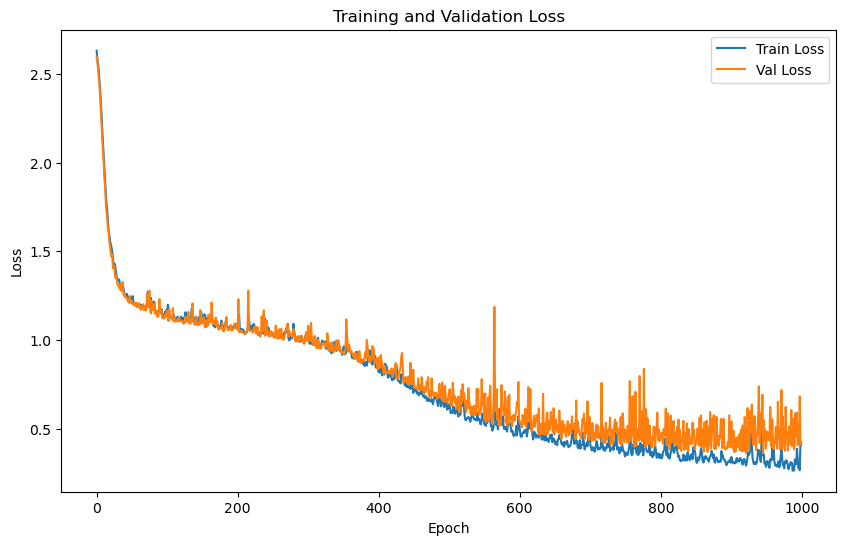

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5738 | Test Accuracy: 80.21%


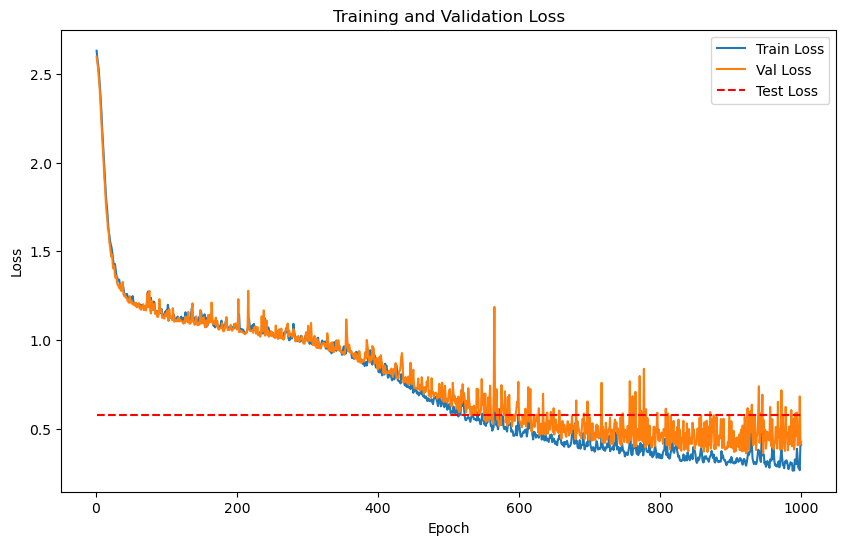

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 7.9740
    Batch [2/2], Train Loss: 7.7234
Epoch [1/2000], Avg Train Loss: 7.8487
Epoch [1/2000], Avg Val Loss: 3.5090
Validation loss improved from inf to 3.5090. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.7744
    Batch [2/2], Train Loss: 7.9553
Epoch [2/2000], Avg Train Loss: 7.8648
Epoch [2/2000], Avg Val Loss: 3.4657
Validation loss improved from 3.5090 to 3.4657. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.5774
    Batch [2/2], Train Loss: 7.6519
Epoch [3/2000], Avg Train Loss: 7.6147
Epoch [3/2000], Avg Val Loss: 3.4262
Validation loss improved from 3.4657 to 3.4262. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.6296
    Batch [2/2], Train Loss: 7.6205
Epoch [4/2000], Avg Train Loss: 7.6251
Epoch [4/2000], Avg Val Loss: 3.3900
Validation loss improved from 3.4262 to 3.3900. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 6.9805
    Batch [2/2], Train Loss: 6.7651
Epoch [9/2000], Avg Train Loss: 6.8728
Epoch [9/2000], Avg Val Loss: 3.2501
Validation loss improved from 3.2732 to 3.2501. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 6.8183
    Batch [2/2], Train Loss: 6.9207
Epoch [10/2000], Avg Train Loss: 6.8695
Epoch [10/2000], Avg Val Loss: 3.2290
Validation loss improved from 3.2501 to 3.2290. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 6.7047
    Batch [2/2], Train Loss: 6.5721
Epoch [11/2000], Avg Train Loss: 6.6384
Epoch [11/2000], Avg Val Loss: 3.2099
Validation loss improved from 3.2290 to 3.2099. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.6160
    Batch [2/2], Train Loss: 6.5780
Epoch [12/2000], Avg Train Loss: 6.5970
Epoch [12/2000], Avg Val Loss: 3.1927
Validation loss improved from 3.2099 to 3.1927. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2

    Batch [2/2], Train Loss: 6.5261
Epoch [13/2000], Avg Train Loss: 6.5912
Epoch [13/2000], Avg Val Loss: 3.1773
Validation loss improved from 3.1927 to 3.1773. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.5271
    Batch [2/2], Train Loss: 6.3873
Epoch [14/2000], Avg Train Loss: 6.4572
Epoch [14/2000], Avg Val Loss: 3.1635
Validation loss improved from 3.1773 to 3.1635. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.3660
    Batch [2/2], Train Loss: 6.3791
Epoch [15/2000], Avg Train Loss: 6.3725
Epoch [15/2000], Avg Val Loss: 3.1513
Validation loss improved from 3.1635 to 3.1513. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.2069
    Batch [2/2], Train Loss: 6.2337
Epoch [16/2000], Avg Train Loss: 6.2203
Epoch [16/2000], Avg Val Loss: 3.1405
Validation loss improved from 3.1513 to 3.1405. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.1899
    Batch [2

    Batch [1/2], Train Loss: 5.9270
    Batch [2/2], Train Loss: 5.9337
Epoch [21/2000], Avg Train Loss: 5.9303
Epoch [21/2000], Avg Val Loss: 3.1012
Validation loss improved from 3.1073 to 3.1012. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 5.9694
    Batch [2/2], Train Loss: 5.8519
Epoch [22/2000], Avg Train Loss: 5.9107
Epoch [22/2000], Avg Val Loss: 3.0958
Validation loss improved from 3.1012 to 3.0958. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 5.7841
    Batch [2/2], Train Loss: 5.7423
Epoch [23/2000], Avg Train Loss: 5.7632
Epoch [23/2000], Avg Val Loss: 3.0909
Validation loss improved from 3.0958 to 3.0909. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.7700
    Batch [2/2], Train Loss: 5.7485
Epoch [24/2000], Avg Train Loss: 5.7592
Epoch [24/2000], Avg Val Loss: 3.0865
Validation loss improved from 3.0909 to 3.0865. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.5982
    Batch [2/2], Train Loss: 5.5343
Epoch [29/2000], Avg Train Loss: 5.5662
Epoch [29/2000], Avg Val Loss: 3.0711
Validation loss improved from 3.0735 to 3.0711. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.4609
    Batch [2/2], Train Loss: 5.5215
Epoch [30/2000], Avg Train Loss: 5.4912
Epoch [30/2000], Avg Val Loss: 3.0688
Validation loss improved from 3.0711 to 3.0688. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.4497
    Batch [2/2], Train Loss: 5.4724
Epoch [31/2000], Avg Train Loss: 5.4610
Epoch [31/2000], Avg Val Loss: 3.0668
Validation loss improved from 3.0688 to 3.0668. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.4584
    Batch [2/2], Train Loss: 5.3581
Epoch [32/2000], Avg Train Loss: 5.4083
Epoch [32/2000], Avg Val Loss: 3.0649
Validation loss improved from 3.0668 to 3.0649. Saving model...

LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 5.3792
    Batch [2/2], Train Loss: 5.3958
Epoch [33/2000], Avg Train Loss: 5.3875
Epoch [33/2000], Avg Val Loss: 3.0630
Validation loss improved from 3.0649 to 3.0630. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.3114
    Batch [2/2], Train Loss: 5.3765
Epoch [34/2000], Avg Train Loss: 5.3440
Epoch [34/2000], Avg Val Loss: 3.0613
Validation loss improved from 3.0630 to 3.0613. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.3484
    Batch [2/2], Train Loss: 5.3943
Epoch [35/2000], Avg Train Loss: 5.3713
Epoch [35/2000], Avg Val Loss: 3.0597
Validation loss improved from 3.0613 to 3.0597. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.3524
    Batch [2/2], Train Loss: 5.3462
Epoch [36/2000], Avg Train Loss: 5.3493
Epoch [36/2000], Avg Val Loss: 3.0582
Validation loss improved from 3.0597 to 3.0582. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.2317
Epoch [41/2000], Avg Train Loss: 5.2490
Epoch [41/2000], Avg Val Loss: 3.0516
Validation loss improved from 3.0529 to 3.0516. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 5.0963
    Batch [2/2], Train Loss: 5.2638
Epoch [42/2000], Avg Train Loss: 5.1800
Epoch [42/2000], Avg Val Loss: 3.0504
Validation loss improved from 3.0516 to 3.0504. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 5.2469
    Batch [2/2], Train Loss: 5.1335
Epoch [43/2000], Avg Train Loss: 5.1902
Epoch [43/2000], Avg Val Loss: 3.0492
Validation loss improved from 3.0504 to 3.0492. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 5.1990
    Batch [2/2], Train Loss: 5.1651
Epoch [44/2000], Avg Train Loss: 5.1820
Epoch [44/2000], Avg Val Loss: 3.0481
Validation loss improved from 3.0492 to 3.0481. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.2032
    Batch [2

    Batch [2/2], Train Loss: 5.1093
Epoch [48/2000], Avg Train Loss: 5.1107
Epoch [48/2000], Avg Val Loss: 3.0431
Validation loss improved from 3.0444 to 3.0431. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 5.1557
    Batch [2/2], Train Loss: 5.0737
Epoch [49/2000], Avg Train Loss: 5.1147
Epoch [49/2000], Avg Val Loss: 3.0416
Validation loss improved from 3.0431 to 3.0416. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 5.0557
    Batch [2/2], Train Loss: 5.1189
Epoch [50/2000], Avg Train Loss: 5.0873
Epoch [50/2000], Avg Val Loss: 3.0401
Validation loss improved from 3.0416 to 3.0401. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 5.0395
    Batch [2/2], Train Loss: 5.0796
Epoch [51/2000], Avg Train Loss: 5.0596
Epoch [51/2000], Avg Val Loss: 3.0387
Validation loss improved from 3.0401 to 3.0387. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 5.0829


    Batch [2/2], Train Loss: 4.9846
Epoch [52/2000], Avg Train Loss: 5.0338
Epoch [52/2000], Avg Val Loss: 3.0374
Validation loss improved from 3.0387 to 3.0374. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 5.0438
    Batch [2/2], Train Loss: 5.0152
Epoch [53/2000], Avg Train Loss: 5.0295
Epoch [53/2000], Avg Val Loss: 3.0359
Validation loss improved from 3.0374 to 3.0359. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.9418
    Batch [2/2], Train Loss: 5.0355
Epoch [54/2000], Avg Train Loss: 4.9887
Epoch [54/2000], Avg Val Loss: 3.0344
Validation loss improved from 3.0359 to 3.0344. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 5.0599
    Batch [2/2], Train Loss: 5.0780
Epoch [55/2000], Avg Train Loss: 5.0690
Epoch [55/2000], Avg Val Loss: 3.0330
Validation loss improved from 3.0344 to 3.0330. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 5.0564
    Batch [2

    Batch [2/2], Train Loss: 4.9832
Epoch [61/2000], Avg Train Loss: 4.9546
Epoch [61/2000], Avg Val Loss: 3.0238
Validation loss improved from 3.0255 to 3.0238. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.9113
    Batch [2/2], Train Loss: 4.9988
Epoch [62/2000], Avg Train Loss: 4.9550
Epoch [62/2000], Avg Val Loss: 3.0221
Validation loss improved from 3.0238 to 3.0221. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 4.9609
    Batch [2/2], Train Loss: 5.0295
Epoch [63/2000], Avg Train Loss: 4.9952
Epoch [63/2000], Avg Val Loss: 3.0204
Validation loss improved from 3.0221 to 3.0204. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.9643
    Batch [2/2], Train Loss: 4.9747
Epoch [64/2000], Avg Train Loss: 4.9695
Epoch [64/2000], Avg Val Loss: 3.0186
Validation loss improved from 3.0204 to 3.0186. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.9754
    Batch [2

Epoch [68/2000], Avg Val Loss: 3.0120
Validation loss improved from 3.0137 to 3.0120. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 4.8887
    Batch [2/2], Train Loss: 4.9305
Epoch [69/2000], Avg Train Loss: 4.9096
Epoch [69/2000], Avg Val Loss: 3.0102
Validation loss improved from 3.0120 to 3.0102. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 4.9385
    Batch [2/2], Train Loss: 4.9077
Epoch [70/2000], Avg Train Loss: 4.9231
Epoch [70/2000], Avg Val Loss: 3.0084
Validation loss improved from 3.0102 to 3.0084. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 4.8785


    Batch [2/2], Train Loss: 4.8793
Epoch [71/2000], Avg Train Loss: 4.8789
Epoch [71/2000], Avg Val Loss: 3.0067
Validation loss improved from 3.0084 to 3.0067. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 4.8351
    Batch [2/2], Train Loss: 4.8643
Epoch [72/2000], Avg Train Loss: 4.8497
Epoch [72/2000], Avg Val Loss: 3.0049
Validation loss improved from 3.0067 to 3.0049. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 4.8473
    Batch [2/2], Train Loss: 4.9224
Epoch [73/2000], Avg Train Loss: 4.8848
Epoch [73/2000], Avg Val Loss: 3.0031
Validation loss improved from 3.0049 to 3.0031. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 4.9052
    Batch [2/2], Train Loss: 4.8838
Epoch [74/2000], Avg Train Loss: 4.8945
Epoch [74/2000], Avg Val Loss: 3.0013
Validation loss improved from 3.0031 to 3.0013. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.8648
    Batch [2

    Batch [1/2], Train Loss: 4.8512
    Batch [2/2], Train Loss: 4.8718
Epoch [81/2000], Avg Train Loss: 4.8615
Epoch [81/2000], Avg Val Loss: 2.9887
Validation loss improved from 2.9905 to 2.9887. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.7887
    Batch [2/2], Train Loss: 4.8048
Epoch [82/2000], Avg Train Loss: 4.7968
Epoch [82/2000], Avg Val Loss: 2.9869
Validation loss improved from 2.9887 to 2.9869. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.8542
    Batch [2/2], Train Loss: 4.8433
Epoch [83/2000], Avg Train Loss: 4.8488
Epoch [83/2000], Avg Val Loss: 2.9852
Validation loss improved from 2.9869 to 2.9852. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.8280
    Batch [2/2], Train Loss: 4.8194
Epoch [84/2000], Avg Train Loss: 4.8237
Epoch [84/2000], Avg Val Loss: 2.9833
Validation loss improved from 2.9852 to 2.9833. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.8320
    Batch [2/2], Train Loss: 4.8291
Epoch [88/2000], Avg Train Loss: 4.8306
Epoch [88/2000], Avg Val Loss: 2.9756
Validation loss improved from 2.9776 to 2.9756. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.7772
    Batch [2/2], Train Loss: 4.7572
Epoch [89/2000], Avg Train Loss: 4.7672
Epoch [89/2000], Avg Val Loss: 2.9736
Validation loss improved from 2.9756 to 2.9736. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.8028
    Batch [2/2], Train Loss: 4.7661
Epoch [90/2000], Avg Train Loss: 4.7845
Epoch [90/2000], Avg Val Loss: 2.9718
Validation loss improved from 2.9736 to 2.9718. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.7404
    Batch [2/2], Train Loss: 4.7706
Epoch [91/2000], Avg Train Loss: 4.7555
Epoch [91/2000], Avg Val Loss: 2.9698
Validation loss improved from 2.9718 to 2.9698. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.7752
    Batch [2/2], Train Loss: 4.7228
Epoch [101/2000], Avg Train Loss: 4.7490
Epoch [101/2000], Avg Val Loss: 2.9506
Validation loss improved from 2.9526 to 2.9506. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.7199
    Batch [2/2], Train Loss: 4.6817
Epoch [102/2000], Avg Train Loss: 4.7008
Epoch [102/2000], Avg Val Loss: 2.9486
Validation loss improved from 2.9506 to 2.9486. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.7516
    Batch [2/2], Train Loss: 4.6733
Epoch [103/2000], Avg Train Loss: 4.7125
Epoch [103/2000], Avg Val Loss: 2.9465
Validation loss improved from 2.9486 to 2.9465. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.7239
    Batch [2/2], Train Loss: 4.6988
Epoch [104/2000], Avg Train Loss: 4.7114
Epoch [104/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9465 to 2.9445. Saving model...

LOG: Epoch [105/2000] - Training


    Batch [2/2], Train Loss: 4.7009
Epoch [108/2000], Avg Train Loss: 4.6826
Epoch [108/2000], Avg Val Loss: 2.9366
Validation loss improved from 2.9387 to 2.9366. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.7086
    Batch [2/2], Train Loss: 4.6735
Epoch [109/2000], Avg Train Loss: 4.6911
Epoch [109/2000], Avg Val Loss: 2.9345
Validation loss improved from 2.9366 to 2.9345. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.7005
    Batch [2/2], Train Loss: 4.6818
Epoch [110/2000], Avg Train Loss: 4.6911
Epoch [110/2000], Avg Val Loss: 2.9323
Validation loss improved from 2.9345 to 2.9323. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 4.7280
    Batch [2/2], Train Loss: 4.7103
Epoch [111/2000], Avg Train Loss: 4.7191
Epoch [111/2000], Avg Val Loss: 2.9301
Validation loss improved from 2.9323 to 2.9301. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 4.7599


    Batch [2/2], Train Loss: 4.6827
Epoch [121/2000], Avg Train Loss: 4.6771
Epoch [121/2000], Avg Val Loss: 2.9102
Validation loss improved from 2.9123 to 2.9102. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.6423
    Batch [2/2], Train Loss: 4.6529
Epoch [122/2000], Avg Train Loss: 4.6476
Epoch [122/2000], Avg Val Loss: 2.9082
Validation loss improved from 2.9102 to 2.9082. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.6340
    Batch [2/2], Train Loss: 4.6501
Epoch [123/2000], Avg Train Loss: 4.6421
Epoch [123/2000], Avg Val Loss: 2.9061
Validation loss improved from 2.9082 to 2.9061. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 4.6264
    Batch [2/2], Train Loss: 4.6254
Epoch [124/2000], Avg Train Loss: 4.6259
Epoch [124/2000], Avg Val Loss: 2.9040
Validation loss improved from 2.9061 to 2.9040. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 4.6360


Epoch [128/2000], Avg Val Loss: 2.8954
Validation loss improved from 2.8976 to 2.8954. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 4.6273
    Batch [2/2], Train Loss: 4.6041
Epoch [129/2000], Avg Train Loss: 4.6157
Epoch [129/2000], Avg Val Loss: 2.8932
Validation loss improved from 2.8954 to 2.8932. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 4.6474
    Batch [2/2], Train Loss: 4.6535
Epoch [130/2000], Avg Train Loss: 4.6505
Epoch [130/2000], Avg Val Loss: 2.8910
Validation loss improved from 2.8932 to 2.8910. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 4.6262
    Batch [2/2], Train Loss: 4.6552
Epoch [131/2000], Avg Train Loss: 4.6407
Epoch [131/2000], Avg Val Loss: 2.8887
Validation loss improved from 2.8910 to 2.8887. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.6210
    Batch [2/2], Train Loss: 4.6214
Epoch [132/2000], Avg Train Loss: 4.6212


    Batch [1/2], Train Loss: 4.5413
    Batch [2/2], Train Loss: 4.6252
Epoch [142/2000], Avg Train Loss: 4.5833
Epoch [142/2000], Avg Val Loss: 2.8654
Validation loss improved from 2.8676 to 2.8654. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.5985
    Batch [2/2], Train Loss: 4.5986
Epoch [143/2000], Avg Train Loss: 4.5986
Epoch [143/2000], Avg Val Loss: 2.8633
Validation loss improved from 2.8654 to 2.8633. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.5382
    Batch [2/2], Train Loss: 4.5332
Epoch [144/2000], Avg Train Loss: 4.5357
Epoch [144/2000], Avg Val Loss: 2.8611
Validation loss improved from 2.8633 to 2.8611. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.6400
    Batch [2/2], Train Loss: 4.5595
Epoch [145/2000], Avg Train Loss: 4.5997
Epoch [145/2000], Avg Val Loss: 2.8589
Validation loss improved from 2.8611 to 2.8589. Saving model...

LOG: Epoch [146/2000] - Training


Epoch [146/2000], Avg Val Loss: 2.8567
Validation loss improved from 2.8589 to 2.8567. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 4.5273
    Batch [2/2], Train Loss: 4.5493
Epoch [147/2000], Avg Train Loss: 4.5383
Epoch [147/2000], Avg Val Loss: 2.8543
Validation loss improved from 2.8567 to 2.8543. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.6085
    Batch [2/2], Train Loss: 4.5501
Epoch [148/2000], Avg Train Loss: 4.5793
Epoch [148/2000], Avg Val Loss: 2.8520
Validation loss improved from 2.8543 to 2.8520. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 4.5507
    Batch [2/2], Train Loss: 4.5948
Epoch [149/2000], Avg Train Loss: 4.5728
Epoch [149/2000], Avg Val Loss: 2.8497
Validation loss improved from 2.8520 to 2.8497. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 4.5292
    Batch [2/2], Train Loss: 4.5702
Epoch [150/2000], Avg Train Loss: 4.5497


Epoch [161/2000], Avg Val Loss: 2.8219
Validation loss improved from 2.8242 to 2.8219. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 4.5231
    Batch [2/2], Train Loss: 4.4785
Epoch [162/2000], Avg Train Loss: 4.5008
Epoch [162/2000], Avg Val Loss: 2.8196
Validation loss improved from 2.8219 to 2.8196. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 4.5504
    Batch [2/2], Train Loss: 4.5216
Epoch [163/2000], Avg Train Loss: 4.5360
Epoch [163/2000], Avg Val Loss: 2.8174
Validation loss improved from 2.8196 to 2.8174. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.5019


    Batch [2/2], Train Loss: 4.5168
Epoch [164/2000], Avg Train Loss: 4.5094
Epoch [164/2000], Avg Val Loss: 2.8150
Validation loss improved from 2.8174 to 2.8150. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.4983
    Batch [2/2], Train Loss: 4.4683
Epoch [165/2000], Avg Train Loss: 4.4833
Epoch [165/2000], Avg Val Loss: 2.8126
Validation loss improved from 2.8150 to 2.8126. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.5399
    Batch [2/2], Train Loss: 4.4715
Epoch [166/2000], Avg Train Loss: 4.5057
Epoch [166/2000], Avg Val Loss: 2.8103
Validation loss improved from 2.8126 to 2.8103. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.4907
    Batch [2/2], Train Loss: 4.5050
Epoch [167/2000], Avg Train Loss: 4.4979
Epoch [167/2000], Avg Val Loss: 2.8080
Validation loss improved from 2.8103 to 2.8080. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.4794


    Batch [2/2], Train Loss: 4.4674
Epoch [180/2000], Avg Train Loss: 4.4625


Epoch [180/2000], Avg Val Loss: 2.7780
Validation loss improved from 2.7805 to 2.7780. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 4.4392
    Batch [2/2], Train Loss: 4.4353
Epoch [181/2000], Avg Train Loss: 4.4373
Epoch [181/2000], Avg Val Loss: 2.7756
Validation loss improved from 2.7780 to 2.7756. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 4.4630
    Batch [2/2], Train Loss: 4.4676
Epoch [182/2000], Avg Train Loss: 4.4653
Epoch [182/2000], Avg Val Loss: 2.7732
Validation loss improved from 2.7756 to 2.7732. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 4.4634
    Batch [2/2], Train Loss: 4.4942
Epoch [183/2000], Avg Train Loss: 4.4788
Epoch [183/2000], Avg Val Loss: 2.7708
Validation loss improved from 2.7732 to 2.7708. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 4.4554
    Batch [2/2], Train Loss: 4.4382
Epoch [184/2000], Avg Train Loss: 4.4468


    Batch [1/2], Train Loss: 4.3807
    Batch [2/2], Train Loss: 4.3573
Epoch [200/2000], Avg Train Loss: 4.3690
Epoch [200/2000], Avg Val Loss: 2.7300
Validation loss improved from 2.7324 to 2.7300. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.4249
    Batch [2/2], Train Loss: 4.3676
Epoch [201/2000], Avg Train Loss: 4.3963
Epoch [201/2000], Avg Val Loss: 2.7276
Validation loss improved from 2.7300 to 2.7276. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 4.3972
    Batch [2/2], Train Loss: 4.3504
Epoch [202/2000], Avg Train Loss: 4.3738
Epoch [202/2000], Avg Val Loss: 2.7252
Validation loss improved from 2.7276 to 2.7252. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 4.4075
    Batch [2/2], Train Loss: 4.3972
Epoch [203/2000], Avg Train Loss: 4.4023
Epoch [203/2000], Avg Val Loss: 2.7229
Validation loss improved from 2.7252 to 2.7229. Saving model...

LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 4.3268
    Batch [2/2], Train Loss: 4.3462
Epoch [220/2000], Avg Train Loss: 4.3365
Epoch [220/2000], Avg Val Loss: 2.6809
Validation loss improved from 2.6835 to 2.6809. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 4.3309
    Batch [2/2], Train Loss: 4.3365
Epoch [221/2000], Avg Train Loss: 4.3337
Epoch [221/2000], Avg Val Loss: 2.6784
Validation loss improved from 2.6809 to 2.6784. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 4.3179
    Batch [2/2], Train Loss: 4.3192
Epoch [222/2000], Avg Train Loss: 4.3185
Epoch [222/2000], Avg Val Loss: 2.6759
Validation loss improved from 2.6784 to 2.6759. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.3088
    Batch [2/2], Train Loss: 4.2989
Epoch [223/2000], Avg Train Loss: 4.3038
Epoch [223/2000], Avg Val Loss: 2.6735
Validation loss improved from 2.6759 to 2.6735. Saving model...

LOG: Epoch [224/2000] - Training


    Batch [2/2], Train Loss: 4.2304
Epoch [240/2000], Avg Train Loss: 4.2659
Epoch [240/2000], Avg Val Loss: 2.6286
Validation loss improved from 2.6313 to 2.6286. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 4.2627
    Batch [2/2], Train Loss: 4.2414
Epoch [241/2000], Avg Train Loss: 4.2521
Epoch [241/2000], Avg Val Loss: 2.6259
Validation loss improved from 2.6286 to 2.6259. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 4.2166
    Batch [2/2], Train Loss: 4.2132
Epoch [242/2000], Avg Train Loss: 4.2149
Epoch [242/2000], Avg Val Loss: 2.6232
Validation loss improved from 2.6259 to 2.6232. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 4.2489
    Batch [2/2], Train Loss: 4.2179
Epoch [243/2000], Avg Train Loss: 4.2334
Epoch [243/2000], Avg Val Loss: 2.6206
Validation loss improved from 2.6232 to 2.6206. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.3232


    Batch [1/2], Train Loss: 4.2235
    Batch [2/2], Train Loss: 4.1898
Epoch [262/2000], Avg Train Loss: 4.2067
Epoch [262/2000], Avg Val Loss: 2.5759
Validation loss improved from 2.5782 to 2.5759. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 4.1375
    Batch [2/2], Train Loss: 4.2019
Epoch [263/2000], Avg Train Loss: 4.1697
Epoch [263/2000], Avg Val Loss: 2.5737
Validation loss improved from 2.5759 to 2.5737. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 4.2332
    Batch [2/2], Train Loss: 4.1703
Epoch [264/2000], Avg Train Loss: 4.2017
Epoch [264/2000], Avg Val Loss: 2.5714
Validation loss improved from 2.5737 to 2.5714. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.2117
    Batch [2/2], Train Loss: 4.1830
Epoch [265/2000], Avg Train Loss: 4.1973
Epoch [265/2000], Avg Val Loss: 2.5692
Validation loss improved from 2.5714 to 2.5692. Saving model...

LOG: Epoch [266/2000] - Training


    Batch [2/2], Train Loss: 4.1615
Epoch [282/2000], Avg Train Loss: 4.1610
Epoch [282/2000], Avg Val Loss: 2.5327
Validation loss improved from 2.5347 to 2.5327. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 4.1693
    Batch [2/2], Train Loss: 4.1322
Epoch [283/2000], Avg Train Loss: 4.1508
Epoch [283/2000], Avg Val Loss: 2.5307
Validation loss improved from 2.5327 to 2.5307. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.1635
    Batch [2/2], Train Loss: 4.1286
Epoch [284/2000], Avg Train Loss: 4.1461
Epoch [284/2000], Avg Val Loss: 2.5287
Validation loss improved from 2.5307 to 2.5287. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.1120
    Batch [2/2], Train Loss: 4.1213
Epoch [285/2000], Avg Train Loss: 4.1166
Epoch [285/2000], Avg Val Loss: 2.5268
Validation loss improved from 2.5287 to 2.5268. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.1301


    Batch [1/2], Train Loss: 4.0893
    Batch [2/2], Train Loss: 4.1055
Epoch [303/2000], Avg Train Loss: 4.0974
Epoch [303/2000], Avg Val Loss: 2.4936
Validation loss improved from 2.4953 to 2.4936. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 4.1071
    Batch [2/2], Train Loss: 4.0960
Epoch [304/2000], Avg Train Loss: 4.1016
Epoch [304/2000], Avg Val Loss: 2.4918
Validation loss improved from 2.4936 to 2.4918. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 4.1058
    Batch [2/2], Train Loss: 4.0674
Epoch [305/2000], Avg Train Loss: 4.0866
Epoch [305/2000], Avg Val Loss: 2.4900
Validation loss improved from 2.4918 to 2.4900. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 4.1028
    Batch [2/2], Train Loss: 4.0600
Epoch [306/2000], Avg Train Loss: 4.0814
Epoch [306/2000], Avg Val Loss: 2.4881
Validation loss improved from 2.4900 to 2.4881. Saving model...

LOG: Epoch [307/2000] - Training


Epoch [322/2000], Avg Val Loss: 2.4611
Validation loss improved from 2.4625 to 2.4611. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 4.0171
    Batch [2/2], Train Loss: 4.0921
Epoch [323/2000], Avg Train Loss: 4.0546
Epoch [323/2000], Avg Val Loss: 2.4598
Validation loss improved from 2.4611 to 2.4598. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 4.0478
    Batch [2/2], Train Loss: 4.0649
Epoch [324/2000], Avg Train Loss: 4.0563
Epoch [324/2000], Avg Val Loss: 2.4585
Validation loss improved from 2.4598 to 2.4585. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 4.0254
    Batch [2/2], Train Loss: 4.0421
Epoch [325/2000], Avg Train Loss: 4.0337
Epoch [325/2000], Avg Val Loss: 2.4572
Validation loss improved from 2.4585 to 2.4572. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 4.0318
    Batch [2/2], Train Loss: 4.0520
Epoch [326/2000], Avg Train Loss: 4.0419


    Batch [1/2], Train Loss: 4.0486
    Batch [2/2], Train Loss: 3.9760
Epoch [343/2000], Avg Train Loss: 4.0123
Epoch [343/2000], Avg Val Loss: 2.4346
Validation loss improved from 2.4357 to 2.4346. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 4.0107
    Batch [2/2], Train Loss: 4.0683
Epoch [344/2000], Avg Train Loss: 4.0395
Epoch [344/2000], Avg Val Loss: 2.4334
Validation loss improved from 2.4346 to 2.4334. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 4.0452
    Batch [2/2], Train Loss: 3.9802
Epoch [345/2000], Avg Train Loss: 4.0127
Epoch [345/2000], Avg Val Loss: 2.4322
Validation loss improved from 2.4334 to 2.4322. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 3.9896
    Batch [2/2], Train Loss: 4.0159
Epoch [346/2000], Avg Train Loss: 4.0027
Epoch [346/2000], Avg Val Loss: 2.4309
Validation loss improved from 2.4322 to 2.4309. Saving model...

LOG: Epoch [347/2000] - Training


    Batch [2/2], Train Loss: 3.9488
Epoch [363/2000], Avg Train Loss: 3.9335
Epoch [363/2000], Avg Val Loss: 2.4089
Validation loss improved from 2.4103 to 2.4089. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 3.9190
    Batch [2/2], Train Loss: 3.9459
Epoch [364/2000], Avg Train Loss: 3.9324
Epoch [364/2000], Avg Val Loss: 2.4078
Validation loss improved from 2.4089 to 2.4078. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 3.9612
    Batch [2/2], Train Loss: 4.0053
Epoch [365/2000], Avg Train Loss: 3.9832
Epoch [365/2000], Avg Val Loss: 2.4067
Validation loss improved from 2.4078 to 2.4067. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 3.9857
    Batch [2/2], Train Loss: 4.0045
Epoch [366/2000], Avg Train Loss: 3.9951
Epoch [366/2000], Avg Val Loss: 2.4058
Validation loss improved from 2.4067 to 2.4058. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 3.9720


Epoch [383/2000], Avg Val Loss: 2.3883
Validation loss improved from 2.3888 to 2.3883. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 3.9434
    Batch [2/2], Train Loss: 3.8750
Epoch [384/2000], Avg Train Loss: 3.9092
Epoch [384/2000], Avg Val Loss: 2.3875
Validation loss improved from 2.3883 to 2.3875. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 3.9128
    Batch [2/2], Train Loss: 3.9079
Epoch [385/2000], Avg Train Loss: 3.9103
Epoch [385/2000], Avg Val Loss: 2.3867
Validation loss improved from 2.3875 to 2.3867. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 3.8880
    Batch [2/2], Train Loss: 3.9140
Epoch [386/2000], Avg Train Loss: 3.9010
Epoch [386/2000], Avg Val Loss: 2.3859
Validation loss improved from 2.3867 to 2.3859. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 3.9291
    Batch [2/2], Train Loss: 3.9442
Epoch [387/2000], Avg Train Loss: 3.9367


Epoch [404/2000], Avg Val Loss: 2.3682
Validation loss improved from 2.3688 to 2.3682. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 3.9262
    Batch [2/2], Train Loss: 3.8957
Epoch [405/2000], Avg Train Loss: 3.9109
Epoch [405/2000], Avg Val Loss: 2.3674
Validation loss improved from 2.3682 to 2.3674. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 3.8840
    Batch [2/2], Train Loss: 3.8853
Epoch [406/2000], Avg Train Loss: 3.8846
Epoch [406/2000], Avg Val Loss: 2.3665
Validation loss improved from 2.3674 to 2.3665. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 3.8390
    Batch [2/2], Train Loss: 3.8652
Epoch [407/2000], Avg Train Loss: 3.8521
Epoch [407/2000], Avg Val Loss: 2.3656
Validation loss improved from 2.3665 to 2.3656. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 3.8651
    Batch [2/2], Train Loss: 3.8680
Epoch [408/2000], Avg Train Loss: 3.8666


    Batch [1/2], Train Loss: 3.8948
    Batch [2/2], Train Loss: 3.8136
Epoch [424/2000], Avg Train Loss: 3.8542
Epoch [424/2000], Avg Val Loss: 2.3492
Validation loss improved from 2.3499 to 2.3492. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 3.8314
    Batch [2/2], Train Loss: 3.8713
Epoch [425/2000], Avg Train Loss: 3.8513
Epoch [425/2000], Avg Val Loss: 2.3485
Validation loss improved from 2.3492 to 2.3485. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 3.8774
    Batch [2/2], Train Loss: 3.8280
Epoch [426/2000], Avg Train Loss: 3.8527
Epoch [426/2000], Avg Val Loss: 2.3478
Validation loss improved from 2.3485 to 2.3478. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 3.8693
    Batch [2/2], Train Loss: 3.8166
Epoch [427/2000], Avg Train Loss: 3.8429
Epoch [427/2000], Avg Val Loss: 2.3472
Validation loss improved from 2.3478 to 2.3472. Saving model...

LOG: Epoch [428/2000] - Training


    Batch [2/2], Train Loss: 3.8355
Epoch [444/2000], Avg Train Loss: 3.8409
Epoch [444/2000], Avg Val Loss: 2.3358
Validation loss improved from 2.3362 to 2.3358. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 3.7951
    Batch [2/2], Train Loss: 3.7936
Epoch [445/2000], Avg Train Loss: 3.7944
Epoch [445/2000], Avg Val Loss: 2.3353
Validation loss improved from 2.3358 to 2.3353. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 3.8711
    Batch [2/2], Train Loss: 3.8288
Epoch [446/2000], Avg Train Loss: 3.8499
Epoch [446/2000], Avg Val Loss: 2.3346
Validation loss improved from 2.3353 to 2.3346. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.7787
    Batch [2/2], Train Loss: 3.8192
Epoch [447/2000], Avg Train Loss: 3.7990
Epoch [447/2000], Avg Val Loss: 2.3339
Validation loss improved from 2.3346 to 2.3339. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.8407


    Batch [1/2], Train Loss: 3.8122
    Batch [2/2], Train Loss: 3.8011
Epoch [465/2000], Avg Train Loss: 3.8067
Epoch [465/2000], Avg Val Loss: 2.3264
Validation loss improved from 2.3266 to 2.3264. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.7901
    Batch [2/2], Train Loss: 3.7377
Epoch [466/2000], Avg Train Loss: 3.7639
Epoch [466/2000], Avg Val Loss: 2.3263
Validation loss improved from 2.3264 to 2.3263. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.7618
    Batch [2/2], Train Loss: 3.8153
Epoch [467/2000], Avg Train Loss: 3.7885
Epoch [467/2000], Avg Val Loss: 2.3260
Validation loss improved from 2.3263 to 2.3260. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 3.8075
    Batch [2/2], Train Loss: 3.8516
Epoch [468/2000], Avg Train Loss: 3.8295
Epoch [468/2000], Avg Val Loss: 2.3255
Validation loss improved from 2.3260 to 2.3255. Saving model...

LOG: Epoch [469/2000] - Training


    Batch [2/2], Train Loss: 3.7840
Epoch [485/2000], Avg Train Loss: 3.7503
Epoch [485/2000], Avg Val Loss: 2.3158
Validation loss improved from 2.3163 to 2.3158. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 3.7687
    Batch [2/2], Train Loss: 3.7629
Epoch [486/2000], Avg Train Loss: 3.7658
Epoch [486/2000], Avg Val Loss: 2.3151
Validation loss improved from 2.3158 to 2.3151. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 3.7597
    Batch [2/2], Train Loss: 3.8095
Epoch [487/2000], Avg Train Loss: 3.7846
Epoch [487/2000], Avg Val Loss: 2.3145
Validation loss improved from 2.3151 to 2.3145. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 3.7791
    Batch [2/2], Train Loss: 3.7506
Epoch [488/2000], Avg Train Loss: 3.7648
Epoch [488/2000], Avg Val Loss: 2.3141
Validation loss improved from 2.3145 to 2.3141. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 3.7574


    Batch [1/2], Train Loss: 3.7394
    Batch [2/2], Train Loss: 3.7299
Epoch [505/2000], Avg Train Loss: 3.7346
Epoch [505/2000], Avg Val Loss: 2.3061
Validation loss improved from 2.3067 to 2.3061. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 3.7037
    Batch [2/2], Train Loss: 3.7471
Epoch [506/2000], Avg Train Loss: 3.7254
Epoch [506/2000], Avg Val Loss: 2.3051
Validation loss improved from 2.3061 to 2.3051. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 3.7519
    Batch [2/2], Train Loss: 3.7623
Epoch [507/2000], Avg Train Loss: 3.7571
Epoch [507/2000], Avg Val Loss: 2.3043
Validation loss improved from 2.3051 to 2.3043. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 3.7143
    Batch [2/2], Train Loss: 3.6820
Epoch [508/2000], Avg Train Loss: 3.6981
Epoch [508/2000], Avg Val Loss: 2.3036
Validation loss improved from 2.3043 to 2.3036. Saving model...

LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 3.7333
    Batch [2/2], Train Loss: 3.7215
Epoch [523/2000], Avg Train Loss: 3.7274
Epoch [523/2000], Avg Val Loss: 2.2959
Validation loss improved from 2.2967 to 2.2959. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 3.6664
    Batch [2/2], Train Loss: 3.7268
Epoch [524/2000], Avg Train Loss: 3.6966
Epoch [524/2000], Avg Val Loss: 2.2951
Validation loss improved from 2.2959 to 2.2951. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 3.7695
    Batch [2/2], Train Loss: 3.6823
Epoch [525/2000], Avg Train Loss: 3.7259
Epoch [525/2000], Avg Val Loss: 2.2944
Validation loss improved from 2.2951 to 2.2944. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 3.7241
    Batch [2/2], Train Loss: 3.7758
Epoch [526/2000], Avg Train Loss: 3.7500
Epoch [526/2000], Avg Val Loss: 2.2938
Validation loss improved from 2.2944 to 2.2938. Saving model...

LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 3.7313
    Batch [2/2], Train Loss: 3.7007
Epoch [543/2000], Avg Train Loss: 3.7160
Epoch [543/2000], Avg Val Loss: 2.2882
Validation loss improved from 2.2886 to 2.2882. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.7538
    Batch [2/2], Train Loss: 3.6732
Epoch [544/2000], Avg Train Loss: 3.7135
Epoch [544/2000], Avg Val Loss: 2.2879
Validation loss improved from 2.2882 to 2.2879. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 3.6852
    Batch [2/2], Train Loss: 3.7116
Epoch [545/2000], Avg Train Loss: 3.6984
Epoch [545/2000], Avg Val Loss: 2.2879
Validation loss did not improve. Patience: 1/100

LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 3.7080
    Batch [2/2], Train Loss: 3.7773
Epoch [546/2000], Avg Train Loss: 3.7427
Epoch [546/2000], Avg Val Loss: 2.2883
Validation loss did not improve. Patience: 2/100

LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 3

Epoch [562/2000], Avg Val Loss: 2.2863
Validation loss improved from 2.2871 to 2.2863. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.6064
    Batch [2/2], Train Loss: 3.7167
Epoch [563/2000], Avg Train Loss: 3.6616
Epoch [563/2000], Avg Val Loss: 2.2855
Validation loss improved from 2.2863 to 2.2855. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.6995
    Batch [2/2], Train Loss: 3.6830
Epoch [564/2000], Avg Train Loss: 3.6913
Epoch [564/2000], Avg Val Loss: 2.2849
Validation loss improved from 2.2855 to 2.2849. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.6825
    Batch [2/2], Train Loss: 3.6840
Epoch [565/2000], Avg Train Loss: 3.6833
Epoch [565/2000], Avg Val Loss: 2.2844
Validation loss improved from 2.2849 to 2.2844. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 3.7346
    Batch [2/2], Train Loss: 3.7067
Epoch [566/2000], Avg Train Loss: 3.7206


    Batch [2/2], Train Loss: 3.6286
Epoch [582/2000], Avg Train Loss: 3.6573
Epoch [582/2000], Avg Val Loss: 2.2784
Validation loss improved from 2.2789 to 2.2784. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 3.6396
    Batch [2/2], Train Loss: 3.6277
Epoch [583/2000], Avg Train Loss: 3.6337
Epoch [583/2000], Avg Val Loss: 2.2781
Validation loss improved from 2.2784 to 2.2781. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 3.7066
    Batch [2/2], Train Loss: 3.6616
Epoch [584/2000], Avg Train Loss: 3.6841
Epoch [584/2000], Avg Val Loss: 2.2777
Validation loss improved from 2.2781 to 2.2777. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.6240
    Batch [2/2], Train Loss: 3.6089
Epoch [585/2000], Avg Train Loss: 3.6165
Epoch [585/2000], Avg Val Loss: 2.2774
Validation loss improved from 2.2777 to 2.2774. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.6257


    Batch [1/2], Train Loss: 3.6496
    Batch [2/2], Train Loss: 3.6320
Epoch [602/2000], Avg Train Loss: 3.6408
Epoch [602/2000], Avg Val Loss: 2.2688
Validation loss improved from 2.2696 to 2.2688. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 3.6203
    Batch [2/2], Train Loss: 3.6790
Epoch [603/2000], Avg Train Loss: 3.6497
Epoch [603/2000], Avg Val Loss: 2.2682
Validation loss improved from 2.2688 to 2.2682. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 3.6256
    Batch [2/2], Train Loss: 3.6272
Epoch [604/2000], Avg Train Loss: 3.6264
Epoch [604/2000], Avg Val Loss: 2.2674
Validation loss improved from 2.2682 to 2.2674. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 3.6808
    Batch [2/2], Train Loss: 3.6558
Epoch [605/2000], Avg Train Loss: 3.6683
Epoch [605/2000], Avg Val Loss: 2.2666
Validation loss improved from 2.2674 to 2.2666. Saving model...

LOG: Epoch [606/2000] - Training


    Batch [2/2], Train Loss: 3.5891
Epoch [622/2000], Avg Train Loss: 3.6063
Epoch [622/2000], Avg Val Loss: 2.2560
Validation loss improved from 2.2568 to 2.2560. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 3.6377
    Batch [2/2], Train Loss: 3.6209
Epoch [623/2000], Avg Train Loss: 3.6293
Epoch [623/2000], Avg Val Loss: 2.2552
Validation loss improved from 2.2560 to 2.2552. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 3.6445
    Batch [2/2], Train Loss: 3.5712
Epoch [624/2000], Avg Train Loss: 3.6078
Epoch [624/2000], Avg Val Loss: 2.2544
Validation loss improved from 2.2552 to 2.2544. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.6531
    Batch [2/2], Train Loss: 3.5786
Epoch [625/2000], Avg Train Loss: 3.6159
Epoch [625/2000], Avg Val Loss: 2.2538
Validation loss improved from 2.2544 to 2.2538. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 3.6112


    Batch [2/2], Train Loss: 3.6252
Epoch [642/2000], Avg Train Loss: 3.5967
Epoch [642/2000], Avg Val Loss: 2.2501
Validation loss did not improve. Patience: 5/100

LOG: Epoch [643/2000] - Training
    Batch [1/2], Train Loss: 3.5961
    Batch [2/2], Train Loss: 3.6246
Epoch [643/2000], Avg Train Loss: 3.6103
Epoch [643/2000], Avg Val Loss: 2.2505
Validation loss did not improve. Patience: 6/100

LOG: Epoch [644/2000] - Training
    Batch [1/2], Train Loss: 3.5956
    Batch [2/2], Train Loss: 3.5874
Epoch [644/2000], Avg Train Loss: 3.5915
Epoch [644/2000], Avg Val Loss: 2.2505
Validation loss did not improve. Patience: 7/100

LOG: Epoch [645/2000] - Training
    Batch [1/2], Train Loss: 3.6211
    Batch [2/2], Train Loss: 3.5708
Epoch [645/2000], Avg Train Loss: 3.5959
Epoch [645/2000], Avg Val Loss: 2.2506
Validation loss did not improve. Patience: 8/100

LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 3.6036
    Batch [2/2], Train Loss: 3.5536
Epoch [646/2000], Avg Tr

    Batch [1/2], Train Loss: 3.5688
    Batch [2/2], Train Loss: 3.6197
Epoch [663/2000], Avg Train Loss: 3.5942
Epoch [663/2000], Avg Val Loss: 2.2454
Validation loss improved from 2.2455 to 2.2454. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 3.5520
    Batch [2/2], Train Loss: 3.5892
Epoch [664/2000], Avg Train Loss: 3.5706
Epoch [664/2000], Avg Val Loss: 2.2450
Validation loss improved from 2.2454 to 2.2450. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 3.5704
    Batch [2/2], Train Loss: 3.5675
Epoch [665/2000], Avg Train Loss: 3.5690
Epoch [665/2000], Avg Val Loss: 2.2444
Validation loss improved from 2.2450 to 2.2444. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/2], Train Loss: 3.5931
    Batch [2/2], Train Loss: 3.5848
Epoch [666/2000], Avg Train Loss: 3.5890
Epoch [666/2000], Avg Val Loss: 2.2435
Validation loss improved from 2.2444 to 2.2435. Saving model...

LOG: Epoch [667/2000] - Training


Epoch [683/2000], Avg Val Loss: 2.2336
Validation loss did not improve. Patience: 1/100

LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 3.5702
    Batch [2/2], Train Loss: 3.5987
Epoch [684/2000], Avg Train Loss: 3.5845
Epoch [684/2000], Avg Val Loss: 2.2341
Validation loss did not improve. Patience: 2/100

LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 3.5391
    Batch [2/2], Train Loss: 3.5000
Epoch [685/2000], Avg Train Loss: 3.5195
Epoch [685/2000], Avg Val Loss: 2.2347
Validation loss did not improve. Patience: 3/100

LOG: Epoch [686/2000] - Training
    Batch [1/2], Train Loss: 3.5644
    Batch [2/2], Train Loss: 3.5518
Epoch [686/2000], Avg Train Loss: 3.5581
Epoch [686/2000], Avg Val Loss: 2.2357
Validation loss did not improve. Patience: 4/100

LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 3.5608
    Batch [2/2], Train Loss: 3.5347
Epoch [687/2000], Avg Train Loss: 3.5478
Epoch [687/2000], Avg Val Loss: 2.2366
Validation loss did n

    Batch [2/2], Train Loss: 3.5833
Epoch [703/2000], Avg Train Loss: 3.5635
Epoch [703/2000], Avg Val Loss: 2.2379
Validation loss did not improve. Patience: 21/100

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 3.5324
    Batch [2/2], Train Loss: 3.5586
Epoch [704/2000], Avg Train Loss: 3.5455
Epoch [704/2000], Avg Val Loss: 2.2369
Validation loss did not improve. Patience: 22/100

LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 3.5645
    Batch [2/2], Train Loss: 3.5359
Epoch [705/2000], Avg Train Loss: 3.5502
Epoch [705/2000], Avg Val Loss: 2.2361
Validation loss did not improve. Patience: 23/100

LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 3.5836
    Batch [2/2], Train Loss: 3.5523
Epoch [706/2000], Avg Train Loss: 3.5680
Epoch [706/2000], Avg Val Loss: 2.2351
Validation loss did not improve. Patience: 24/100

LOG: Epoch [707/2000] - Training
    Batch [1/2], Train Loss: 3.5320
    Batch [2/2], Train Loss: 3.5592
Epoch [707/2000], Av

    Batch [1/2], Train Loss: 3.5664
    Batch [2/2], Train Loss: 3.5708
Epoch [724/2000], Avg Train Loss: 3.5686
Epoch [724/2000], Avg Val Loss: 2.2307
Validation loss improved from 2.2312 to 2.2307. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 3.5215
    Batch [2/2], Train Loss: 3.5720
Epoch [725/2000], Avg Train Loss: 3.5467
Epoch [725/2000], Avg Val Loss: 2.2305
Validation loss improved from 2.2307 to 2.2305. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 3.5896
    Batch [2/2], Train Loss: 3.4890
Epoch [726/2000], Avg Train Loss: 3.5393
Epoch [726/2000], Avg Val Loss: 2.2301
Validation loss improved from 2.2305 to 2.2301. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/2], Train Loss: 3.5150
    Batch [2/2], Train Loss: 3.5693
Epoch [727/2000], Avg Train Loss: 3.5421
Epoch [727/2000], Avg Val Loss: 2.2297
Validation loss improved from 2.2301 to 2.2297. Saving model...

LOG: Epoch [728/2000] - Training


    Batch [2/2], Train Loss: 3.5157
Epoch [744/2000], Avg Train Loss: 3.5195
Epoch [744/2000], Avg Val Loss: 2.2279
Validation loss did not improve. Patience: 1/100

LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 3.5251
    Batch [2/2], Train Loss: 3.5154
Epoch [745/2000], Avg Train Loss: 3.5202
Epoch [745/2000], Avg Val Loss: 2.2281
Validation loss did not improve. Patience: 2/100

LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 3.5563
    Batch [2/2], Train Loss: 3.5380
Epoch [746/2000], Avg Train Loss: 3.5471
Epoch [746/2000], Avg Val Loss: 2.2281
Validation loss did not improve. Patience: 3/100

LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 3.5203
    Batch [2/2], Train Loss: 3.4804
Epoch [747/2000], Avg Train Loss: 3.5004
Epoch [747/2000], Avg Val Loss: 2.2278
Validation loss improved from 2.2279 to 2.2278. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/2], Train Loss: 3.5268
    Batch [2/2], Train Loss: 3.5114
Epoch [74

    Batch [2/2], Train Loss: 3.4953
Epoch [763/2000], Avg Train Loss: 3.5080
Epoch [763/2000], Avg Val Loss: 2.2224
Validation loss improved from 2.2227 to 2.2224. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 3.5762
    Batch [2/2], Train Loss: 3.5287
Epoch [764/2000], Avg Train Loss: 3.5525
Epoch [764/2000], Avg Val Loss: 2.2219
Validation loss improved from 2.2224 to 2.2219. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/2], Train Loss: 3.5217
    Batch [2/2], Train Loss: 3.5386
Epoch [765/2000], Avg Train Loss: 3.5301
Epoch [765/2000], Avg Val Loss: 2.2218
Validation loss improved from 2.2219 to 2.2218. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/2], Train Loss: 3.5126
    Batch [2/2], Train Loss: 3.5175
Epoch [766/2000], Avg Train Loss: 3.5150
Epoch [766/2000], Avg Val Loss: 2.2218
Validation loss improved from 2.2218 to 2.2218. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 3.4897


    Batch [2/2], Train Loss: 3.5443
Epoch [774/2000], Avg Train Loss: 3.5410
Epoch [774/2000], Avg Val Loss: 2.2217
Validation loss did not improve. Patience: 4/100

LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 3.4650
    Batch [2/2], Train Loss: 3.4842
Epoch [775/2000], Avg Train Loss: 3.4746
Epoch [775/2000], Avg Val Loss: 2.2217
Validation loss did not improve. Patience: 5/100

LOG: Epoch [776/2000] - Training
    Batch [1/2], Train Loss: 3.5557
    Batch [2/2], Train Loss: 3.4583
Epoch [776/2000], Avg Train Loss: 3.5070
Epoch [776/2000], Avg Val Loss: 2.2216
Validation loss did not improve. Patience: 6/100

LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 3.4993
    Batch [2/2], Train Loss: 3.5242
Epoch [777/2000], Avg Train Loss: 3.5117
Epoch [777/2000], Avg Val Loss: 2.2217
Validation loss did not improve. Patience: 7/100

LOG: Epoch [778/2000] - Training
    Batch [1/2], Train Loss: 3.4788
    Batch [2/2], Train Loss: 3.4754
Epoch [778/2000], Avg Tr

    Batch [1/2], Train Loss: 3.4999
    Batch [2/2], Train Loss: 3.4547
Epoch [795/2000], Avg Train Loss: 3.4773
Epoch [795/2000], Avg Val Loss: 2.2185
Validation loss did not improve. Patience: 2/100

LOG: Epoch [796/2000] - Training
    Batch [1/2], Train Loss: 3.5129
    Batch [2/2], Train Loss: 3.5134
Epoch [796/2000], Avg Train Loss: 3.5131
Epoch [796/2000], Avg Val Loss: 2.2185
Validation loss did not improve. Patience: 3/100

LOG: Epoch [797/2000] - Training
    Batch [1/2], Train Loss: 3.5258
    Batch [2/2], Train Loss: 3.4974
Epoch [797/2000], Avg Train Loss: 3.5116
Epoch [797/2000], Avg Val Loss: 2.2187
Validation loss did not improve. Patience: 4/100

LOG: Epoch [798/2000] - Training
    Batch [1/2], Train Loss: 3.5065
    Batch [2/2], Train Loss: 3.4857
Epoch [798/2000], Avg Train Loss: 3.4961
Epoch [798/2000], Avg Val Loss: 2.2187
Validation loss did not improve. Patience: 5/100

LOG: Epoch [799/2000] - Training
    Batch [1/2], Train Loss: 3.4797
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.4946
Epoch [815/2000], Avg Train Loss: 3.4672
Epoch [815/2000], Avg Val Loss: 2.2175
Validation loss improved from 2.2176 to 2.2175. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/2], Train Loss: 3.4347
    Batch [2/2], Train Loss: 3.5106
Epoch [816/2000], Avg Train Loss: 3.4726
Epoch [816/2000], Avg Val Loss: 2.2173
Validation loss improved from 2.2175 to 2.2173. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/2], Train Loss: 3.4614
    Batch [2/2], Train Loss: 3.5043
Epoch [817/2000], Avg Train Loss: 3.4828
Epoch [817/2000], Avg Val Loss: 2.2170
Validation loss improved from 2.2173 to 2.2170. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/2], Train Loss: 3.4699
    Batch [2/2], Train Loss: 3.5040
Epoch [818/2000], Avg Train Loss: 3.4869
Epoch [818/2000], Avg Val Loss: 2.2165
Validation loss improved from 2.2170 to 2.2165. Saving model...

LOG: Epoch [819/2000] - Training
    Batch [1/2], Train Loss: 3.4732


    Batch [1/2], Train Loss: 3.4494
    Batch [2/2], Train Loss: 3.5127
Epoch [835/2000], Avg Train Loss: 3.4810
Epoch [835/2000], Avg Val Loss: 2.2116
Validation loss improved from 2.2119 to 2.2116. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/2], Train Loss: 3.5154
    Batch [2/2], Train Loss: 3.4597
Epoch [836/2000], Avg Train Loss: 3.4875
Epoch [836/2000], Avg Val Loss: 2.2114
Validation loss improved from 2.2116 to 2.2114. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/2], Train Loss: 3.4609
    Batch [2/2], Train Loss: 3.4488
Epoch [837/2000], Avg Train Loss: 3.4549
Epoch [837/2000], Avg Val Loss: 2.2114
Validation loss improved from 2.2114 to 2.2114. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/2], Train Loss: 3.4588
    Batch [2/2], Train Loss: 3.4474
Epoch [838/2000], Avg Train Loss: 3.4531
Epoch [838/2000], Avg Val Loss: 2.2113
Validation loss improved from 2.2114 to 2.2113. Saving model...

LOG: Epoch [839/2000] - Training


    Batch [1/2], Train Loss: 3.5132
    Batch [2/2], Train Loss: 3.4453
Epoch [856/2000], Avg Train Loss: 3.4793
Epoch [856/2000], Avg Val Loss: 2.2103
Validation loss did not improve. Patience: 7/100

LOG: Epoch [857/2000] - Training
    Batch [1/2], Train Loss: 3.4830
    Batch [2/2], Train Loss: 3.4812
Epoch [857/2000], Avg Train Loss: 3.4821
Epoch [857/2000], Avg Val Loss: 2.2105
Validation loss did not improve. Patience: 8/100

LOG: Epoch [858/2000] - Training
    Batch [1/2], Train Loss: 3.4359
    Batch [2/2], Train Loss: 3.4450
Epoch [858/2000], Avg Train Loss: 3.4404
Epoch [858/2000], Avg Val Loss: 2.2104
Validation loss did not improve. Patience: 9/100

LOG: Epoch [859/2000] - Training
    Batch [1/2], Train Loss: 3.4400
    Batch [2/2], Train Loss: 3.4529
Epoch [859/2000], Avg Train Loss: 3.4465
Epoch [859/2000], Avg Val Loss: 2.2101
Validation loss did not improve. Patience: 10/100

LOG: Epoch [860/2000] - Training
    Batch [1/2], Train Loss: 3.4727
    Batch [2/2], Train 

    Batch [1/2], Train Loss: 3.4127
    Batch [2/2], Train Loss: 3.4268
Epoch [877/2000], Avg Train Loss: 3.4197
Epoch [877/2000], Avg Val Loss: 2.2068
Validation loss did not improve. Patience: 3/100

LOG: Epoch [878/2000] - Training
    Batch [1/2], Train Loss: 3.4543
    Batch [2/2], Train Loss: 3.4589
Epoch [878/2000], Avg Train Loss: 3.4566
Epoch [878/2000], Avg Val Loss: 2.2069
Validation loss did not improve. Patience: 4/100

LOG: Epoch [879/2000] - Training
    Batch [1/2], Train Loss: 3.4154
    Batch [2/2], Train Loss: 3.4806
Epoch [879/2000], Avg Train Loss: 3.4480
Epoch [879/2000], Avg Val Loss: 2.2070
Validation loss did not improve. Patience: 5/100

LOG: Epoch [880/2000] - Training
    Batch [1/2], Train Loss: 3.4645
    Batch [2/2], Train Loss: 3.4944
Epoch [880/2000], Avg Train Loss: 3.4794
Epoch [880/2000], Avg Val Loss: 2.2069
Validation loss did not improve. Patience: 6/100

LOG: Epoch [881/2000] - Training
    Batch [1/2], Train Loss: 3.4607
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.4085
    Batch [2/2], Train Loss: 3.4282
Epoch [897/2000], Avg Train Loss: 3.4184
Epoch [897/2000], Avg Val Loss: 2.2083
Validation loss did not improve. Patience: 23/100

LOG: Epoch [898/2000] - Training
    Batch [1/2], Train Loss: 3.4871
    Batch [2/2], Train Loss: 3.4435
Epoch [898/2000], Avg Train Loss: 3.4653
Epoch [898/2000], Avg Val Loss: 2.2083
Validation loss did not improve. Patience: 24/100

LOG: Epoch [899/2000] - Training
    Batch [1/2], Train Loss: 3.4574
    Batch [2/2], Train Loss: 3.4750
Epoch [899/2000], Avg Train Loss: 3.4662
Epoch [899/2000], Avg Val Loss: 2.2083
Validation loss did not improve. Patience: 25/100

LOG: Epoch [900/2000] - Training
    Batch [1/2], Train Loss: 3.4456
    Batch [2/2], Train Loss: 3.4364
Epoch [900/2000], Avg Train Loss: 3.4410
Epoch [900/2000], Avg Val Loss: 2.2082
Validation loss did not improve. Patience: 26/100

LOG: Epoch [901/2000] - Training
    Batch [1/2], Train Loss: 3.4513
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4109
    Batch [2/2], Train Loss: 3.4447
Epoch [918/2000], Avg Train Loss: 3.4278
Epoch [918/2000], Avg Val Loss: 2.2040
Validation loss did not improve. Patience: 4/100

LOG: Epoch [919/2000] - Training
    Batch [1/2], Train Loss: 3.4002
    Batch [2/2], Train Loss: 3.4451
Epoch [919/2000], Avg Train Loss: 3.4226
Epoch [919/2000], Avg Val Loss: 2.2048
Validation loss did not improve. Patience: 5/100

LOG: Epoch [920/2000] - Training
    Batch [1/2], Train Loss: 3.4444
    Batch [2/2], Train Loss: 3.3865
Epoch [920/2000], Avg Train Loss: 3.4155
Epoch [920/2000], Avg Val Loss: 2.2053
Validation loss did not improve. Patience: 6/100

LOG: Epoch [921/2000] - Training
    Batch [1/2], Train Loss: 3.4625
    Batch [2/2], Train Loss: 3.3960
Epoch [921/2000], Avg Train Loss: 3.4292
Epoch [921/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 7/100

LOG: Epoch [922/2000] - Training
    Batch [1/2], Train Loss: 3.4225
    Batch [2/2], Train L

Epoch [937/2000], Avg Val Loss: 2.2052
Validation loss did not improve. Patience: 23/100

LOG: Epoch [938/2000] - Training
    Batch [1/2], Train Loss: 3.3935
    Batch [2/2], Train Loss: 3.4281
Epoch [938/2000], Avg Train Loss: 3.4108
Epoch [938/2000], Avg Val Loss: 2.2053
Validation loss did not improve. Patience: 24/100

LOG: Epoch [939/2000] - Training
    Batch [1/2], Train Loss: 3.3962
    Batch [2/2], Train Loss: 3.3937
Epoch [939/2000], Avg Train Loss: 3.3950
Epoch [939/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 25/100

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 3.4072
    Batch [2/2], Train Loss: 3.4031
Epoch [940/2000], Avg Train Loss: 3.4051
Epoch [940/2000], Avg Val Loss: 2.2059
Validation loss did not improve. Patience: 26/100

LOG: Epoch [941/2000] - Training
    Batch [1/2], Train Loss: 3.4097
    Batch [2/2], Train Loss: 3.3727
Epoch [941/2000], Avg Train Loss: 3.3912
Epoch [941/2000], Avg Val Loss: 2.2065
Validation loss d

    Batch [2/2], Train Loss: 3.3895
Epoch [958/2000], Avg Train Loss: 3.3967
Epoch [958/2000], Avg Val Loss: 2.2018
Validation loss improved from 2.2019 to 2.2018. Saving model...

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.4076
    Batch [2/2], Train Loss: 3.4322
Epoch [959/2000], Avg Train Loss: 3.4199
Epoch [959/2000], Avg Val Loss: 2.2013
Validation loss improved from 2.2018 to 2.2013. Saving model...

LOG: Epoch [960/2000] - Training
    Batch [1/2], Train Loss: 3.4072
    Batch [2/2], Train Loss: 3.4273
Epoch [960/2000], Avg Train Loss: 3.4173
Epoch [960/2000], Avg Val Loss: 2.2012
Validation loss improved from 2.2013 to 2.2012. Saving model...

LOG: Epoch [961/2000] - Training
    Batch [1/2], Train Loss: 3.4085
    Batch [2/2], Train Loss: 3.3607
Epoch [961/2000], Avg Train Loss: 3.3846
Epoch [961/2000], Avg Val Loss: 2.2013
Validation loss did not improve. Patience: 1/100

LOG: Epoch [962/2000] - Training
    Batch [1/2], Train Loss: 3.4061
    Batch [2/2]

    Batch [2/2], Train Loss: 3.3996
Epoch [977/2000], Avg Train Loss: 3.4040
Epoch [977/2000], Avg Val Loss: 2.2045
Validation loss did not improve. Patience: 17/100

LOG: Epoch [978/2000] - Training
    Batch [1/2], Train Loss: 3.3994
    Batch [2/2], Train Loss: 3.3974
Epoch [978/2000], Avg Train Loss: 3.3984
Epoch [978/2000], Avg Val Loss: 2.2046
Validation loss did not improve. Patience: 18/100

LOG: Epoch [979/2000] - Training
    Batch [1/2], Train Loss: 3.4018
    Batch [2/2], Train Loss: 3.3881
Epoch [979/2000], Avg Train Loss: 3.3949
Epoch [979/2000], Avg Val Loss: 2.2046
Validation loss did not improve. Patience: 19/100

LOG: Epoch [980/2000] - Training
    Batch [1/2], Train Loss: 3.4186
    Batch [2/2], Train Loss: 3.3869
Epoch [980/2000], Avg Train Loss: 3.4028
Epoch [980/2000], Avg Val Loss: 2.2042
Validation loss did not improve. Patience: 20/100

LOG: Epoch [981/2000] - Training
    Batch [1/2], Train Loss: 3.3816
    Batch [2/2], Train Loss: 3.3977
Epoch [981/2000], Av

    Batch [1/2], Train Loss: 3.4129
    Batch [2/2], Train Loss: 3.3837
Epoch [998/2000], Avg Train Loss: 3.3983
Epoch [998/2000], Avg Val Loss: 2.2045
Validation loss did not improve. Patience: 38/100

LOG: Epoch [999/2000] - Training
    Batch [1/2], Train Loss: 3.4082
    Batch [2/2], Train Loss: 3.4057
Epoch [999/2000], Avg Train Loss: 3.4069
Epoch [999/2000], Avg Val Loss: 2.2043
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1000/2000] - Training
    Batch [1/2], Train Loss: 3.3777
    Batch [2/2], Train Loss: 3.3574
Epoch [1000/2000], Avg Train Loss: 3.3676
Epoch [1000/2000], Avg Val Loss: 2.2042
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1001/2000] - Training
    Batch [1/2], Train Loss: 3.3748
    Batch [2/2], Train Loss: 3.3561
Epoch [1001/2000], Avg Train Loss: 3.3655
Epoch [1001/2000], Avg Val Loss: 2.2038
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1002/2000] - Training
    Batch [1/2], Train Loss: 3.4067
    Batch [2/

    Batch [2/2], Train Loss: 3.3944
Epoch [1019/2000], Avg Train Loss: 3.3976
Epoch [1019/2000], Avg Val Loss: 2.1998
Validation loss improved from 2.2001 to 2.1998. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/2], Train Loss: 3.3688
    Batch [2/2], Train Loss: 3.3753
Epoch [1020/2000], Avg Train Loss: 3.3721
Epoch [1020/2000], Avg Val Loss: 2.1996
Validation loss improved from 2.1998 to 2.1996. Saving model...

LOG: Epoch [1021/2000] - Training
    Batch [1/2], Train Loss: 3.4099
    Batch [2/2], Train Loss: 3.3651
Epoch [1021/2000], Avg Train Loss: 3.3875
Epoch [1021/2000], Avg Val Loss: 2.1998
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1022/2000] - Training
    Batch [1/2], Train Loss: 3.3836
    Batch [2/2], Train Loss: 3.3742
Epoch [1022/2000], Avg Train Loss: 3.3789
Epoch [1022/2000], Avg Val Loss: 2.2003
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1023/2000] - Training
    Batch [1/2], Train Loss: 3.3429
    Batch [2/2], T

    Batch [1/2], Train Loss: 3.3449
    Batch [2/2], Train Loss: 3.3221
Epoch [1040/2000], Avg Train Loss: 3.3335
Epoch [1040/2000], Avg Val Loss: 2.2021
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1041/2000] - Training
    Batch [1/2], Train Loss: 3.3613
    Batch [2/2], Train Loss: 3.3885
Epoch [1041/2000], Avg Train Loss: 3.3749
Epoch [1041/2000], Avg Val Loss: 2.2022
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1042/2000] - Training
    Batch [1/2], Train Loss: 3.3860
    Batch [2/2], Train Loss: 3.3327
Epoch [1042/2000], Avg Train Loss: 3.3594
Epoch [1042/2000], Avg Val Loss: 2.2023
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1043/2000] - Training
    Batch [1/2], Train Loss: 3.3590
    Batch [2/2], Train Loss: 3.3434
Epoch [1043/2000], Avg Train Loss: 3.3512
Epoch [1043/2000], Avg Val Loss: 2.2021
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1044/2000] - Training
    Batch [1/2], Train Loss: 3.3620
    Batc

Epoch [1060/2000], Avg Val Loss: 2.2074
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1061/2000] - Training
    Batch [1/2], Train Loss: 3.3545
    Batch [2/2], Train Loss: 3.3311
Epoch [1061/2000], Avg Train Loss: 3.3428
Epoch [1061/2000], Avg Val Loss: 2.2073
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1062/2000] - Training
    Batch [1/2], Train Loss: 3.4074
    Batch [2/2], Train Loss: 3.3492
Epoch [1062/2000], Avg Train Loss: 3.3783
Epoch [1062/2000], Avg Val Loss: 2.2063
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1063/2000] - Training
    Batch [1/2], Train Loss: 3.3599
    Batch [2/2], Train Loss: 3.3578
Epoch [1063/2000], Avg Train Loss: 3.3588
Epoch [1063/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1064/2000] - Training
    Batch [1/2], Train Loss: 3.3763
    Batch [2/2], Train Loss: 3.3536
Epoch [1064/2000], Avg Train Loss: 3.3649
Epoch [1064/2000], Avg Val Loss: 2.2047
Vali

Epoch [1079/2000], Avg Val Loss: 2.2052
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1080/2000] - Training
    Batch [1/2], Train Loss: 3.3584
    Batch [2/2], Train Loss: 3.3814
Epoch [1080/2000], Avg Train Loss: 3.3699
Epoch [1080/2000], Avg Val Loss: 2.2053
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1081/2000] - Training
    Batch [1/2], Train Loss: 3.3635
    Batch [2/2], Train Loss: 3.3548
Epoch [1081/2000], Avg Train Loss: 3.3592
Epoch [1081/2000], Avg Val Loss: 2.2053
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1082/2000] - Training
    Batch [1/2], Train Loss: 3.3599
    Batch [2/2], Train Loss: 3.3448
Epoch [1082/2000], Avg Train Loss: 3.3524
Epoch [1082/2000], Avg Val Loss: 2.2048
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1083/2000] - Training
    Batch [1/2], Train Loss: 3.3690
    Batch [2/2], Train Loss: 3.3528
Epoch [1083/2000], Avg Train Loss: 3.3609
Epoch [1083/2000], Avg Val Loss: 2.2042
Vali

    Batch [1/2], Train Loss: 3.3393
    Batch [2/2], Train Loss: 3.3278
Epoch [1100/2000], Avg Train Loss: 3.3336
Epoch [1100/2000], Avg Val Loss: 2.2048
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1101/2000] - Training
    Batch [1/2], Train Loss: 3.3620
    Batch [2/2], Train Loss: 3.3618
Epoch [1101/2000], Avg Train Loss: 3.3619
Epoch [1101/2000], Avg Val Loss: 2.2044
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1102/2000] - Training
    Batch [1/2], Train Loss: 3.3481
    Batch [2/2], Train Loss: 3.3554
Epoch [1102/2000], Avg Train Loss: 3.3517
Epoch [1102/2000], Avg Val Loss: 2.2043
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1103/2000] - Training
    Batch [1/2], Train Loss: 3.3551
    Batch [2/2], Train Loss: 3.3597
Epoch [1103/2000], Avg Train Loss: 3.3574
Epoch [1103/2000], Avg Val Loss: 2.2044
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1104/2000] - Training
    Batch [1/2], Train Loss: 3.3698
    Batc

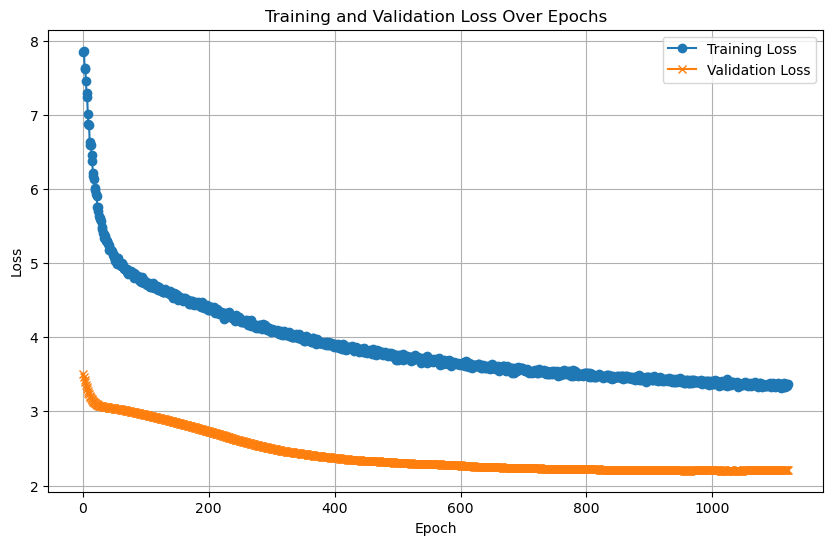

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/11], Loss: 4.8347

Test Loss: 4.9440


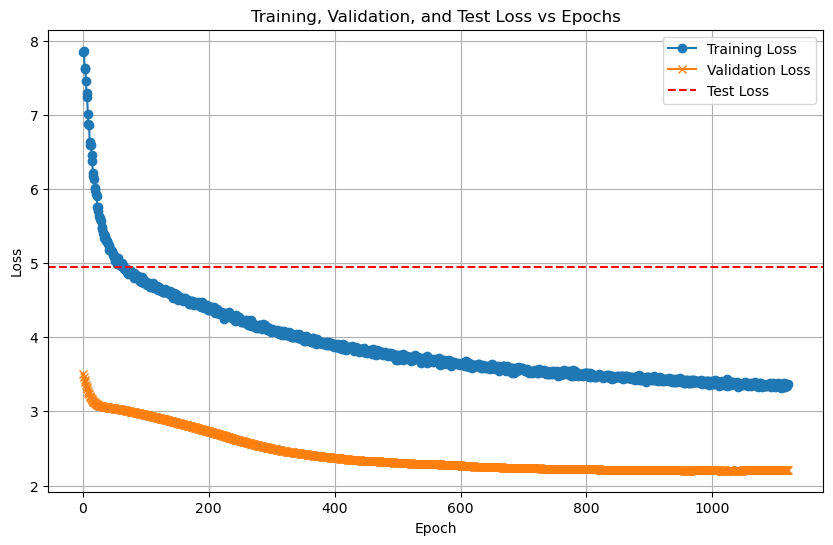

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       1.00      0.80      0.89         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.83      1.00      0.91         5
           9       0.62      1.00      0.77         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.80      0.80      0.80         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7535  |  Val Loss: 2.7078
Validation loss improved from inf to 2.7078.
[Epoch 2/1000] Train Loss: 2.6847  |  Val Loss: 2.6489
Validation loss improved from 2.7078 to 2.6489.
[Epoch 3/1000] Train Loss: 2.6264  |  Val Loss: 2.6035
Validation loss improved from 2.6489 to 2.6035.
[Epoch 4/1000] Train Loss: 2.5815  |  Val Loss: 2.5643
Validation loss improved from 2.6035 to 2.5643.
[Epoch 5/1000] Train Loss: 2.5420  |  Val Loss: 2.5291
Validation loss improved from 2.5643 to 2.5291.
[Epoch 6/1000] Train Loss: 2.5038  |  Val Loss: 2.4957
Validation loss improved from 2.5291 to 2.4957.


[Epoch 7/1000] Train Loss: 2.4685  |  Val Loss: 2.4607
Validation loss improved from 2.4957 to 2.4607.
[Epoch 8/1000] Train Loss: 2.4338  |  Val Loss: 2.4272
Validation loss improved from 2.4607 to 2.4272.


[Epoch 9/1000] Train Loss: 2.3980  |  Val Loss: 2.3923
Validation loss improved from 2.4272 to 2.3923.
[Epoch 10/1000] Train Loss: 2.3574  |  Val Loss: 2.3544
Validation loss improved from 2.3923 to 2.3544.
[Epoch 11/1000] Train Loss: 2.3168  |  Val Loss: 2.3169
Validation loss improved from 2.3544 to 2.3169.


[Epoch 12/1000] Train Loss: 2.2775  |  Val Loss: 2.2818
Validation loss improved from 2.3169 to 2.2818.
[Epoch 13/1000] Train Loss: 2.2420  |  Val Loss: 2.2486
Validation loss improved from 2.2818 to 2.2486.
[Epoch 14/1000] Train Loss: 2.2072  |  Val Loss: 2.2176
Validation loss improved from 2.2486 to 2.2176.
[Epoch 15/1000] Train Loss: 2.1750  |  Val Loss: 2.1867
Validation loss improved from 2.2176 to 2.1867.
[Epoch 16/1000] Train Loss: 2.1415  |  Val Loss: 2.1554
Validation loss improved from 2.1867 to 2.1554.
[Epoch 17/1000] Train Loss: 2.1077  |  Val Loss: 2.1237
Validation loss improved from 2.1554 to 2.1237.


[Epoch 18/1000] Train Loss: 2.0744  |  Val Loss: 2.0916
Validation loss improved from 2.1237 to 2.0916.


[Epoch 19/1000] Train Loss: 2.0406  |  Val Loss: 2.0601
Validation loss improved from 2.0916 to 2.0601.
[Epoch 20/1000] Train Loss: 2.0067  |  Val Loss: 2.0282
Validation loss improved from 2.0601 to 2.0282.
[Epoch 21/1000] Train Loss: 1.9731  |  Val Loss: 1.9958
Validation loss improved from 2.0282 to 1.9958.
[Epoch 22/1000] Train Loss: 1.9383  |  Val Loss: 1.9634
Validation loss improved from 1.9958 to 1.9634.


[Epoch 23/1000] Train Loss: 1.9046  |  Val Loss: 1.9303
Validation loss improved from 1.9634 to 1.9303.
[Epoch 24/1000] Train Loss: 1.8696  |  Val Loss: 1.8976
Validation loss improved from 1.9303 to 1.8976.
[Epoch 25/1000] Train Loss: 1.8352  |  Val Loss: 1.8645
Validation loss improved from 1.8976 to 1.8645.
[Epoch 26/1000] Train Loss: 1.7998  |  Val Loss: 1.8314
Validation loss improved from 1.8645 to 1.8314.
[Epoch 27/1000] Train Loss: 1.7649  |  Val Loss: 1.7978
Validation loss improved from 1.8314 to 1.7978.
[Epoch 28/1000] Train Loss: 1.7292  |  Val Loss: 1.7629
Validation loss improved from 1.7978 to 1.7629.
[Epoch 29/1000] Train Loss: 1.6932  |  Val Loss: 1.7285
Validation loss improved from 1.7629 to 1.7285.


[Epoch 30/1000] Train Loss: 1.6570  |  Val Loss: 1.6950
Validation loss improved from 1.7285 to 1.6950.
[Epoch 31/1000] Train Loss: 1.6222  |  Val Loss: 1.6610
Validation loss improved from 1.6950 to 1.6610.
[Epoch 32/1000] Train Loss: 1.5869  |  Val Loss: 1.6281
Validation loss improved from 1.6610 to 1.6281.
[Epoch 33/1000] Train Loss: 1.5524  |  Val Loss: 1.5960
Validation loss improved from 1.6281 to 1.5960.


[Epoch 34/1000] Train Loss: 1.5185  |  Val Loss: 1.5646
Validation loss improved from 1.5960 to 1.5646.
[Epoch 35/1000] Train Loss: 1.4849  |  Val Loss: 1.5338
Validation loss improved from 1.5646 to 1.5338.
[Epoch 36/1000] Train Loss: 1.4516  |  Val Loss: 1.5025
Validation loss improved from 1.5338 to 1.5025.
[Epoch 37/1000] Train Loss: 1.4190  |  Val Loss: 1.4716
Validation loss improved from 1.5025 to 1.4716.
[Epoch 38/1000] Train Loss: 1.3867  |  Val Loss: 1.4413
Validation loss improved from 1.4716 to 1.4413.
[Epoch 39/1000] Train Loss: 1.3551  |  Val Loss: 1.4117
Validation loss improved from 1.4413 to 1.4117.
[Epoch 40/1000] Train Loss: 1.3240  |  Val Loss: 1.3821
Validation loss improved from 1.4117 to 1.3821.
[Epoch 41/1000] Train Loss: 1.2934  |  Val Loss: 1.3534
Validation loss improved from 1.3821 to 1.3534.


[Epoch 42/1000] Train Loss: 1.2631  |  Val Loss: 1.3247
Validation loss improved from 1.3534 to 1.3247.
[Epoch 43/1000] Train Loss: 1.2325  |  Val Loss: 1.2960
Validation loss improved from 1.3247 to 1.2960.


[Epoch 44/1000] Train Loss: 1.2029  |  Val Loss: 1.2678
Validation loss improved from 1.2960 to 1.2678.
[Epoch 45/1000] Train Loss: 1.1740  |  Val Loss: 1.2400
Validation loss improved from 1.2678 to 1.2400.
[Epoch 46/1000] Train Loss: 1.1443  |  Val Loss: 1.2120
Validation loss improved from 1.2400 to 1.2120.
[Epoch 47/1000] Train Loss: 1.1155  |  Val Loss: 1.1841
Validation loss improved from 1.2120 to 1.1841.
[Epoch 48/1000] Train Loss: 1.0864  |  Val Loss: 1.1570
Validation loss improved from 1.1841 to 1.1570.
[Epoch 49/1000] Train Loss: 1.0578  |  Val Loss: 1.1296
Validation loss improved from 1.1570 to 1.1296.
[Epoch 50/1000] Train Loss: 1.0296  |  Val Loss: 1.1031
Validation loss improved from 1.1296 to 1.1031.
[Epoch 51/1000] Train Loss: 1.0009  |  Val Loss: 1.0767
Validation loss improved from 1.1031 to 1.0767.
[Epoch 52/1000] Train Loss: 0.9730  |  Val Loss: 1.0507
Validation loss improved from 1.0767 to 1.0507.
[Epoch 53/1000] Train Loss: 0.9451  |  Val Loss: 1.0243
Validati

[Epoch 54/1000] Train Loss: 0.9173  |  Val Loss: 0.9987
Validation loss improved from 1.0243 to 0.9987.
[Epoch 55/1000] Train Loss: 0.8904  |  Val Loss: 0.9732
Validation loss improved from 0.9987 to 0.9732.
[Epoch 56/1000] Train Loss: 0.8631  |  Val Loss: 0.9487
Validation loss improved from 0.9732 to 0.9487.
[Epoch 57/1000] Train Loss: 0.8370  |  Val Loss: 0.9240
Validation loss improved from 0.9487 to 0.9240.
[Epoch 58/1000] Train Loss: 0.8104  |  Val Loss: 0.9000
Validation loss improved from 0.9240 to 0.9000.
[Epoch 59/1000] Train Loss: 0.7848  |  Val Loss: 0.8767
Validation loss improved from 0.9000 to 0.8767.
[Epoch 60/1000] Train Loss: 0.7596  |  Val Loss: 0.8544
Validation loss improved from 0.8767 to 0.8544.
[Epoch 61/1000] Train Loss: 0.7347  |  Val Loss: 0.8322
Validation loss improved from 0.8544 to 0.8322.
[Epoch 62/1000] Train Loss: 0.7112  |  Val Loss: 0.8100
Validation loss improved from 0.8322 to 0.8100.
[Epoch 63/1000] Train Loss: 0.6870  |  Val Loss: 0.7890
Validati

[Epoch 65/1000] Train Loss: 0.6414  |  Val Loss: 0.7471
Validation loss improved from 0.7678 to 0.7471.
[Epoch 66/1000] Train Loss: 0.6193  |  Val Loss: 0.7276
Validation loss improved from 0.7471 to 0.7276.
[Epoch 67/1000] Train Loss: 0.5978  |  Val Loss: 0.7078
Validation loss improved from 0.7276 to 0.7078.
[Epoch 68/1000] Train Loss: 0.5769  |  Val Loss: 0.6885
Validation loss improved from 0.7078 to 0.6885.
[Epoch 69/1000] Train Loss: 0.5567  |  Val Loss: 0.6702
Validation loss improved from 0.6885 to 0.6702.
[Epoch 70/1000] Train Loss: 0.5367  |  Val Loss: 0.6533
Validation loss improved from 0.6702 to 0.6533.
[Epoch 71/1000] Train Loss: 0.5179  |  Val Loss: 0.6368
Validation loss improved from 0.6533 to 0.6368.
[Epoch 72/1000] Train Loss: 0.4996  |  Val Loss: 0.6206
Validation loss improved from 0.6368 to 0.6206.
[Epoch 73/1000] Train Loss: 0.4819  |  Val Loss: 0.6042
Validation loss improved from 0.6206 to 0.6042.
[Epoch 74/1000] Train Loss: 0.4650  |  Val Loss: 0.5886
Validati

[Epoch 77/1000] Train Loss: 0.4179  |  Val Loss: 0.5475
Validation loss improved from 0.5607 to 0.5475.
[Epoch 78/1000] Train Loss: 0.4032  |  Val Loss: 0.5353
Validation loss improved from 0.5475 to 0.5353.
[Epoch 79/1000] Train Loss: 0.3892  |  Val Loss: 0.5226
Validation loss improved from 0.5353 to 0.5226.
[Epoch 80/1000] Train Loss: 0.3762  |  Val Loss: 0.5108
Validation loss improved from 0.5226 to 0.5108.
[Epoch 81/1000] Train Loss: 0.3631  |  Val Loss: 0.4986
Validation loss improved from 0.5108 to 0.4986.
[Epoch 82/1000] Train Loss: 0.3504  |  Val Loss: 0.4890
Validation loss improved from 0.4986 to 0.4890.
[Epoch 83/1000] Train Loss: 0.3388  |  Val Loss: 0.4782
Validation loss improved from 0.4890 to 0.4782.
[Epoch 84/1000] Train Loss: 0.3274  |  Val Loss: 0.4671
Validation loss improved from 0.4782 to 0.4671.
[Epoch 85/1000] Train Loss: 0.3163  |  Val Loss: 0.4578
Validation loss improved from 0.4671 to 0.4578.
[Epoch 86/1000] Train Loss: 0.3058  |  Val Loss: 0.4479
Validati

[Epoch 88/1000] Train Loss: 0.2860  |  Val Loss: 0.4310
Validation loss improved from 0.4399 to 0.4310.
[Epoch 89/1000] Train Loss: 0.2767  |  Val Loss: 0.4221
Validation loss improved from 0.4310 to 0.4221.
[Epoch 90/1000] Train Loss: 0.2676  |  Val Loss: 0.4138
Validation loss improved from 0.4221 to 0.4138.
[Epoch 91/1000] Train Loss: 0.2591  |  Val Loss: 0.4055
Validation loss improved from 0.4138 to 0.4055.
[Epoch 92/1000] Train Loss: 0.2507  |  Val Loss: 0.3984
Validation loss improved from 0.4055 to 0.3984.
[Epoch 93/1000] Train Loss: 0.2428  |  Val Loss: 0.3920
Validation loss improved from 0.3984 to 0.3920.
[Epoch 94/1000] Train Loss: 0.2351  |  Val Loss: 0.3857
Validation loss improved from 0.3920 to 0.3857.
[Epoch 95/1000] Train Loss: 0.2276  |  Val Loss: 0.3782
Validation loss improved from 0.3857 to 0.3782.
[Epoch 96/1000] Train Loss: 0.2208  |  Val Loss: 0.3716
Validation loss improved from 0.3782 to 0.3716.
[Epoch 97/1000] Train Loss: 0.2140  |  Val Loss: 0.3671
Validati

[Epoch 100/1000] Train Loss: 0.1950  |  Val Loss: 0.3506
Validation loss improved from 0.3560 to 0.3506.
[Epoch 101/1000] Train Loss: 0.1891  |  Val Loss: 0.3461
Validation loss improved from 0.3506 to 0.3461.
[Epoch 102/1000] Train Loss: 0.1835  |  Val Loss: 0.3415
Validation loss improved from 0.3461 to 0.3415.
[Epoch 103/1000] Train Loss: 0.1781  |  Val Loss: 0.3363
Validation loss improved from 0.3415 to 0.3363.
[Epoch 104/1000] Train Loss: 0.1729  |  Val Loss: 0.3324
Validation loss improved from 0.3363 to 0.3324.
[Epoch 105/1000] Train Loss: 0.1679  |  Val Loss: 0.3289
Validation loss improved from 0.3324 to 0.3289.
[Epoch 106/1000] Train Loss: 0.1632  |  Val Loss: 0.3263
Validation loss improved from 0.3289 to 0.3263.
[Epoch 107/1000] Train Loss: 0.1586  |  Val Loss: 0.3223
Validation loss improved from 0.3263 to 0.3223.
[Epoch 108/1000] Train Loss: 0.1540  |  Val Loss: 0.3180
Validation loss improved from 0.3223 to 0.3180.
[Epoch 109/1000] Train Loss: 0.1496  |  Val Loss: 0.313

[Epoch 111/1000] Train Loss: 0.1416  |  Val Loss: 0.3070
Validation loss improved from 0.3094 to 0.3070.
[Epoch 112/1000] Train Loss: 0.1377  |  Val Loss: 0.3044
Validation loss improved from 0.3070 to 0.3044.
[Epoch 113/1000] Train Loss: 0.1341  |  Val Loss: 0.3025
Validation loss improved from 0.3044 to 0.3025.
[Epoch 114/1000] Train Loss: 0.1305  |  Val Loss: 0.3000
Validation loss improved from 0.3025 to 0.3000.
[Epoch 115/1000] Train Loss: 0.1272  |  Val Loss: 0.2974
Validation loss improved from 0.3000 to 0.2974.
[Epoch 116/1000] Train Loss: 0.1237  |  Val Loss: 0.2945
Validation loss improved from 0.2974 to 0.2945.
[Epoch 117/1000] Train Loss: 0.1205  |  Val Loss: 0.2910
Validation loss improved from 0.2945 to 0.2910.
[Epoch 118/1000] Train Loss: 0.1174  |  Val Loss: 0.2878
Validation loss improved from 0.2910 to 0.2878.
[Epoch 119/1000] Train Loss: 0.1145  |  Val Loss: 0.2870
Validation loss improved from 0.2878 to 0.2870.
[Epoch 120/1000] Train Loss: 0.1115  |  Val Loss: 0.285

[Epoch 123/1000] Train Loss: 0.1034  |  Val Loss: 0.2796
Validation loss improved from 0.2812 to 0.2796.
[Epoch 124/1000] Train Loss: 0.1010  |  Val Loss: 0.2776
Validation loss improved from 0.2796 to 0.2776.
[Epoch 125/1000] Train Loss: 0.0986  |  Val Loss: 0.2768
Validation loss improved from 0.2776 to 0.2768.
[Epoch 126/1000] Train Loss: 0.0963  |  Val Loss: 0.2745
Validation loss improved from 0.2768 to 0.2745.
[Epoch 127/1000] Train Loss: 0.0940  |  Val Loss: 0.2726
Validation loss improved from 0.2745 to 0.2726.
[Epoch 128/1000] Train Loss: 0.0918  |  Val Loss: 0.2722
Validation loss improved from 0.2726 to 0.2722.
[Epoch 129/1000] Train Loss: 0.0897  |  Val Loss: 0.2707
Validation loss improved from 0.2722 to 0.2707.
[Epoch 130/1000] Train Loss: 0.0877  |  Val Loss: 0.2675
Validation loss improved from 0.2707 to 0.2675.
[Epoch 131/1000] Train Loss: 0.0857  |  Val Loss: 0.2671
Validation loss improved from 0.2675 to 0.2671.
[Epoch 132/1000] Train Loss: 0.0839  |  Val Loss: 0.267

[Epoch 135/1000] Train Loss: 0.0784  |  Val Loss: 0.2618
Validation loss improved from 0.2641 to 0.2618.
[Epoch 136/1000] Train Loss: 0.0768  |  Val Loss: 0.2619
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 0.0752  |  Val Loss: 0.2616
Validation loss improved from 0.2618 to 0.2616.
[Epoch 138/1000] Train Loss: 0.0735  |  Val Loss: 0.2614
Validation loss improved from 0.2616 to 0.2614.
[Epoch 139/1000] Train Loss: 0.0720  |  Val Loss: 0.2603
Validation loss improved from 0.2614 to 0.2603.
[Epoch 140/1000] Train Loss: 0.0706  |  Val Loss: 0.2590
Validation loss improved from 0.2603 to 0.2590.
[Epoch 141/1000] Train Loss: 0.0691  |  Val Loss: 0.2592
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 0.0677  |  Val Loss: 0.2588
Validation loss improved from 0.2590 to 0.2588.
[Epoch 143/1000] Train Loss: 0.0663  |  Val Loss: 0.2569
Validation loss improved from 0.2588 to 0.2569.
[Epoch 144/1000] Train Loss: 0.0650  |  Val

[Epoch 146/1000] Train Loss: 0.0626  |  Val Loss: 0.2561
Validation loss improved from 0.2569 to 0.2561.
[Epoch 147/1000] Train Loss: 0.0614  |  Val Loss: 0.2564
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 148/1000] Train Loss: 0.0602  |  Val Loss: 0.2571
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 149/1000] Train Loss: 0.0591  |  Val Loss: 0.2556
Validation loss improved from 0.2561 to 0.2556.
[Epoch 150/1000] Train Loss: 0.0579  |  Val Loss: 0.2559
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 0.0569  |  Val Loss: 0.2552
Validation loss improved from 0.2556 to 0.2552.
[Epoch 152/1000] Train Loss: 0.0558  |  Val Loss: 0.2548
Validation loss improved from 0.2552 to 0.2548.
[Epoch 153/1000] Train Loss: 0.0548  |  Val Loss: 0.2551
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 0.0538  |  Val Loss: 0.2546
Validation loss improved from 0.2548 to 0.2546.
[Epoch 155/1000] Train Loss: 0.

[Epoch 158/1000] Train Loss: 0.0501  |  Val Loss: 0.2530
Validation loss improved from 0.2531 to 0.2530.
[Epoch 159/1000] Train Loss: 0.0493  |  Val Loss: 0.2546
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 0.0484  |  Val Loss: 0.2536
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 0.0476  |  Val Loss: 0.2540
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 162/1000] Train Loss: 0.0468  |  Val Loss: 0.2530
Validation loss improved from 0.2530 to 0.2530.
[Epoch 163/1000] Train Loss: 0.0460  |  Val Loss: 0.2528
Validation loss improved from 0.2530 to 0.2528.
[Epoch 164/1000] Train Loss: 0.0452  |  Val Loss: 0.2520
Validation loss improved from 0.2528 to 0.2520.
[Epoch 165/1000] Train Loss: 0.0445  |  Val Loss: 0.2516
Validation loss improved from 0.2520 to 0.2516.
[Epoch 166/1000] Train Loss: 0.0438  |  Val Loss: 0.2522
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 0.

[Epoch 169/1000] Train Loss: 0.0417  |  Val Loss: 0.2524
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 170/1000] Train Loss: 0.0410  |  Val Loss: 0.2522
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 171/1000] Train Loss: 0.0404  |  Val Loss: 0.2518
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 172/1000] Train Loss: 0.0398  |  Val Loss: 0.2522
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 173/1000] Train Loss: 0.0392  |  Val Loss: 0.2544
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 174/1000] Train Loss: 0.0385  |  Val Loss: 0.2531
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 175/1000] Train Loss: 0.0379  |  Val Loss: 0.2531
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 176/1000] Train Loss: 0.0374  |  Val Loss: 0.2530
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 177/1000] Train Loss: 0.0368  |  Val Loss: 0.2534
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 181/1000] Train Loss: 0.0346  |  Val Loss: 0.2542
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 182/1000] Train Loss: 0.0342  |  Val Loss: 0.2533
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 183/1000] Train Loss: 0.0337  |  Val Loss: 0.2568
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 184/1000] Train Loss: 0.0332  |  Val Loss: 0.2554
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 185/1000] Train Loss: 0.0327  |  Val Loss: 0.2550
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 186/1000] Train Loss: 0.0322  |  Val Loss: 0.2551
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 187/1000] Train Loss: 0.0317  |  Val Loss: 0.2554
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 188/1000] Train Loss: 0.0313  |  Val Loss: 0.2565
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 189/1000] Train Loss: 0.0309  |  Val Loss: 0.2554
!! Validation loss did NOT improve !! Patience:

[Epoch 192/1000] Train Loss: 0.0296  |  Val Loss: 0.2566
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 193/1000] Train Loss: 0.0292  |  Val Loss: 0.2568
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 194/1000] Train Loss: 0.0288  |  Val Loss: 0.2578
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 195/1000] Train Loss: 0.0284  |  Val Loss: 0.2585
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 196/1000] Train Loss: 0.0280  |  Val Loss: 0.2588
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 197/1000] Train Loss: 0.0277  |  Val Loss: 0.2595
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 198/1000] Train Loss: 0.0273  |  Val Loss: 0.2590
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 199/1000] Train Loss: 0.0270  |  Val Loss: 0.2602
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 200/1000] Train Loss: 0.0266  |  Val Loss: 0.2587
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 0.0255  |  Val Loss: 0.2615
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 204/1000] Train Loss: 0.0252  |  Val Loss: 0.2612
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 205/1000] Train Loss: 0.0249  |  Val Loss: 0.2607
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 206/1000] Train Loss: 0.0245  |  Val Loss: 0.2625
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 207/1000] Train Loss: 0.0242  |  Val Loss: 0.2632
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 208/1000] Train Loss: 0.0239  |  Val Loss: 0.2617
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 209/1000] Train Loss: 0.0236  |  Val Loss: 0.2626
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 210/1000] Train Loss: 0.0233  |  Val Loss: 0.2620
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 211/1000] Train Loss: 0.0230  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience:

[Epoch 214/1000] Train Loss: 0.0222  |  Val Loss: 0.2644
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 215/1000] Train Loss: 0.0219  |  Val Loss: 0.2643
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 216/1000] Train Loss: 0.0217  |  Val Loss: 0.2637
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 217/1000] Train Loss: 0.0214  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 218/1000] Train Loss: 0.0211  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 219/1000] Train Loss: 0.0209  |  Val Loss: 0.2639
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 220/1000] Train Loss: 0.0206  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 221/1000] Train Loss: 0.0203  |  Val Loss: 0.2648
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 222/1000] Train Loss: 0.0201  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience:

[Epoch 225/1000] Train Loss: 0.0194  |  Val Loss: 0.2675
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 226/1000] Train Loss: 0.0192  |  Val Loss: 0.2688
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 227/1000] Train Loss: 0.0189  |  Val Loss: 0.2704
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 228/1000] Train Loss: 0.0188  |  Val Loss: 0.2680
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 229/1000] Train Loss: 0.0185  |  Val Loss: 0.2679
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 230/1000] Train Loss: 0.0183  |  Val Loss: 0.2704
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 231/1000] Train Loss: 0.0181  |  Val Loss: 0.2712
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 232/1000] Train Loss: 0.0179  |  Val Loss: 0.2698
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 233/1000] Train Loss: 0.0177  |  Val Loss: 0.2695
!! Validation loss did NOT improve !! Patience:

[Epoch 236/1000] Train Loss: 0.0171  |  Val Loss: 0.2726
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 237/1000] Train Loss: 0.0168  |  Val Loss: 0.2720
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 238/1000] Train Loss: 0.0167  |  Val Loss: 0.2725
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 239/1000] Train Loss: 0.0165  |  Val Loss: 0.2737
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 240/1000] Train Loss: 0.0163  |  Val Loss: 0.2742
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 241/1000] Train Loss: 0.0161  |  Val Loss: 0.2743
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 242/1000] Train Loss: 0.0159  |  Val Loss: 0.2736
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 243/1000] Train Loss: 0.0158  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 244/1000] Train Loss: 0.0156  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience:

[Epoch 248/1000] Train Loss: 0.0149  |  Val Loss: 0.2754
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 249/1000] Train Loss: 0.0148  |  Val Loss: 0.2766
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 250/1000] Train Loss: 0.0146  |  Val Loss: 0.2768
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 251/1000] Train Loss: 0.0144  |  Val Loss: 0.2769
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 252/1000] Train Loss: 0.0143  |  Val Loss: 0.2773
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 253/1000] Train Loss: 0.0141  |  Val Loss: 0.2774
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 254/1000] Train Loss: 0.0140  |  Val Loss: 0.2773
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 255/1000] Train Loss: 0.0138  |  Val Loss: 0.2766
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 256/1000] Train Loss: 0.0137  |  Val Loss: 0.2783
!! Validation loss did NOT improve !! Patience:

[Epoch 259/1000] Train Loss: 0.0132  |  Val Loss: 0.2786
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 260/1000] Train Loss: 0.0131  |  Val Loss: 0.2782
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 261/1000] Train Loss: 0.0130  |  Val Loss: 0.2782
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 262/1000] Train Loss: 0.0128  |  Val Loss: 0.2796
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 263/1000] Train Loss: 0.0127  |  Val Loss: 0.2799
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 264/1000] Train Loss: 0.0126  |  Val Loss: 0.2798
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 265/1000] Train Loss: 0.0125  |  Val Loss: 0.2818
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 265 !!
No improvement for 100 epochs.


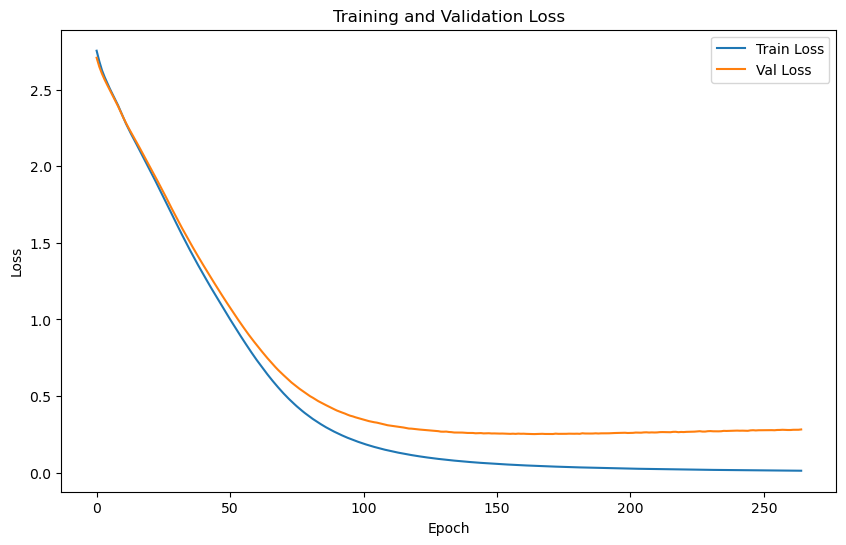

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.3714 | Test Accuracy: 88.50%


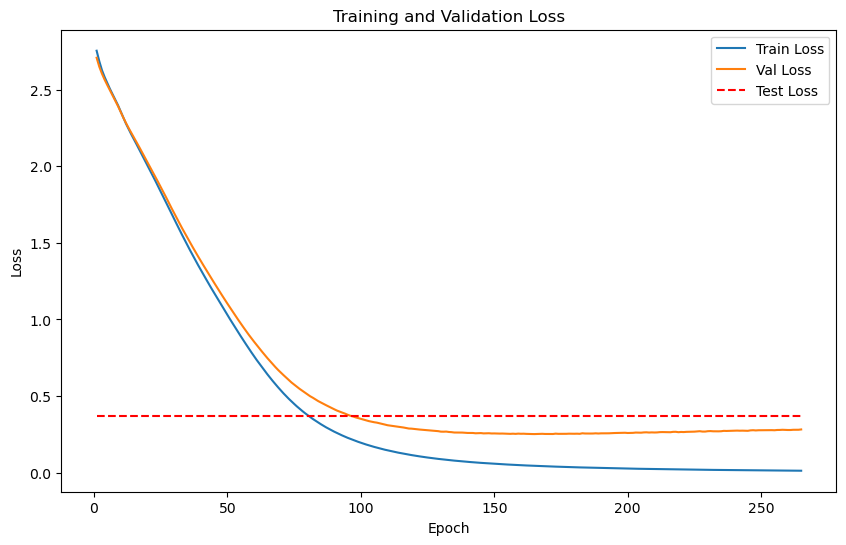

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4803
    Batch [2/2], Train Loss: 0.4817
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.0804
Epoch [1/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.2783

Validation loss improved from inf to 0.2783. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4786


    Batch [2/2], Train Loss: 0.4814
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.0832
Epoch [2/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.2798

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4756
    Batch [2/2], Train Loss: 0.4746
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.0853
Epoch [3/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.2807

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4744


    Batch [2/2], Train Loss: 0.4764
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.0899
Epoch [4/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.2833

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4748
    Batch [2/2], Train Loss: 0.4752
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.0931
Epoch [5/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.2850

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4707


    Batch [2/2], Train Loss: 0.4733
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.0917
Epoch [6/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.2841

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4698
    Batch [2/2], Train Loss: 0.4705
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.0922
Epoch [7/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4719


    Batch [2/2], Train Loss: 0.4674
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.0903
Epoch [8/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.2830

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4653
    Batch [2/2], Train Loss: 0.4668
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.0889
Epoch [9/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.2829

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4669


    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.0841
Epoch [10/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.2803

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4661


    Batch [2/2], Train Loss: 0.4596
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.0748
Epoch [11/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.2741

Validation loss improved from 0.2783 to 0.2741. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4614
    Batch [2/2], Train Loss: 0.4612
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.0675
Epoch [12/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.2686

Validation loss improved from 0.2741 to 0.2686. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4620


    Batch [2/2], Train Loss: 0.4624
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.0636
Epoch [13/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.2644

Validation loss improved from 0.2686 to 0.2644. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4558
    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.0604
Epoch [14/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.2609

Validation loss improved from 0.2644 to 0.2609. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4559


    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.0574
Epoch [15/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.2586

Validation loss improved from 0.2609 to 0.2586. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4593
    Batch [2/2], Train Loss: 0.4575
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.0551
Epoch [16/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.2561

Validation loss improved from 0.2586 to 0.2561. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4608


    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.0537
Epoch [17/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.2536

Validation loss improved from 0.2561 to 0.2536. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.0531
Epoch [18/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.2513

Validation loss improved from 0.2536 to 0.2513. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4566


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.0527
Epoch [19/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.2494

Validation loss improved from 0.2513 to 0.2494. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4562
    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.0524
Epoch [20/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.2478

Validation loss improved from 0.2494 to 0.2478. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.0523
Epoch [21/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.2461

Validation loss improved from 0.2478 to 0.2461. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4471
    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.4372
    Batch [2/2], Val Loss: 0.0524
Epoch [22/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.2448

Validation loss improved from 0.2461 to 0.2448. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4477


    Batch [2/2], Train Loss: 0.4486
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.0524
Epoch [23/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.2437

Validation loss improved from 0.2448 to 0.2437. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4452
    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.0524
Epoch [24/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.2426

Validation loss improved from 0.2437 to 0.2426. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4466


    Batch [2/2], Train Loss: 0.4432
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.0526
Epoch [25/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.2415

Validation loss improved from 0.2426 to 0.2415. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4440
    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.0532
Epoch [26/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.2405

Validation loss improved from 0.2415 to 0.2405. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.4431


    Batch [2/2], Train Loss: 0.4414
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.0535
Epoch [27/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.2395

Validation loss improved from 0.2405 to 0.2395. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4425
    Batch [2/2], Train Loss: 0.4388
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0536
Epoch [28/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.2386

Validation loss improved from 0.2395 to 0.2386. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4425


    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0539
Epoch [29/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2381

Validation loss improved from 0.2386 to 0.2381. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4399
    Batch [2/2], Train Loss: 0.4382
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.0543
Epoch [30/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2377

Validation loss improved from 0.2381 to 0.2377. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4368


    Batch [2/2], Train Loss: 0.4344
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.0547
Epoch [31/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4327
    Batch [2/2], Train Loss: 0.4377
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.0550
Epoch [32/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.4357


    Batch [2/2], Train Loss: 0.4373
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0554
Epoch [33/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4307
    Batch [2/2], Train Loss: 0.4362
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.0555
Epoch [34/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2373

Validation loss improved from 0.2376 to 0.2373. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.4304


    Batch [2/2], Train Loss: 0.4336
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.0552
Epoch [35/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2366

Validation loss improved from 0.2373 to 0.2366. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4297
    Batch [2/2], Train Loss: 0.4299
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0551
Epoch [36/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2360

Validation loss improved from 0.2366 to 0.2360. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4298


    Batch [2/2], Train Loss: 0.4242
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0555
Epoch [37/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2355

Validation loss improved from 0.2360 to 0.2355. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4324
    Batch [2/2], Train Loss: 0.4332
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0564
Epoch [38/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4261
    Batch [2/2], Train Loss: 0.4314
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0569
Epoch [39/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4264


    Batch [2/2], Train Loss: 0.4235
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0568
Epoch [40/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4253
    Batch [2/2], Train Loss: 0.4195
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.0569
Epoch [41/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2352

Validation loss improved from 0.2355 to 0.2352. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.4175


    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.0573
Epoch [42/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2344

Validation loss improved from 0.2352 to 0.2344. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4175
    Batch [2/2], Train Loss: 0.4199
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.0580
Epoch [43/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2338

Validation loss improved from 0.2344 to 0.2338. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.4178


    Batch [2/2], Train Loss: 0.4213
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.0582
Epoch [44/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2330

Validation loss improved from 0.2338 to 0.2330. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4171
    Batch [2/2], Train Loss: 0.4177
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.0579
Epoch [45/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2320

Validation loss improved from 0.2330 to 0.2320. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.4256


    Batch [2/2], Train Loss: 0.4205
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.0570
Epoch [46/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2305

Validation loss improved from 0.2320 to 0.2305. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4238
    Batch [2/2], Train Loss: 0.4133
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.0554
Epoch [47/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2288

Validation loss improved from 0.2305 to 0.2288. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.4188


    Batch [2/2], Train Loss: 0.4129
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.0544
Epoch [48/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2279

Validation loss improved from 0.2288 to 0.2279. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4164
    Batch [2/2], Train Loss: 0.4156
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.0535
Epoch [49/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2274

Validation loss improved from 0.2279 to 0.2274. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.4127


    Batch [2/2], Train Loss: 0.4135
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.0529
Epoch [50/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2267

Validation loss improved from 0.2274 to 0.2267. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.4074
    Batch [2/2], Train Loss: 0.4112
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0526
Epoch [51/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2262

Validation loss improved from 0.2267 to 0.2262. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.4148


    Batch [2/2], Train Loss: 0.4111
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.0519
Epoch [52/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2251

Validation loss improved from 0.2262 to 0.2251. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.4054
    Batch [2/2], Train Loss: 0.4091
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.0517
Epoch [53/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2243

Validation loss improved from 0.2251 to 0.2243. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.4076


    Batch [2/2], Train Loss: 0.4055
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0516
Epoch [54/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2232

Validation loss improved from 0.2243 to 0.2232. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.4137
    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.3918
    Batch [2/2], Val Loss: 0.0512
Epoch [55/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2215

Validation loss improved from 0.2232 to 0.2215. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.4079


    Batch [2/2], Train Loss: 0.4015
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.0505
Epoch [56/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2202

Validation loss improved from 0.2215 to 0.2202. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4040
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.0497
Epoch [57/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2188

Validation loss improved from 0.2202 to 0.2188. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.4131


    Batch [2/2], Train Loss: 0.4041
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0492
Epoch [58/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2171

Validation loss improved from 0.2188 to 0.2171. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.4049
    Batch [2/2], Train Loss: 0.4048
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.0490
Epoch [59/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2160

Validation loss improved from 0.2171 to 0.2160. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3996


    Batch [2/2], Train Loss: 0.4027
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.0490
Epoch [60/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2153

Validation loss improved from 0.2160 to 0.2153. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4025
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.0492
Epoch [61/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2152

Validation loss improved from 0.2153 to 0.2152. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.4040


    Batch [2/2], Train Loss: 0.4044
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.0495
Epoch [62/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.4021
    Batch [2/2], Train Loss: 0.4014
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.0498
Epoch [63/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.3987


    Batch [2/2], Train Loss: 0.3997
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.0502
Epoch [64/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3933
    Batch [2/2], Train Loss: 0.4001
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0500
Epoch [65/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2149

Validation loss improved from 0.2152 to 0.2149. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3974


    Batch [2/2], Train Loss: 0.4032
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.0496
Epoch [66/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2141

Validation loss improved from 0.2149 to 0.2141. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3957
    Batch [2/2], Train Loss: 0.4009
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.0493
Epoch [67/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2130

Validation loss improved from 0.2141 to 0.2130. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3961


    Batch [2/2], Train Loss: 0.3943
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.0488
Epoch [68/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2122

Validation loss improved from 0.2130 to 0.2122. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3966
    Batch [2/2], Train Loss: 0.3900
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.0488
Epoch [69/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3940


    Batch [2/2], Train Loss: 0.3968
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0490
Epoch [70/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3983
    Batch [2/2], Train Loss: 0.3944
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.0490
Epoch [71/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3892


    Batch [2/2], Train Loss: 0.3880
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.0489
Epoch [72/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3936
    Batch [2/2], Train Loss: 0.3903
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.0487
Epoch [73/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3952


    Batch [2/2], Train Loss: 0.3877
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.0488
Epoch [74/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3889


    Batch [2/2], Train Loss: 0.3953
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.0488
Epoch [75/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3893
    Batch [2/2], Train Loss: 0.3861
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.0492
Epoch [76/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3851
    Batch [2/2], Train Loss: 0.3861
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.0494
Epoch [77/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2142

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3880
    Batch [2/2], Train Loss: 0.3914
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.0496
Epoch [78/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2140

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3818


    Batch [2/2], Train Loss: 0.3865
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.0494
Epoch [79/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3848
    Batch [2/2], Train Loss: 0.3794
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.0488
Epoch [80/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2120

Validation loss improved from 0.2122 to 0.2120. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3854


    Batch [2/2], Train Loss: 0.3879
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.0482
Epoch [81/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2107

Validation loss improved from 0.2120 to 0.2107. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3790


    Batch [2/2], Train Loss: 0.3819
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3718
    Batch [2/2], Val Loss: 0.0477
Epoch [82/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2097

Validation loss improved from 0.2107 to 0.2097. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3797
    Batch [2/2], Train Loss: 0.3818
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.3716
    Batch [2/2], Val Loss: 0.0472
Epoch [83/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2094

Validation loss improved from 0.2097 to 0.2094. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3813
    Batch [2/2], Train Loss: 0.3871
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.0471
Epoch [84/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2085

Validation loss improved from 0.2094 to 0.2085. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3758


    Batch [2/2], Train Loss: 0.3779
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.0472
Epoch [85/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2078

Validation loss improved from 0.2085 to 0.2078. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3817
    Batch [2/2], Train Loss: 0.3791
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.0478
Epoch [86/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2074

Validation loss improved from 0.2078 to 0.2074. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3790


    Batch [2/2], Train Loss: 0.3788
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.0484
Epoch [87/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2067

Validation loss improved from 0.2074 to 0.2067. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3789
    Batch [2/2], Train Loss: 0.3805
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0484
Epoch [88/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2064

Validation loss improved from 0.2067 to 0.2064. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3787


    Batch [2/2], Train Loss: 0.3762
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0486
Epoch [89/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2056

Validation loss improved from 0.2064 to 0.2056. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3730


    Batch [2/2], Train Loss: 0.3767
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0479
Epoch [90/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2047

Validation loss improved from 0.2056 to 0.2047. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3750
    Batch [2/2], Train Loss: 0.3745
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.0473
Epoch [91/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2034

Validation loss improved from 0.2047 to 0.2034. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3702


    Batch [2/2], Train Loss: 0.3682
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.0462
Epoch [92/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2025

Validation loss improved from 0.2034 to 0.2025. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3697
    Batch [2/2], Train Loss: 0.3667
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.0457
Epoch [93/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2023

Validation loss improved from 0.2025 to 0.2023. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3664


    Batch [2/2], Train Loss: 0.3709
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3587
    Batch [2/2], Val Loss: 0.0455
Epoch [94/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2021

Validation loss improved from 0.2023 to 0.2021. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3704
    Batch [2/2], Train Loss: 0.3714
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.0451
Epoch [95/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2021

Validation loss improved from 0.2021 to 0.2021. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3613


    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3587
    Batch [2/2], Val Loss: 0.0450
Epoch [96/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2019

Validation loss improved from 0.2021 to 0.2019. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3650
    Batch [2/2], Train Loss: 0.3622
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.0450
Epoch [97/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2020

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3683


    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3599
    Batch [2/2], Val Loss: 0.0452
Epoch [98/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2026

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3658
    Batch [2/2], Train Loss: 0.3612
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.3600
    Batch [2/2], Val Loss: 0.0455
Epoch [99/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.3693
    Batch [2/2], Train Loss: 0.3644
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.0453
Epoch [100/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2020

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3622


    Batch [2/2], Train Loss: 0.3641
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3566
    Batch [2/2], Val Loss: 0.0447
Epoch [101/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2007

Validation loss improved from 0.2019 to 0.2007. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3686
    Batch [2/2], Train Loss: 0.3579
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.3528
    Batch [2/2], Val Loss: 0.0442
Epoch [102/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.1985

Validation loss improved from 0.2007 to 0.1985. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3607


    Batch [2/2], Train Loss: 0.3621
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.0438
Epoch [103/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.1974

Validation loss improved from 0.1985 to 0.1974. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3625
    Batch [2/2], Train Loss: 0.3569
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.0439
Epoch [104/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.1967

Validation loss improved from 0.1974 to 0.1967. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3565


    Batch [2/2], Train Loss: 0.3573
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3492
    Batch [2/2], Val Loss: 0.0440
Epoch [105/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.1966

Validation loss improved from 0.1967 to 0.1966. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3564
    Batch [2/2], Train Loss: 0.3609
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.3498
    Batch [2/2], Val Loss: 0.0431
Epoch [106/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.1964

Validation loss improved from 0.1966 to 0.1964. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3603


    Batch [2/2], Train Loss: 0.3655
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3503
    Batch [2/2], Val Loss: 0.0426
Epoch [107/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.1965

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3577
    Batch [2/2], Train Loss: 0.3634
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.0424
Epoch [108/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.1972

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.3522


    Batch [2/2], Train Loss: 0.3599
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3535
    Batch [2/2], Val Loss: 0.0426
Epoch [109/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3531
    Batch [2/2], Train Loss: 0.3546
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.0430
Epoch [110/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.1990

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3518
    Batch [2/2], Train Loss: 0.3475
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.0433
Epoch [111/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.1994

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3546


    Batch [2/2], Train Loss: 0.3532
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.0431
Epoch [112/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3515
    Batch [2/2], Train Loss: 0.3488
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.3496
    Batch [2/2], Val Loss: 0.0437
Epoch [113/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.1967

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3582


    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3454
    Batch [2/2], Val Loss: 0.0438
Epoch [114/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.1946

Validation loss improved from 0.1964 to 0.1946. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3544
    Batch [2/2], Train Loss: 0.3490
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.3399
    Batch [2/2], Val Loss: 0.0433
Epoch [115/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.1916

Validation loss improved from 0.1946 to 0.1916. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.3542


    Batch [2/2], Train Loss: 0.3558
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.0433
Epoch [116/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.1903

Validation loss improved from 0.1916 to 0.1903. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3477
    Batch [2/2], Train Loss: 0.3404
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.0435
Epoch [117/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.3512


    Batch [2/2], Train Loss: 0.3519
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.0437
Epoch [118/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3539
    Batch [2/2], Train Loss: 0.3460
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.0444
Epoch [119/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.3458


    Batch [2/2], Train Loss: 0.3475
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.3421
    Batch [2/2], Val Loss: 0.0447
Epoch [120/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.1934

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3425
    Batch [2/2], Train Loss: 0.3389
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.0449
Epoch [121/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.1949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3401
    Batch [2/2], Train Loss: 0.3333
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.0447
Epoch [122/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.1961

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.3412


    Batch [2/2], Train Loss: 0.3458
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.0440
Epoch [123/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.1959

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3412
    Batch [2/2], Train Loss: 0.3481
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.0437
Epoch [124/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.1956

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.3424


    Batch [2/2], Train Loss: 0.3448
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.0434
Epoch [125/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.1949

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3378
    Batch [2/2], Train Loss: 0.3401
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.0428
Epoch [126/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.1935

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3367


    Batch [2/2], Train Loss: 0.3403
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.0418
Epoch [127/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3347
    Batch [2/2], Train Loss: 0.3402
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.0408
Epoch [128/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.3397


    Batch [2/2], Train Loss: 0.3348
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.0402
Epoch [129/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3393
    Batch [2/2], Train Loss: 0.3299
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.0399
Epoch [130/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.1891

Validation loss improved from 0.1903 to 0.1891. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3323


    Batch [2/2], Train Loss: 0.3354
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.3367
    Batch [2/2], Val Loss: 0.0399
Epoch [131/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.1883

Validation loss improved from 0.1891 to 0.1883. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3355
    Batch [2/2], Train Loss: 0.3356
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.0404
Epoch [132/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.1873

Validation loss improved from 0.1883 to 0.1873. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.3360


    Batch [2/2], Train Loss: 0.3328
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.0408
Epoch [133/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.1878

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3308
    Batch [2/2], Train Loss: 0.3339
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.3346
    Batch [2/2], Val Loss: 0.0405
Epoch [134/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.1876

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.3280


    Batch [2/2], Train Loss: 0.3342
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.0401
Epoch [135/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.1871

Validation loss improved from 0.1873 to 0.1871. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3317
    Batch [2/2], Train Loss: 0.3344
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.0398
Epoch [136/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.1864

Validation loss improved from 0.1871 to 0.1864. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.3335


    Batch [2/2], Train Loss: 0.3298
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3306
    Batch [2/2], Val Loss: 0.0395
Epoch [137/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.1851

Validation loss improved from 0.1864 to 0.1851. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3317


    Batch [2/2], Train Loss: 0.3367
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3305
    Batch [2/2], Val Loss: 0.0395
Epoch [138/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.1850

Validation loss improved from 0.1851 to 0.1850. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3327


    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.0400
Epoch [139/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3274
    Batch [2/2], Train Loss: 0.3289
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.0406
Epoch [140/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3317
    Batch [2/2], Train Loss: 0.3289
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.3369
    Batch [2/2], Val Loss: 0.0409
Epoch [141/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.1889

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3243
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.3355
    Batch [2/2], Val Loss: 0.0410
Epoch [142/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3329


    Batch [2/2], Train Loss: 0.3291
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3331
    Batch [2/2], Val Loss: 0.0408
Epoch [143/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3254
    Batch [2/2], Train Loss: 0.3285
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.3309
    Batch [2/2], Val Loss: 0.0408
Epoch [144/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.3277


    Batch [2/2], Train Loss: 0.3239
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3283
    Batch [2/2], Val Loss: 0.0411
Epoch [145/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.1847

Validation loss improved from 0.1850 to 0.1847. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3155
    Batch [2/2], Train Loss: 0.3181
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.3255
    Batch [2/2], Val Loss: 0.0418
Epoch [146/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.1836

Validation loss improved from 0.1847 to 0.1836. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3231
    Batch [2/2], Train Loss: 0.3328
LOG: Epoch [147/2000] - Validation


    Batch [1/2], Val Loss: 0.3220
    Batch [2/2], Val Loss: 0.0425
Epoch [147/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.1823

Validation loss improved from 0.1836 to 0.1823. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.3291


    Batch [2/2], Train Loss: 0.3171
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3188
    Batch [2/2], Val Loss: 0.0430
Epoch [148/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.1809

Validation loss improved from 0.1823 to 0.1809. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3203
    Batch [2/2], Train Loss: 0.3220
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.0434
Epoch [149/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.1797

Validation loss improved from 0.1809 to 0.1797. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.3225


    Batch [2/2], Train Loss: 0.3262
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.0427
Epoch [150/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.1793

Validation loss improved from 0.1797 to 0.1793. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3201
    Batch [2/2], Train Loss: 0.3188
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.0418
Epoch [151/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3207


    Batch [2/2], Train Loss: 0.3181
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.0410
Epoch [152/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.1808

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3132
    Batch [2/2], Train Loss: 0.3196
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.3200
    Batch [2/2], Val Loss: 0.0408
Epoch [153/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.1804

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3131
    Batch [2/2], Train Loss: 0.3217
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.3201
    Batch [2/2], Val Loss: 0.0407
Epoch [154/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.1804

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3248


    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3224
    Batch [2/2], Val Loss: 0.0402
Epoch [155/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3179
    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.0398
Epoch [156/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3160


    Batch [2/2], Train Loss: 0.3063
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3252
    Batch [2/2], Val Loss: 0.0396
Epoch [157/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3221
    Batch [2/2], Train Loss: 0.3188
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.3265
    Batch [2/2], Val Loss: 0.0389
Epoch [158/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.1827

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3130


    Batch [2/2], Train Loss: 0.3175
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3262
    Batch [2/2], Val Loss: 0.0382
Epoch [159/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.1822

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3044
    Batch [2/2], Train Loss: 0.3121
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.3243
    Batch [2/2], Val Loss: 0.0382
Epoch [160/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.3074


    Batch [2/2], Train Loss: 0.3069
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3215
    Batch [2/2], Val Loss: 0.0385
Epoch [161/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.1800

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3088
    Batch [2/2], Train Loss: 0.3189
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.3207
    Batch [2/2], Val Loss: 0.0388
Epoch [162/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.1797

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.3077


    Batch [2/2], Train Loss: 0.3139
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.0391
Epoch [163/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.1792

Validation loss improved from 0.1793 to 0.1792. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3080
    Batch [2/2], Train Loss: 0.3079
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.3205
    Batch [2/2], Val Loss: 0.0400
Epoch [164/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.1802

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3073


    Batch [2/2], Train Loss: 0.3100
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3189
    Batch [2/2], Val Loss: 0.0401
Epoch [165/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.3004
    Batch [2/2], Train Loss: 0.3077
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.0401
Epoch [166/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.1786

Validation loss improved from 0.1792 to 0.1786. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3074
    Batch [2/2], Train Loss: 0.3088
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.3169
    Batch [2/2], Val Loss: 0.0398
Epoch [167/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.1784

Validation loss improved from 0.1786 to 0.1784. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.3144


    Batch [2/2], Train Loss: 0.3091
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3169
    Batch [2/2], Val Loss: 0.0395
Epoch [168/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.1782

Validation loss improved from 0.1784 to 0.1782. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.3157
    Batch [2/2], Train Loss: 0.3058
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0396
Epoch [169/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.1773

Validation loss improved from 0.1782 to 0.1773. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.2990


    Batch [2/2], Train Loss: 0.3091
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0404
Epoch [170/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.1772

Validation loss improved from 0.1773 to 0.1772. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3046
    Batch [2/2], Train Loss: 0.3030
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0406
Epoch [171/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3003
    Batch [2/2], Train Loss: 0.3067
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0409
Epoch [172/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3012


    Batch [2/2], Train Loss: 0.3065
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3136
    Batch [2/2], Val Loss: 0.0411
Epoch [173/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.3047
    Batch [2/2], Train Loss: 0.3050
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.0413
Epoch [174/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.1770

Validation loss improved from 0.1772 to 0.1770. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.2937
    Batch [2/2], Train Loss: 0.3026
LOG: Epoch [175/2000] - Validation


    Batch [1/2], Val Loss: 0.3123
    Batch [2/2], Val Loss: 0.0419
Epoch [175/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2995


    Batch [2/2], Train Loss: 0.2984
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.0415
Epoch [176/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.1766

Validation loss improved from 0.1770 to 0.1766. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2971
    Batch [2/2], Train Loss: 0.2959
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.0411
Epoch [177/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.1763

Validation loss improved from 0.1766 to 0.1763. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3112


    Batch [2/2], Train Loss: 0.2921
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0408
Epoch [178/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.1759

Validation loss improved from 0.1763 to 0.1759. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.3018
    Batch [2/2], Train Loss: 0.3020
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.3112
    Batch [2/2], Val Loss: 0.0401
Epoch [179/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.1756

Validation loss improved from 0.1759 to 0.1756. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.2973


    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3122
    Batch [2/2], Val Loss: 0.0397
Epoch [180/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2974
    Batch [2/2], Train Loss: 0.2983
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.0394
Epoch [181/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.2978


    Batch [2/2], Train Loss: 0.2932
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0397
Epoch [182/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.2939
    Batch [2/2], Train Loss: 0.2918
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0401
Epoch [183/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.2918


    Batch [2/2], Train Loss: 0.2935
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0401
Epoch [184/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2936
    Batch [2/2], Train Loss: 0.2878
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.0398
Epoch [185/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.2919


    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.0393
Epoch [186/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2933
    Batch [2/2], Train Loss: 0.2956
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0386
Epoch [187/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.2932


    Batch [2/2], Train Loss: 0.2978
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0383
Epoch [188/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.1750

Validation loss improved from 0.1756 to 0.1750. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2936
    Batch [2/2], Train Loss: 0.2979
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.3089
    Batch [2/2], Val Loss: 0.0377
Epoch [189/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.1733

Validation loss improved from 0.1750 to 0.1733. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.2830


    Batch [2/2], Train Loss: 0.2914
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3068
    Batch [2/2], Val Loss: 0.0379
Epoch [190/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.1724

Validation loss improved from 0.1733 to 0.1724. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2913
    Batch [2/2], Train Loss: 0.2895
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.0380
Epoch [191/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.1723

Validation loss improved from 0.1724 to 0.1723. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.2915


    Batch [2/2], Train Loss: 0.2872
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0381
Epoch [192/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.1719

Validation loss improved from 0.1723 to 0.1719. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2965
    Batch [2/2], Train Loss: 0.2927
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.0382
Epoch [193/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.1707

Validation loss improved from 0.1719 to 0.1707. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2930


    Batch [2/2], Train Loss: 0.2862
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3037
    Batch [2/2], Val Loss: 0.0375
Epoch [194/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.1706

Validation loss improved from 0.1707 to 0.1706. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2923
    Batch [2/2], Train Loss: 0.2823
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.0371
Epoch [195/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2863


    Batch [2/2], Train Loss: 0.2835
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3073
    Batch [2/2], Val Loss: 0.0373
Epoch [196/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2912
    Batch [2/2], Train Loss: 0.2903
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.3072
    Batch [2/2], Val Loss: 0.0375
Epoch [197/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2875
    Batch [2/2], Train Loss: 0.2884
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.0382
Epoch [198/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.2880


    Batch [2/2], Train Loss: 0.2898
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.0391
Epoch [199/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2822
    Batch [2/2], Train Loss: 0.2865
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.0390
Epoch [200/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.1716

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.2885


    Batch [2/2], Train Loss: 0.2895
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3035
    Batch [2/2], Val Loss: 0.0389
Epoch [201/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2793
    Batch [2/2], Train Loss: 0.2841
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.3031
    Batch [2/2], Val Loss: 0.0388
Epoch [202/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.1709

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2867


    Batch [2/2], Train Loss: 0.2817
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3025
    Batch [2/2], Val Loss: 0.0379
Epoch [203/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.1702

Validation loss improved from 0.1706 to 0.1702. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2888
    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.2991
    Batch [2/2], Val Loss: 0.0371
Epoch [204/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.1681

Validation loss improved from 0.1702 to 0.1681. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.2772


    Batch [2/2], Train Loss: 0.2837
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.0368
Epoch [205/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.1671

Validation loss improved from 0.1681 to 0.1671. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2880
    Batch [2/2], Train Loss: 0.2815
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.0366
Epoch [206/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.1656

Validation loss improved from 0.1671 to 0.1656. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2890


    Batch [2/2], Train Loss: 0.2799
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2955
    Batch [2/2], Val Loss: 0.0363
Epoch [207/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2866
    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.2970
    Batch [2/2], Val Loss: 0.0362
Epoch [208/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.1666

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2810


    Batch [2/2], Train Loss: 0.2814
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2981
    Batch [2/2], Val Loss: 0.0364
Epoch [209/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.1673

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2762
    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.0363
Epoch [210/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.2836


    Batch [2/2], Train Loss: 0.2810
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2995
    Batch [2/2], Val Loss: 0.0360
Epoch [211/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.1678

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2713
    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [212/2000] - Validation


    Batch [1/2], Val Loss: 0.3001
    Batch [2/2], Val Loss: 0.0357
Epoch [212/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.1679

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2777


    Batch [2/2], Train Loss: 0.2804
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2999
    Batch [2/2], Val Loss: 0.0359
Epoch [213/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.1679

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2807
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.0362
Epoch [214/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2814


    Batch [2/2], Train Loss: 0.2795
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2965
    Batch [2/2], Val Loss: 0.0365
Epoch [215/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2765
    Batch [2/2], Train Loss: 0.2812
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.2971
    Batch [2/2], Val Loss: 0.0364
Epoch [216/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.2740


    Batch [2/2], Train Loss: 0.2794
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2961
    Batch [2/2], Val Loss: 0.0362
Epoch [217/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2727


    Batch [2/2], Train Loss: 0.2764
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.0359
Epoch [218/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.2741
    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.2947
    Batch [2/2], Val Loss: 0.0355
Epoch [219/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.1651

Validation loss improved from 0.1656 to 0.1651. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.2744


    Batch [2/2], Train Loss: 0.2668
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.0353
Epoch [220/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2697
    Batch [2/2], Train Loss: 0.2784
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.0356
Epoch [221/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2795


    Batch [2/2], Train Loss: 0.2733
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2988
    Batch [2/2], Val Loss: 0.0361
Epoch [222/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.1675

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2728
    Batch [2/2], Train Loss: 0.2754
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.0372
Epoch [223/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.1678

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2708


    Batch [2/2], Train Loss: 0.2749
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2969
    Batch [2/2], Val Loss: 0.0386
Epoch [224/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.1677

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2746
    Batch [2/2], Train Loss: 0.2798
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.2949
    Batch [2/2], Val Loss: 0.0394
Epoch [225/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2751


    Batch [2/2], Train Loss: 0.2852
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.0390
Epoch [226/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.1666

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2703
    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.0387
Epoch [227/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2726
    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.0382
Epoch [228/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2741
    Batch [2/2], Train Loss: 0.2652
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.2949
    Batch [2/2], Val Loss: 0.0372
Epoch [229/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1660

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2661
    Batch [2/2], Train Loss: 0.2677
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.0362
Epoch [230/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1653

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2581
    Batch [2/2], Train Loss: 0.2681
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.0353
Epoch [231/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.1651

Validation loss improved from 0.1651 to 0.1651. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2752


    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.0344
Epoch [232/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.1652

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2674
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0338
Epoch [233/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.1638

Validation loss improved from 0.1651 to 0.1638. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2639
    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.0337
Epoch [234/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1632

Validation loss improved from 0.1638 to 0.1632. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2672


    Batch [2/2], Train Loss: 0.2657
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0331
Epoch [235/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.1632

Validation loss improved from 0.1632 to 0.1632. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2586
    Batch [2/2], Train Loss: 0.2645
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.2921
    Batch [2/2], Val Loss: 0.0333
Epoch [236/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.1627

Validation loss improved from 0.1632 to 0.1627. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2653


    Batch [2/2], Train Loss: 0.2734
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2914
    Batch [2/2], Val Loss: 0.0340
Epoch [237/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.1627

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2647
    Batch [2/2], Train Loss: 0.2659
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.0341
Epoch [238/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.1618

Validation loss improved from 0.1627 to 0.1618. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2635
    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [239/2000] - Validation


    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0340
Epoch [239/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.1615

Validation loss improved from 0.1618 to 0.1615. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2719


    Batch [2/2], Train Loss: 0.2683
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.0340
Epoch [240/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.0342
Epoch [241/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2665
    Batch [2/2], Train Loss: 0.2664
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.0350
Epoch [242/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2620


    Batch [2/2], Train Loss: 0.2666
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.0358
Epoch [243/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.1631

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2585
    Batch [2/2], Train Loss: 0.2689
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.2907
    Batch [2/2], Val Loss: 0.0361
Epoch [244/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.1634

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.2628


    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0350
Epoch [245/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2598
    Batch [2/2], Train Loss: 0.2550
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.0335
Epoch [246/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2623


    Batch [2/2], Train Loss: 0.2536
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0322
Epoch [247/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1626

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2600
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0313
Epoch [248/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1625

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2577
    Batch [2/2], Train Loss: 0.2545
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.2915
    Batch [2/2], Val Loss: 0.0313
Epoch [249/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.1614

Validation loss improved from 0.1615 to 0.1614. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2596
    Batch [2/2], Train Loss: 0.2579
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.2924
    Batch [2/2], Val Loss: 0.0314
Epoch [250/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2574


    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2931
    Batch [2/2], Val Loss: 0.0318
Epoch [251/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.1624

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2554
    Batch [2/2], Train Loss: 0.2617
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.2921
    Batch [2/2], Val Loss: 0.0325
Epoch [252/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2592
    Batch [2/2], Train Loss: 0.2578
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0327
Epoch [253/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.1626

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2544
    Batch [2/2], Train Loss: 0.2578
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0333
Epoch [254/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2465


    Batch [2/2], Train Loss: 0.2464
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.0335
Epoch [255/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1632

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2545
    Batch [2/2], Train Loss: 0.2453
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0341
Epoch [256/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1637

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2608
    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.0343
Epoch [257/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.1638

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.2547


    Batch [2/2], Train Loss: 0.2675
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2922
    Batch [2/2], Val Loss: 0.0337
Epoch [258/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2533
    Batch [2/2], Train Loss: 0.2425
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.0331
Epoch [259/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.1592

Validation loss improved from 0.1614 to 0.1592. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.2539


    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2830
    Batch [2/2], Val Loss: 0.0329
Epoch [260/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1579

Validation loss improved from 0.1592 to 0.1579. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2489
    Batch [2/2], Train Loss: 0.2545
LOG: Epoch [261/2000] - Validation


    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.0327
Epoch [261/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.1586

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.2548


    Batch [2/2], Train Loss: 0.2475
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2851
    Batch [2/2], Val Loss: 0.0332
Epoch [262/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.1592

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2465
    Batch [2/2], Train Loss: 0.2525
LOG: Epoch [263/2000] - Validation


    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.0337
Epoch [263/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.1588

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.2577


    Batch [2/2], Train Loss: 0.2577
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2831
    Batch [2/2], Val Loss: 0.0342
Epoch [264/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1587

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.2569
    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.2842
    Batch [2/2], Val Loss: 0.0345
Epoch [265/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1594

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2474
    Batch [2/2], Train Loss: 0.2468
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0341
Epoch [266/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2468
    Batch [2/2], Train Loss: 0.2480
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.2900
    Batch [2/2], Val Loss: 0.0340
Epoch [267/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2558


    Batch [2/2], Train Loss: 0.2425
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.0344
Epoch [268/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.2542
    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.2830
    Batch [2/2], Val Loss: 0.0340
Epoch [269/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.1585

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.2441


    Batch [2/2], Train Loss: 0.2570
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.0342
Epoch [270/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.1575

Validation loss improved from 0.1579 to 0.1575. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2487
    Batch [2/2], Train Loss: 0.2560
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.0345
Epoch [271/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2474
    Batch [2/2], Train Loss: 0.2480
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.2808
    Batch [2/2], Val Loss: 0.0348
Epoch [272/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2442


    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2794
    Batch [2/2], Val Loss: 0.0349
Epoch [273/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.1571

Validation loss improved from 0.1575 to 0.1571. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2475
    Batch [2/2], Train Loss: 0.2363
LOG: Epoch [274/2000] - Validation


    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.0350
Epoch [274/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1574

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2475


    Batch [2/2], Train Loss: 0.2447
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2787
    Batch [2/2], Val Loss: 0.0343
Epoch [275/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1565

Validation loss improved from 0.1571 to 0.1565. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2481


    Batch [2/2], Train Loss: 0.2535
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.0332
Epoch [276/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1558

Validation loss improved from 0.1565 to 0.1558. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2520


    Batch [2/2], Train Loss: 0.2463
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2805
    Batch [2/2], Val Loss: 0.0327
Epoch [277/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1566

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2423
    Batch [2/2], Train Loss: 0.2418
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.0328
Epoch [278/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2505
    Batch [2/2], Train Loss: 0.2413
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.0332
Epoch [279/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2454


    Batch [2/2], Train Loss: 0.2437
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2800
    Batch [2/2], Val Loss: 0.0338
Epoch [280/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2513
    Batch [2/2], Train Loss: 0.2386
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.0341
Epoch [281/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.1562

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.2488


    Batch [2/2], Train Loss: 0.2471
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.0344
Epoch [282/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1557

Validation loss improved from 0.1558 to 0.1557. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2419
    Batch [2/2], Train Loss: 0.2510
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.0348
Epoch [283/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.1551

Validation loss improved from 0.1557 to 0.1551. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2461


    Batch [2/2], Train Loss: 0.2390
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.0343
Epoch [284/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.1548

Validation loss improved from 0.1551 to 0.1548. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2509
    Batch [2/2], Train Loss: 0.2491
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.2763
    Batch [2/2], Val Loss: 0.0330
Epoch [285/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1547

Validation loss improved from 0.1548 to 0.1547. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.2403


    Batch [2/2], Train Loss: 0.2441
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.0319
Epoch [286/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1549

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2528
    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.2808
    Batch [2/2], Val Loss: 0.0309
Epoch [287/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.1559

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2373


    Batch [2/2], Train Loss: 0.2377
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.0307
Epoch [288/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2363


    Batch [2/2], Train Loss: 0.2449
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2920
    Batch [2/2], Val Loss: 0.0306
Epoch [289/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.1613

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2418
    Batch [2/2], Train Loss: 0.2400
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.0311
Epoch [290/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.1639

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2320
    Batch [2/2], Train Loss: 0.2363
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.2975
    Batch [2/2], Val Loss: 0.0315
Epoch [291/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2386
    Batch [2/2], Train Loss: 0.2374
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.0314
Epoch [292/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2373
    Batch [2/2], Train Loss: 0.2354
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.2865
    Batch [2/2], Val Loss: 0.0312
Epoch [293/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.1588

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2440


    Batch [2/2], Train Loss: 0.2467
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.0310
Epoch [294/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.1560

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2459
    Batch [2/2], Train Loss: 0.2366
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.0317
Epoch [295/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.1525

Validation loss improved from 0.1547 to 0.1525. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.2374


    Batch [2/2], Train Loss: 0.2461
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.0330
Epoch [296/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1519

Validation loss improved from 0.1525 to 0.1519. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2481
    Batch [2/2], Train Loss: 0.2302
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.2699
    Batch [2/2], Val Loss: 0.0337
Epoch [297/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.1518

Validation loss improved from 0.1519 to 0.1518. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2361
    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.0335
Epoch [298/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1522

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2370


    Batch [2/2], Train Loss: 0.2402
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.0328
Epoch [299/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2373
    Batch [2/2], Train Loss: 0.2413
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.0322
Epoch [300/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.1507

Validation loss improved from 0.1518 to 0.1507. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2420


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2696
    Batch [2/2], Val Loss: 0.0324
Epoch [301/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1510

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2375
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.0330
Epoch [302/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.2354


    Batch [2/2], Train Loss: 0.2264
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.0330
Epoch [303/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1536

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2283
    Batch [2/2], Train Loss: 0.2359
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.2792
    Batch [2/2], Val Loss: 0.0330
Epoch [304/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.1561

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2338


    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.0325
Epoch [305/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1571

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2323
    Batch [2/2], Train Loss: 0.2274
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.0322
Epoch [306/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.2316


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.0322
Epoch [307/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2371
    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.2852
    Batch [2/2], Val Loss: 0.0321
Epoch [308/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1586

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2295


    Batch [2/2], Train Loss: 0.2313
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2866
    Batch [2/2], Val Loss: 0.0324
Epoch [309/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1595

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2369
    Batch [2/2], Train Loss: 0.2312
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.2865
    Batch [2/2], Val Loss: 0.0325
Epoch [310/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1595

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2361


    Batch [2/2], Train Loss: 0.2400
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.0323
Epoch [311/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.1588

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2266
    Batch [2/2], Train Loss: 0.2350
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.0316
Epoch [312/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2373
    Batch [2/2], Train Loss: 0.2310
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.0313
Epoch [313/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1546

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.2307


    Batch [2/2], Train Loss: 0.2290
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.0312
Epoch [314/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1527

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2398
    Batch [2/2], Train Loss: 0.2342
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.0307
Epoch [315/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.1499

Validation loss improved from 0.1507 to 0.1499. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.2282


    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2648
    Batch [2/2], Val Loss: 0.0302
Epoch [316/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.1475

Validation loss improved from 0.1499 to 0.1475. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2342
    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.2624
    Batch [2/2], Val Loss: 0.0307
Epoch [317/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1466

Validation loss improved from 0.1475 to 0.1466. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2342


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2660
    Batch [2/2], Val Loss: 0.0317
Epoch [318/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2213
    Batch [2/2], Train Loss: 0.2296
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.2683
    Batch [2/2], Val Loss: 0.0324
Epoch [319/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2331


    Batch [2/2], Train Loss: 0.2281
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.0327
Epoch [320/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1531

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2266
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.0323
Epoch [321/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.1544

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.2250


    Batch [2/2], Train Loss: 0.2301
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.0319
Epoch [322/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1550

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2272
    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.0321
Epoch [323/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1553

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2269
    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [324/2000] - Validation


    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.0320
Epoch [324/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.1558

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2294
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.0318
Epoch [325/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2201
    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.0321
Epoch [326/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1574

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2235


    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.0322
Epoch [327/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2252
    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.0334
Epoch [328/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2271
    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.0348
Epoch [329/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.2276


    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.0356
Epoch [330/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1553

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2225
    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.0359
Epoch [331/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1549

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2171
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.2758
    Batch [2/2], Val Loss: 0.0353
Epoch [332/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1556

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.0345
Epoch [333/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1556

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2273
    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [334/2000] - Validation


    Batch [1/2], Val Loss: 0.2776
    Batch [2/2], Val Loss: 0.0338
Epoch [334/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.2214


    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.0320
Epoch [335/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2132
    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.0305
Epoch [336/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1529

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.2150


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.0292
Epoch [337/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1532

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2162
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [338/2000] - Validation


    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.0288
Epoch [338/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.2106


    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2805
    Batch [2/2], Val Loss: 0.0301
Epoch [339/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1553

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2179
    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [340/2000] - Validation


    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.0316
Epoch [340/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.2263


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2848
    Batch [2/2], Val Loss: 0.0324
Epoch [341/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1586

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2253
    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.2866
    Batch [2/2], Val Loss: 0.0321
Epoch [342/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1593

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2165
    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.2860
    Batch [2/2], Val Loss: 0.0316
Epoch [343/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1588

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2168
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2792
    Batch [2/2], Val Loss: 0.0314
Epoch [344/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1553

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2252
    Batch [2/2], Train Loss: 0.2068
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.0313
Epoch [345/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1523

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.2173


    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2677
    Batch [2/2], Val Loss: 0.0314
Epoch [346/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1496

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2200


    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2636
    Batch [2/2], Val Loss: 0.0314
Epoch [347/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1475

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2195
    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.0316
Epoch [348/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1460

Validation loss improved from 0.1466 to 0.1460. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.0320
Epoch [349/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1449

Validation loss improved from 0.1460 to 0.1449. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2243
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.0321
Epoch [350/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.1442

Validation loss improved from 0.1449 to 0.1442. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2284
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.2555
    Batch [2/2], Val Loss: 0.0324
Epoch [351/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1439

Validation loss improved from 0.1442 to 0.1439. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.2188


    Batch [2/2], Train Loss: 0.2111
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.0326
Epoch [352/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1438

Validation loss improved from 0.1439 to 0.1438. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.2235
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.2541
    Batch [2/2], Val Loss: 0.0325
Epoch [353/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.1433

Validation loss improved from 0.1438 to 0.1433. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.2155


    Batch [2/2], Train Loss: 0.2160
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.0326
Epoch [354/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1431

Validation loss improved from 0.1433 to 0.1431. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2186
    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.2534
    Batch [2/2], Val Loss: 0.0327
Epoch [355/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1431

Validation loss improved from 0.1431 to 0.1431. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2214


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.0327
Epoch [356/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1430

Validation loss improved from 0.1431 to 0.1430. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2132
    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.2533
    Batch [2/2], Val Loss: 0.0326
Epoch [357/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1429

Validation loss improved from 0.1430 to 0.1429. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.0327
Epoch [358/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1428

Validation loss improved from 0.1429 to 0.1428. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2527
    Batch [2/2], Val Loss: 0.0330
Epoch [359/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1428

Validation loss improved from 0.1428 to 0.1428. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2200


    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2523
    Batch [2/2], Val Loss: 0.0329
Epoch [360/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.1426

Validation loss improved from 0.1428 to 0.1426. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2113
    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.0330
Epoch [361/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1425

Validation loss improved from 0.1426 to 0.1425. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.0330
Epoch [362/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.1424

Validation loss improved from 0.1425 to 0.1424. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2180
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.0330
Epoch [363/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1424

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2149


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.0328
Epoch [364/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1422

Validation loss improved from 0.1424 to 0.1422. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2247
    Batch [2/2], Train Loss: 0.2160
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.0326
Epoch [365/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1421

Validation loss improved from 0.1422 to 0.1421. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.0326
Epoch [366/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1421

Validation loss improved from 0.1421 to 0.1421. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2243
    Batch [2/2], Train Loss: 0.2143


LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.0326
Epoch [367/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1420

Validation loss improved from 0.1421 to 0.1420. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.0328
Epoch [368/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1421

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.2281


    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.0329
Epoch [369/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1420

Validation loss improved from 0.1420 to 0.1420. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2206
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.2511
    Batch [2/2], Val Loss: 0.0330
Epoch [370/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.2090


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.0328
Epoch [371/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2199


    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2511
    Batch [2/2], Val Loss: 0.0327
Epoch [372/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1419

Validation loss improved from 0.1420 to 0.1419. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2209
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.0327
Epoch [373/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2172
    Batch [2/2], Train Loss: 0.2271
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.0327
Epoch [374/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1421

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2137


    Batch [2/2], Train Loss: 0.2254
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.0327
Epoch [375/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1423

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2131
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.0325
Epoch [376/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1422

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2234
    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.0324
Epoch [377/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1422

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2158


    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.0324
Epoch [378/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1422

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.0324
Epoch [379/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1423

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2523
    Batch [2/2], Val Loss: 0.0325
Epoch [380/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1424

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2218
    Batch [2/2], Train Loss: 0.2094
LOG: Epoch [381/2000] - Validation


    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.0325
Epoch [381/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2110
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.0323
Epoch [382/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2253
    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.0323
Epoch [383/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1429

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2175
    Batch [2/2], Train Loss: 0.2178
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.2536
    Batch [2/2], Val Loss: 0.0324
Epoch [384/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1430

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2248


    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.0324
Epoch [385/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1430

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2539
    Batch [2/2], Val Loss: 0.0326
Epoch [386/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1432

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2187
    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.0325
Epoch [387/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1431

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2296
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.0325
Epoch [388/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1430

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2218
    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [389/2000] - Validation


    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.0326
Epoch [389/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1428

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2153


    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.0325
Epoch [390/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1427

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2250


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.0324
Epoch [391/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2138
    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.2526
    Batch [2/2], Val Loss: 0.0326
Epoch [392/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2524
    Batch [2/2], Val Loss: 0.0328
Epoch [393/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2185
    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.0329
Epoch [394/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1426

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.2207


    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.0331
Epoch [395/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1425

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2157


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.0331
Epoch [396/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.1424

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2155


    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.0333
Epoch [397/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1425

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2231
    Batch [2/2], Train Loss: 0.2160
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.0332
Epoch [398/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1425

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2191


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.0330
Epoch [399/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1423

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2143


    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.0327
Epoch [400/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.0328
Epoch [401/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2148
    Batch [2/2], Train Loss: 0.2146
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.0329
Epoch [402/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.0328
Epoch [403/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1418

Validation loss improved from 0.1419 to 0.1418. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.2243


    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.0330
Epoch [404/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2143
    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.0331
Epoch [405/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.0332
Epoch [406/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2124


    Batch [2/2], Train Loss: 0.2127
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0331
Epoch [407/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2203


    Batch [2/2], Train Loss: 0.2131
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.0332
Epoch [408/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1420

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.2249
    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0329
Epoch [409/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1418

Validation loss improved from 0.1418 to 0.1418. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0330
Epoch [410/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2255
    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0329
Epoch [411/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2135


    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0329
Epoch [412/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1418

Validation loss improved from 0.1418 to 0.1418. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [413/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.1417

Validation loss improved from 0.1418 to 0.1417. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2066


    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [414/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1417

Validation loss improved from 0.1417 to 0.1417. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2162
    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [415/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [415/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1416

Validation loss improved from 0.1417 to 0.1416. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [416/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.2135
    Batch [2/2], Train Loss: 0.2084
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0328
Epoch [417/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1416

Validation loss improved from 0.1416 to 0.1416. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2132


    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0329
Epoch [418/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [419/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2215
    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [420/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [420/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2247


    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0332
Epoch [421/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2087
    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [422/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0329
Epoch [423/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0332
Epoch [424/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.2184
    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0329
Epoch [425/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.2043


    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0327
Epoch [426/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.2088


    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [427/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.2123


    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [428/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2279


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [429/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2203


    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [430/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.2094
    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [431/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [431/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.2186
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [432/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.2130


    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0329
Epoch [433/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2158


    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0332
Epoch [434/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0331
Epoch [435/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.2129
    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [436/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0331
Epoch [436/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0331
Epoch [437/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0329
Epoch [438/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.2125


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [439/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2178
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [440/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2211
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [441/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2048
    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0326
Epoch [442/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1416

Validation loss improved from 0.1416 to 0.1416. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.2254


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0325
Epoch [443/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1415

Validation loss improved from 0.1416 to 0.1415. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.2126


    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0325
Epoch [444/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2191


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0325
Epoch [445/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0324
Epoch [446/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1414

Validation loss improved from 0.1415 to 0.1414. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0325
Epoch [447/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.2164
    Batch [2/2], Train Loss: 0.2109
LOG: Epoch [448/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0324
Epoch [448/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1414

Validation loss improved from 0.1414 to 0.1414. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0326
Epoch [449/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0326
Epoch [450/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.2116
    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [451/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.2199
    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [452/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.2206


    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [453/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2190
    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [454/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0330
Epoch [454/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2184


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0329
Epoch [455/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2204
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [456/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.2144
    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [457/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.2165


    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [458/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [459/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.2165


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [460/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.2201


    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0327
Epoch [461/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.2112
    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [462/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [462/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.2049


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0330
Epoch [463/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.2228
    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [464/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.2113
    Batch [2/2], Train Loss: 0.2127
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0329
Epoch [465/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.2209


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [466/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.2215


    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [467/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.2215
    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [468/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [468/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.2246
    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [469/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [469/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2187


    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [470/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0327
Epoch [471/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0327
Epoch [472/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.2243
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0327
Epoch [473/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.2215
    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [474/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.2145


    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0327
Epoch [475/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.2073
    Batch [2/2], Train Loss: 0.2084
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [476/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.2172
    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [477/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0328
Epoch [477/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.2256


    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0328
Epoch [478/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.2219
    Batch [2/2], Train Loss: 0.2071
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [479/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.2146
    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0329
Epoch [480/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.2095


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0329
Epoch [481/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.2229
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [482/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [482/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.2176
    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0328
Epoch [483/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.2185
    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [484/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [484/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.2059


    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [485/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.2187


    Batch [2/2], Train Loss: 0.2204
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [486/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0330
Epoch [487/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [488/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [489/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [490/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.2205


    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [491/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.2143


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0326
Epoch [492/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [493/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [493/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.2204


    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [494/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.2156


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0331
Epoch [495/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [496/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [496/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.2162
    Batch [2/2], Train Loss: 0.2208


LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [497/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [498/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0330
Epoch [499/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [500/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.2234


    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0327
Epoch [501/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.2221


    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0327
Epoch [502/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.2169
    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [503/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0328
Epoch [504/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.2199
    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [505/2000] - Validation


    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0329
Epoch [505/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.2180


    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [506/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [507/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.2201


    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0330
Epoch [508/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0330
Epoch [509/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.2120


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0330
Epoch [510/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0327
Epoch [511/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.2093


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [512/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0324
Epoch [513/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0324
Epoch [514/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0325
Epoch [515/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.2307


    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0326
Epoch [516/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.2111


    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [517/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.2126


    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0326
Epoch [518/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0326
Epoch [519/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0326
Epoch [520/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0327
Epoch [521/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0328
Epoch [522/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.2154


    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0327
Epoch [523/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0327
Epoch [524/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.2147
    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0325
Epoch [525/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1414

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.2142


    Batch [2/2], Train Loss: 0.2219
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0327
Epoch [526/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.2234


    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0327
Epoch [527/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.2130
    Batch [2/2], Train Loss: 0.2252
LOG: Epoch [528/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0328
Epoch [528/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2084
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0330
Epoch [529/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2166
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0330
Epoch [530/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.2145
    Batch [2/2], Train Loss: 0.2166
LOG: Epoch [531/2000] - Validation


    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.0328
Epoch [531/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.2123


    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [532/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.2043
    Batch [2/2], Train Loss: 0.2241
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0331
Epoch [533/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2168
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0332
Epoch [534/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.2228


    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [535/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0332
Epoch [536/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.2140


    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [537/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.2256


    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0330
Epoch [538/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.2235


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0328
Epoch [539/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.2229
    Batch [2/2], Train Loss: 0.2146
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0329
Epoch [540/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.2130


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [541/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.2259


    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0329
Epoch [542/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.2182


    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0329
Epoch [543/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.0331
Epoch [544/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.2149


    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.0332
Epoch [545/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.2135


    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0330
Epoch [546/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0329
Epoch [547/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.2109


    Batch [2/2], Train Loss: 0.2219
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.0331
Epoch [548/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 548!!
No improvement for 100 epochs


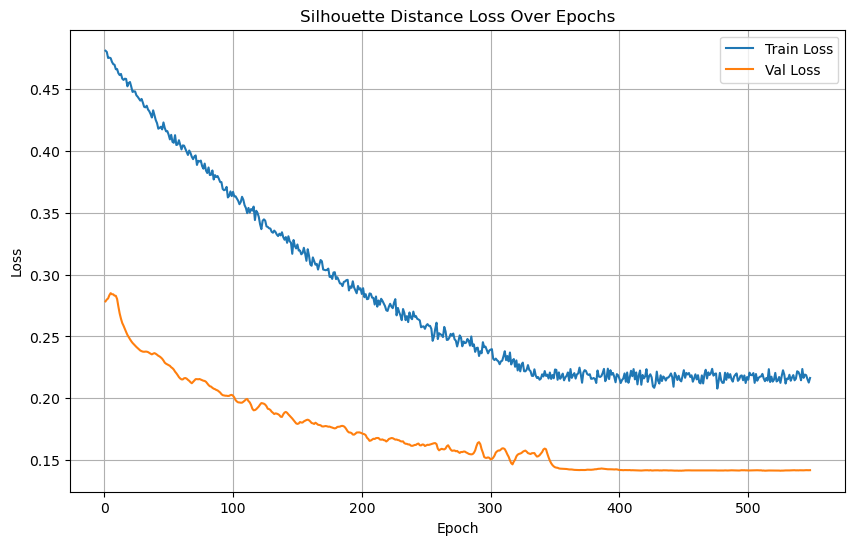

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/41], Loss: 0.1468
Test Batch [20/41], Loss: 0.1671
Test Batch [30/41], Loss: 0.5000
Test Batch [40/41], Loss: 0.0727

Test Loss: 0.2074


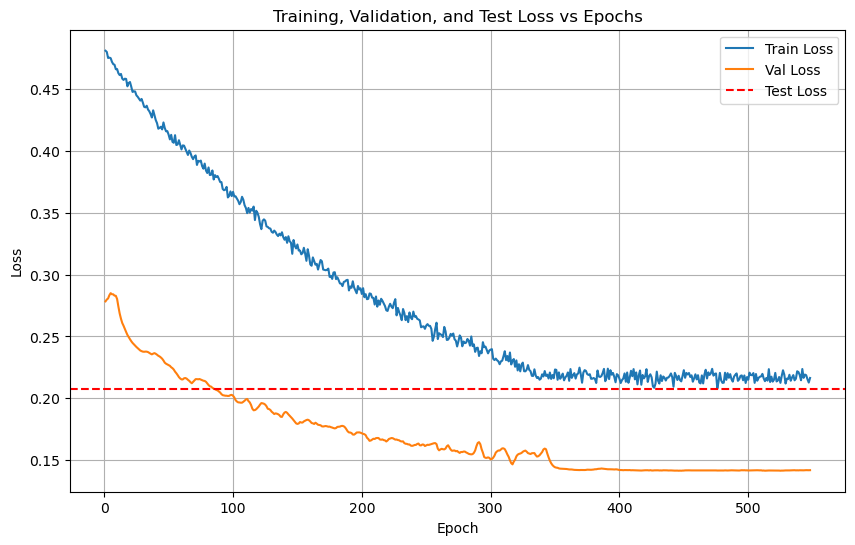

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/41 for test dataset.
  Processed batch 20/41 for test dataset.


  Processed batch 30/41 for test dataset.
  Processed batch 40/41 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       0.80      0.80      0.80         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       0.80      0.80      0.80         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6393  |  Val Loss: 2.6052
Validation loss improved from inf to 2.6052.
[Epoch 2/1000] Train Loss: 2.5466  |  Val Loss: 2.5201
Validation loss improved from 2.6052 to 2.5201.
[Epoch 3/1000] Train Loss: 2.4610  |  Val Loss: 2.4471
Validation loss improved from 2.5201 to 2.4471.
[Epoch 4/1000] Train Loss: 2.3824  |  Val Loss: 2.3743
Validation loss improved from 2.4471 to 2.3743.


[Epoch 5/1000] Train Loss: 2.3036  |  Val Loss: 2.3063
Validation loss improved from 2.3743 to 2.3063.
[Epoch 6/1000] Train Loss: 2.2367  |  Val Loss: 2.2452
Validation loss improved from 2.3063 to 2.2452.
[Epoch 7/1000] Train Loss: 2.1720  |  Val Loss: 2.1881
Validation loss improved from 2.2452 to 2.1881.


[Epoch 8/1000] Train Loss: 2.1129  |  Val Loss: 2.1344
Validation loss improved from 2.1881 to 2.1344.
[Epoch 9/1000] Train Loss: 2.0568  |  Val Loss: 2.0829
Validation loss improved from 2.1344 to 2.0829.
[Epoch 10/1000] Train Loss: 2.0011  |  Val Loss: 2.0340
Validation loss improved from 2.0829 to 2.0340.


[Epoch 11/1000] Train Loss: 1.9486  |  Val Loss: 1.9855
Validation loss improved from 2.0340 to 1.9855.
[Epoch 12/1000] Train Loss: 1.8952  |  Val Loss: 1.9387
Validation loss improved from 1.9855 to 1.9387.
[Epoch 13/1000] Train Loss: 1.8437  |  Val Loss: 1.8905
Validation loss improved from 1.9387 to 1.8905.
[Epoch 14/1000] Train Loss: 1.7904  |  Val Loss: 1.8419
Validation loss improved from 1.8905 to 1.8419.


[Epoch 15/1000] Train Loss: 1.7378  |  Val Loss: 1.7923
Validation loss improved from 1.8419 to 1.7923.
[Epoch 16/1000] Train Loss: 1.6838  |  Val Loss: 1.7423
Validation loss improved from 1.7923 to 1.7423.


[Epoch 17/1000] Train Loss: 1.6297  |  Val Loss: 1.6920
Validation loss improved from 1.7423 to 1.6920.
[Epoch 18/1000] Train Loss: 1.5760  |  Val Loss: 1.6418
Validation loss improved from 1.6920 to 1.6418.
[Epoch 19/1000] Train Loss: 1.5217  |  Val Loss: 1.5911
Validation loss improved from 1.6418 to 1.5911.


[Epoch 20/1000] Train Loss: 1.4682  |  Val Loss: 1.5407
Validation loss improved from 1.5911 to 1.5407.
[Epoch 21/1000] Train Loss: 1.4145  |  Val Loss: 1.4905
Validation loss improved from 1.5407 to 1.4905.
[Epoch 22/1000] Train Loss: 1.3604  |  Val Loss: 1.4403
Validation loss improved from 1.4905 to 1.4403.
[Epoch 23/1000] Train Loss: 1.3066  |  Val Loss: 1.3868
Validation loss improved from 1.4403 to 1.3868.
[Epoch 24/1000] Train Loss: 1.2519  |  Val Loss: 1.3333
Validation loss improved from 1.3868 to 1.3333.


[Epoch 25/1000] Train Loss: 1.1971  |  Val Loss: 1.2816
Validation loss improved from 1.3333 to 1.2816.
[Epoch 26/1000] Train Loss: 1.1422  |  Val Loss: 1.2279
Validation loss improved from 1.2816 to 1.2279.


[Epoch 27/1000] Train Loss: 1.0892  |  Val Loss: 1.1755
Validation loss improved from 1.2279 to 1.1755.
[Epoch 28/1000] Train Loss: 1.0363  |  Val Loss: 1.1249
Validation loss improved from 1.1755 to 1.1249.
[Epoch 29/1000] Train Loss: 0.9855  |  Val Loss: 1.0758
Validation loss improved from 1.1249 to 1.0758.


[Epoch 30/1000] Train Loss: 0.9362  |  Val Loss: 1.0272
Validation loss improved from 1.0758 to 1.0272.
[Epoch 31/1000] Train Loss: 0.8873  |  Val Loss: 0.9794
Validation loss improved from 1.0272 to 0.9794.
[Epoch 32/1000] Train Loss: 0.8405  |  Val Loss: 0.9323
Validation loss improved from 0.9794 to 0.9323.
[Epoch 33/1000] Train Loss: 0.7927  |  Val Loss: 0.8872
Validation loss improved from 0.9323 to 0.8872.
[Epoch 34/1000] Train Loss: 0.7466  |  Val Loss: 0.8426
Validation loss improved from 0.8872 to 0.8426.


[Epoch 35/1000] Train Loss: 0.7013  |  Val Loss: 0.7968
Validation loss improved from 0.8426 to 0.7968.
[Epoch 36/1000] Train Loss: 0.6567  |  Val Loss: 0.7540
Validation loss improved from 0.7968 to 0.7540.


[Epoch 37/1000] Train Loss: 0.6123  |  Val Loss: 0.7135
Validation loss improved from 0.7540 to 0.7135.
[Epoch 38/1000] Train Loss: 0.5706  |  Val Loss: 0.6739
Validation loss improved from 0.7135 to 0.6739.
[Epoch 39/1000] Train Loss: 0.5309  |  Val Loss: 0.6365
Validation loss improved from 0.6739 to 0.6365.


[Epoch 40/1000] Train Loss: 0.4942  |  Val Loss: 0.6014
Validation loss improved from 0.6365 to 0.6014.
[Epoch 41/1000] Train Loss: 0.4594  |  Val Loss: 0.5685
Validation loss improved from 0.6014 to 0.5685.
[Epoch 42/1000] Train Loss: 0.4267  |  Val Loss: 0.5393
Validation loss improved from 0.5685 to 0.5393.
[Epoch 43/1000] Train Loss: 0.3975  |  Val Loss: 0.5107
Validation loss improved from 0.5393 to 0.5107.
[Epoch 44/1000] Train Loss: 0.3695  |  Val Loss: 0.4852
Validation loss improved from 0.5107 to 0.4852.


[Epoch 45/1000] Train Loss: 0.3442  |  Val Loss: 0.4612
Validation loss improved from 0.4852 to 0.4612.
[Epoch 46/1000] Train Loss: 0.3211  |  Val Loss: 0.4389
Validation loss improved from 0.4612 to 0.4389.


[Epoch 47/1000] Train Loss: 0.2998  |  Val Loss: 0.4174
Validation loss improved from 0.4389 to 0.4174.
[Epoch 48/1000] Train Loss: 0.2812  |  Val Loss: 0.3989
Validation loss improved from 0.4174 to 0.3989.
[Epoch 49/1000] Train Loss: 0.2635  |  Val Loss: 0.3812
Validation loss improved from 0.3989 to 0.3812.


[Epoch 50/1000] Train Loss: 0.2478  |  Val Loss: 0.3661
Validation loss improved from 0.3812 to 0.3661.
[Epoch 51/1000] Train Loss: 0.2335  |  Val Loss: 0.3515
Validation loss improved from 0.3661 to 0.3515.
[Epoch 52/1000] Train Loss: 0.2206  |  Val Loss: 0.3382
Validation loss improved from 0.3515 to 0.3382.
[Epoch 53/1000] Train Loss: 0.2086  |  Val Loss: 0.3272
Validation loss improved from 0.3382 to 0.3272.
[Epoch 54/1000] Train Loss: 0.1980  |  Val Loss: 0.3164
Validation loss improved from 0.3272 to 0.3164.


[Epoch 55/1000] Train Loss: 0.1878  |  Val Loss: 0.3060
Validation loss improved from 0.3164 to 0.3060.
[Epoch 56/1000] Train Loss: 0.1786  |  Val Loss: 0.2960
Validation loss improved from 0.3060 to 0.2960.


[Epoch 57/1000] Train Loss: 0.1703  |  Val Loss: 0.2875
Validation loss improved from 0.2960 to 0.2875.
[Epoch 58/1000] Train Loss: 0.1626  |  Val Loss: 0.2787
Validation loss improved from 0.2875 to 0.2787.
[Epoch 59/1000] Train Loss: 0.1553  |  Val Loss: 0.2713
Validation loss improved from 0.2787 to 0.2713.
[Epoch 60/1000] Train Loss: 0.1486  |  Val Loss: 0.2633
Validation loss improved from 0.2713 to 0.2633.


[Epoch 61/1000] Train Loss: 0.1426  |  Val Loss: 0.2565
Validation loss improved from 0.2633 to 0.2565.
[Epoch 62/1000] Train Loss: 0.1365  |  Val Loss: 0.2500
Validation loss improved from 0.2565 to 0.2500.
[Epoch 63/1000] Train Loss: 0.1310  |  Val Loss: 0.2429
Validation loss improved from 0.2500 to 0.2429.
[Epoch 64/1000] Train Loss: 0.1259  |  Val Loss: 0.2371
Validation loss improved from 0.2429 to 0.2371.
[Epoch 65/1000] Train Loss: 0.1214  |  Val Loss: 0.2308
Validation loss improved from 0.2371 to 0.2308.


[Epoch 66/1000] Train Loss: 0.1168  |  Val Loss: 0.2260
Validation loss improved from 0.2308 to 0.2260.
[Epoch 67/1000] Train Loss: 0.1126  |  Val Loss: 0.2211
Validation loss improved from 0.2260 to 0.2211.
[Epoch 68/1000] Train Loss: 0.1087  |  Val Loss: 0.2167
Validation loss improved from 0.2211 to 0.2167.
[Epoch 69/1000] Train Loss: 0.1052  |  Val Loss: 0.2127
Validation loss improved from 0.2167 to 0.2127.
[Epoch 70/1000] Train Loss: 0.1017  |  Val Loss: 0.2089
Validation loss improved from 0.2127 to 0.2089.
[Epoch 71/1000] Train Loss: 0.0983  |  Val Loss: 0.2049
Validation loss improved from 0.2089 to 0.2049.


[Epoch 72/1000] Train Loss: 0.0952  |  Val Loss: 0.2019
Validation loss improved from 0.2049 to 0.2019.
[Epoch 73/1000] Train Loss: 0.0923  |  Val Loss: 0.1981
Validation loss improved from 0.2019 to 0.1981.
[Epoch 74/1000] Train Loss: 0.0896  |  Val Loss: 0.1949
Validation loss improved from 0.1981 to 0.1949.
[Epoch 75/1000] Train Loss: 0.0869  |  Val Loss: 0.1919
Validation loss improved from 0.1949 to 0.1919.


[Epoch 76/1000] Train Loss: 0.0844  |  Val Loss: 0.1892
Validation loss improved from 0.1919 to 0.1892.
[Epoch 77/1000] Train Loss: 0.0819  |  Val Loss: 0.1859
Validation loss improved from 0.1892 to 0.1859.
[Epoch 78/1000] Train Loss: 0.0797  |  Val Loss: 0.1825
Validation loss improved from 0.1859 to 0.1825.
[Epoch 79/1000] Train Loss: 0.0775  |  Val Loss: 0.1807
Validation loss improved from 0.1825 to 0.1807.
[Epoch 80/1000] Train Loss: 0.0753  |  Val Loss: 0.1781
Validation loss improved from 0.1807 to 0.1781.
[Epoch 81/1000] Train Loss: 0.0734  |  Val Loss: 0.1754
Validation loss improved from 0.1781 to 0.1754.


[Epoch 82/1000] Train Loss: 0.0715  |  Val Loss: 0.1732
Validation loss improved from 0.1754 to 0.1732.
[Epoch 83/1000] Train Loss: 0.0695  |  Val Loss: 0.1713
Validation loss improved from 0.1732 to 0.1713.
[Epoch 84/1000] Train Loss: 0.0679  |  Val Loss: 0.1689
Validation loss improved from 0.1713 to 0.1689.
[Epoch 85/1000] Train Loss: 0.0662  |  Val Loss: 0.1676
Validation loss improved from 0.1689 to 0.1676.


[Epoch 86/1000] Train Loss: 0.0645  |  Val Loss: 0.1648
Validation loss improved from 0.1676 to 0.1648.
[Epoch 87/1000] Train Loss: 0.0630  |  Val Loss: 0.1625
Validation loss improved from 0.1648 to 0.1625.
[Epoch 88/1000] Train Loss: 0.0614  |  Val Loss: 0.1616
Validation loss improved from 0.1625 to 0.1616.
[Epoch 89/1000] Train Loss: 0.0599  |  Val Loss: 0.1596
Validation loss improved from 0.1616 to 0.1596.
[Epoch 90/1000] Train Loss: 0.0584  |  Val Loss: 0.1579
Validation loss improved from 0.1596 to 0.1579.
[Epoch 91/1000] Train Loss: 0.0571  |  Val Loss: 0.1561
Validation loss improved from 0.1579 to 0.1561.


[Epoch 92/1000] Train Loss: 0.0558  |  Val Loss: 0.1550
Validation loss improved from 0.1561 to 0.1550.
[Epoch 93/1000] Train Loss: 0.0545  |  Val Loss: 0.1536
Validation loss improved from 0.1550 to 0.1536.
[Epoch 94/1000] Train Loss: 0.0533  |  Val Loss: 0.1522
Validation loss improved from 0.1536 to 0.1522.
[Epoch 95/1000] Train Loss: 0.0522  |  Val Loss: 0.1509
Validation loss improved from 0.1522 to 0.1509.


[Epoch 96/1000] Train Loss: 0.0512  |  Val Loss: 0.1501
Validation loss improved from 0.1509 to 0.1501.
[Epoch 97/1000] Train Loss: 0.0498  |  Val Loss: 0.1484
Validation loss improved from 0.1501 to 0.1484.
[Epoch 98/1000] Train Loss: 0.0488  |  Val Loss: 0.1469
Validation loss improved from 0.1484 to 0.1469.
[Epoch 99/1000] Train Loss: 0.0478  |  Val Loss: 0.1456
Validation loss improved from 0.1469 to 0.1456.
[Epoch 100/1000] Train Loss: 0.0468  |  Val Loss: 0.1445
Validation loss improved from 0.1456 to 0.1445.
[Epoch 101/1000] Train Loss: 0.0459  |  Val Loss: 0.1444
Validation loss improved from 0.1445 to 0.1444.
[Epoch 102/1000] Train Loss: 0.0450  |  Val Loss: 0.1431
Validation loss improved from 0.1444 to 0.1431.


[Epoch 103/1000] Train Loss: 0.0440  |  Val Loss: 0.1423
Validation loss improved from 0.1431 to 0.1423.
[Epoch 104/1000] Train Loss: 0.0431  |  Val Loss: 0.1408
Validation loss improved from 0.1423 to 0.1408.
[Epoch 105/1000] Train Loss: 0.0422  |  Val Loss: 0.1402
Validation loss improved from 0.1408 to 0.1402.


[Epoch 106/1000] Train Loss: 0.0415  |  Val Loss: 0.1391
Validation loss improved from 0.1402 to 0.1391.
[Epoch 107/1000] Train Loss: 0.0406  |  Val Loss: 0.1383
Validation loss improved from 0.1391 to 0.1383.
[Epoch 108/1000] Train Loss: 0.0398  |  Val Loss: 0.1377
Validation loss improved from 0.1383 to 0.1377.
[Epoch 109/1000] Train Loss: 0.0390  |  Val Loss: 0.1374
Validation loss improved from 0.1377 to 0.1374.
[Epoch 110/1000] Train Loss: 0.0382  |  Val Loss: 0.1366
Validation loss improved from 0.1374 to 0.1366.
[Epoch 111/1000] Train Loss: 0.0376  |  Val Loss: 0.1355
Validation loss improved from 0.1366 to 0.1355.
[Epoch 112/1000] Train Loss: 0.0369  |  Val Loss: 0.1351
Validation loss improved from 0.1355 to 0.1351.
[Epoch 113/1000] Train Loss: 0.0362  |  Val Loss: 0.1345
Validation loss improved from 0.1351 to 0.1345.


[Epoch 114/1000] Train Loss: 0.0356  |  Val Loss: 0.1336
Validation loss improved from 0.1345 to 0.1336.
[Epoch 115/1000] Train Loss: 0.0348  |  Val Loss: 0.1332
Validation loss improved from 0.1336 to 0.1332.


[Epoch 116/1000] Train Loss: 0.0342  |  Val Loss: 0.1325
Validation loss improved from 0.1332 to 0.1325.
[Epoch 117/1000] Train Loss: 0.0337  |  Val Loss: 0.1324
Validation loss improved from 0.1325 to 0.1324.
[Epoch 118/1000] Train Loss: 0.0331  |  Val Loss: 0.1313
Validation loss improved from 0.1324 to 0.1313.
[Epoch 119/1000] Train Loss: 0.0325  |  Val Loss: 0.1304
Validation loss improved from 0.1313 to 0.1304.
[Epoch 120/1000] Train Loss: 0.0319  |  Val Loss: 0.1303
Validation loss improved from 0.1304 to 0.1303.
[Epoch 121/1000] Train Loss: 0.0314  |  Val Loss: 0.1302
Validation loss improved from 0.1303 to 0.1302.
[Epoch 122/1000] Train Loss: 0.0307  |  Val Loss: 0.1294
Validation loss improved from 0.1302 to 0.1294.
[Epoch 123/1000] Train Loss: 0.0303  |  Val Loss: 0.1283
Validation loss improved from 0.1294 to 0.1283.


[Epoch 124/1000] Train Loss: 0.0298  |  Val Loss: 0.1282
Validation loss improved from 0.1283 to 0.1282.
[Epoch 125/1000] Train Loss: 0.0292  |  Val Loss: 0.1277
Validation loss improved from 0.1282 to 0.1277.


[Epoch 126/1000] Train Loss: 0.0288  |  Val Loss: 0.1275
Validation loss improved from 0.1277 to 0.1275.
[Epoch 127/1000] Train Loss: 0.0284  |  Val Loss: 0.1270
Validation loss improved from 0.1275 to 0.1270.
[Epoch 128/1000] Train Loss: 0.0278  |  Val Loss: 0.1269
Validation loss improved from 0.1270 to 0.1269.
[Epoch 129/1000] Train Loss: 0.0274  |  Val Loss: 0.1261
Validation loss improved from 0.1269 to 0.1261.
[Epoch 130/1000] Train Loss: 0.0269  |  Val Loss: 0.1260
Validation loss improved from 0.1261 to 0.1260.
[Epoch 131/1000] Train Loss: 0.0265  |  Val Loss: 0.1257
Validation loss improved from 0.1260 to 0.1257.
[Epoch 132/1000] Train Loss: 0.0261  |  Val Loss: 0.1255
Validation loss improved from 0.1257 to 0.1255.
[Epoch 133/1000] Train Loss: 0.0257  |  Val Loss: 0.1247
Validation loss improved from 0.1255 to 0.1247.


[Epoch 134/1000] Train Loss: 0.0253  |  Val Loss: 0.1251
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 0.0249  |  Val Loss: 0.1248
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 136/1000] Train Loss: 0.0246  |  Val Loss: 0.1253
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 137/1000] Train Loss: 0.0241  |  Val Loss: 0.1244
Validation loss improved from 0.1247 to 0.1244.
[Epoch 138/1000] Train Loss: 0.0237  |  Val Loss: 0.1241
Validation loss improved from 0.1244 to 0.1241.
[Epoch 139/1000] Train Loss: 0.0235  |  Val Loss: 0.1231
Validation loss improved from 0.1241 to 0.1231.
[Epoch 140/1000] Train Loss: 0.0231  |  Val Loss: 0.1229
Validation loss improved from 0.1231 to 0.1229.
[Epoch 141/1000] Train Loss: 0.0227  |  Val Loss: 0.1230
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 0.0224  |  Val Loss: 0.1227
Validation loss improved from 0.1229 to 0.1227.
[Epoch 143/1000] Train Loss: 0.0221  |  Val Loss: 0.1229
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 144/1000] Train Loss: 0.0218  |  Val Loss: 0.1226
Validation loss improved from 0.1227 to 0.1226.
[Epoch 145/1000] Train Loss: 0.0215  |  Val Loss: 0.1215
Validation loss improved from 0.1226 to 0.1215.


[Epoch 146/1000] Train Loss: 0.0211  |  Val Loss: 0.1221
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 0.0208  |  Val Loss: 0.1218
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 148/1000] Train Loss: 0.0205  |  Val Loss: 0.1211
Validation loss improved from 0.1215 to 0.1211.
[Epoch 149/1000] Train Loss: 0.0203  |  Val Loss: 0.1217
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 150/1000] Train Loss: 0.0199  |  Val Loss: 0.1212
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 151/1000] Train Loss: 0.0196  |  Val Loss: 0.1207
Validation loss improved from 0.1211 to 0.1207.
[Epoch 152/1000] Train Loss: 0.0193  |  Val Loss: 0.1202
Validation loss improved from 0.1207 to 0.1202.
[Epoch 153/1000] Train Loss: 0.0191  |  Val Loss: 0.1200
Validation loss improved from 0.1202 to 0.1200.
[Epoch 154/1000] Train Loss: 0.0188  |  Val Loss: 0.1207
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 155/1000] Train Loss: 0.0186  |  Val Loss: 0.1198
Validation loss improved from 0.1200 to 0.1198.
[Epoch 156/1000] Train Loss: 0.0183  |  Val Loss: 0.1200
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 0.0180  |  Val Loss: 0.1195
Validation loss improved from 0.1198 to 0.1195.
[Epoch 158/1000] Train Loss: 0.0178  |  Val Loss: 0.1200
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 159/1000] Train Loss: 0.0175  |  Val Loss: 0.1195
Validation loss improved from 0.1195 to 0.1195.
[Epoch 160/1000] Train Loss: 0.0173  |  Val Loss: 0.1194
Validation loss improved from 0.1195 to 0.1194.
[Epoch 161/1000] Train Loss: 0.0171  |  Val Loss: 0.1192
Validation loss improved from 0.1194 to 0.1192.
[Epoch 162/1000] Train Loss: 0.0169  |  Val Loss: 0.1189
Validation loss improved from 0.1192 to 0.1189.
[Epoch 163/1000] Train Loss: 0.0167  |  Val Loss: 0.1189
Validation loss improved from 0.1189 to 0.1189.
[Epoch 164/1000] Train Loss: 0.0164  |  Val

[Epoch 166/1000] Train Loss: 0.0160  |  Val Loss: 0.1192
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 0.0158  |  Val Loss: 0.1193
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 168/1000] Train Loss: 0.0156  |  Val Loss: 0.1185
Validation loss improved from 0.1189 to 0.1185.
[Epoch 169/1000] Train Loss: 0.0154  |  Val Loss: 0.1183
Validation loss improved from 0.1185 to 0.1183.
[Epoch 170/1000] Train Loss: 0.0153  |  Val Loss: 0.1177
Validation loss improved from 0.1183 to 0.1177.
[Epoch 171/1000] Train Loss: 0.0150  |  Val Loss: 0.1185
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 172/1000] Train Loss: 0.0148  |  Val Loss: 0.1188
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 173/1000] Train Loss: 0.0147  |  Val Loss: 0.1189
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 174/1000] Train Loss: 0.0145  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 175/1000] Tr

[Epoch 177/1000] Train Loss: 0.0140  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 178/1000] Train Loss: 0.0138  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 179/1000] Train Loss: 0.0137  |  Val Loss: 0.1180
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 180/1000] Train Loss: 0.0134  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 181/1000] Train Loss: 0.0133  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 182/1000] Train Loss: 0.0132  |  Val Loss: 0.1184
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 183/1000] Train Loss: 0.0130  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 184/1000] Train Loss: 0.0128  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 185/1000] Train Loss: 0.0127  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 15

[Epoch 187/1000] Train Loss: 0.0124  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 188/1000] Train Loss: 0.0123  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 189/1000] Train Loss: 0.0121  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 190/1000] Train Loss: 0.0120  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 191/1000] Train Loss: 0.0119  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 192/1000] Train Loss: 0.0117  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 193/1000] Train Loss: 0.0116  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 194/1000] Train Loss: 0.0116  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 195/1000] Train Loss: 0.0114  |  Val Loss: 0.1177
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.0111  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 198/1000] Train Loss: 0.0110  |  Val Loss: 0.1182
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 199/1000] Train Loss: 0.0108  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 200/1000] Train Loss: 0.0107  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 201/1000] Train Loss: 0.0106  |  Val Loss: 0.1179
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 202/1000] Train Loss: 0.0105  |  Val Loss: 0.1185
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 203/1000] Train Loss: 0.0104  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 204/1000] Train Loss: 0.0103  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 205/1000] Train Loss: 0.0102  |  Val Loss: 0.1185
!! Validation loss did NOT improve !! Patience:

[Epoch 207/1000] Train Loss: 0.0100  |  Val Loss: 0.1176
Validation loss improved from 0.1177 to 0.1176.
[Epoch 208/1000] Train Loss: 0.0099  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 0.0098  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 0.0097  |  Val Loss: 0.1177
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 0.0096  |  Val Loss: 0.1175
Validation loss improved from 0.1176 to 0.1175.
[Epoch 212/1000] Train Loss: 0.0095  |  Val Loss: 0.1179
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 0.0094  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 214/1000] Train Loss: 0.0093  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 215/1000] Train Loss: 0.0092  |  Val Loss: 0.1177
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 216/10

[Epoch 217/1000] Train Loss: 0.0090  |  Val Loss: 0.1174
Validation loss improved from 0.1175 to 0.1174.
[Epoch 218/1000] Train Loss: 0.0089  |  Val Loss: 0.1174
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 0.0088  |  Val Loss: 0.1174
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 220/1000] Train Loss: 0.0088  |  Val Loss: 0.1177
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 221/1000] Train Loss: 0.0087  |  Val Loss: 0.1176
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 222/1000] Train Loss: 0.0086  |  Val Loss: 0.1176
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 223/1000] Train Loss: 0.0085  |  Val Loss: 0.1173
Validation loss improved from 0.1174 to 0.1173.
[Epoch 224/1000] Train Loss: 0.0085  |  Val Loss: 0.1180
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.0083  |  Val Loss: 0.1177
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 226/10

[Epoch 227/1000] Train Loss: 0.0082  |  Val Loss: 0.1176
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 228/1000] Train Loss: 0.0081  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 229/1000] Train Loss: 0.0080  |  Val Loss: 0.1184
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 230/1000] Train Loss: 0.0080  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 231/1000] Train Loss: 0.0079  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 232/1000] Train Loss: 0.0078  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 233/1000] Train Loss: 0.0077  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 234/1000] Train Loss: 0.0077  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 235/1000] Train Loss: 0.0076  |  Val Loss: 0.1183
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 237/1000] Train Loss: 0.0074  |  Val Loss: 0.1182
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 238/1000] Train Loss: 0.0074  |  Val Loss: 0.1181
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 239/1000] Train Loss: 0.0073  |  Val Loss: 0.1185
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 240/1000] Train Loss: 0.0072  |  Val Loss: 0.1185
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 241/1000] Train Loss: 0.0072  |  Val Loss: 0.1185
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 242/1000] Train Loss: 0.0071  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 243/1000] Train Loss: 0.0071  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 244/1000] Train Loss: 0.0070  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 245/1000] Train Loss: 0.0069  |  Val Loss: 0.1188
!! Validation loss did NOT improve !! Patience:

[Epoch 247/1000] Train Loss: 0.0068  |  Val Loss: 0.1193
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 248/1000] Train Loss: 0.0068  |  Val Loss: 0.1188
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 249/1000] Train Loss: 0.0067  |  Val Loss: 0.1190
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 250/1000] Train Loss: 0.0066  |  Val Loss: 0.1195
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 251/1000] Train Loss: 0.0066  |  Val Loss: 0.1188
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 252/1000] Train Loss: 0.0065  |  Val Loss: 0.1186
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 253/1000] Train Loss: 0.0065  |  Val Loss: 0.1186
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 254/1000] Train Loss: 0.0064  |  Val Loss: 0.1184
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 255/1000] Train Loss: 0.0063  |  Val Loss: 0.1187
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.0062  |  Val Loss: 0.1188
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 258/1000] Train Loss: 0.0062  |  Val Loss: 0.1190
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 259/1000] Train Loss: 0.0061  |  Val Loss: 0.1192
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 260/1000] Train Loss: 0.0061  |  Val Loss: 0.1188
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 261/1000] Train Loss: 0.0060  |  Val Loss: 0.1191
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 262/1000] Train Loss: 0.0060  |  Val Loss: 0.1193
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 263/1000] Train Loss: 0.0059  |  Val Loss: 0.1193
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 264/1000] Train Loss: 0.0059  |  Val Loss: 0.1195
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 265/1000] Train Loss: 0.0058  |  Val Loss: 0.1192
!! Validation loss did NOT improve !! Patience:

[Epoch 267/1000] Train Loss: 0.0057  |  Val Loss: 0.1191
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 268/1000] Train Loss: 0.0057  |  Val Loss: 0.1191
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 269/1000] Train Loss: 0.0056  |  Val Loss: 0.1191
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 270/1000] Train Loss: 0.0056  |  Val Loss: 0.1198
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 271/1000] Train Loss: 0.0055  |  Val Loss: 0.1198
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 272/1000] Train Loss: 0.0055  |  Val Loss: 0.1201
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 273/1000] Train Loss: 0.0054  |  Val Loss: 0.1202
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 274/1000] Train Loss: 0.0054  |  Val Loss: 0.1201
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 275/1000] Train Loss: 0.0053  |  Val Loss: 0.1204
!! Validation loss did NOT improve !! Patience:

[Epoch 277/1000] Train Loss: 0.0053  |  Val Loss: 0.1204
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 278/1000] Train Loss: 0.0052  |  Val Loss: 0.1203
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 279/1000] Train Loss: 0.0052  |  Val Loss: 0.1204
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 280/1000] Train Loss: 0.0051  |  Val Loss: 0.1201
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 281/1000] Train Loss: 0.0051  |  Val Loss: 0.1201
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 282/1000] Train Loss: 0.0050  |  Val Loss: 0.1203
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 283/1000] Train Loss: 0.0050  |  Val Loss: 0.1205
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 284/1000] Train Loss: 0.0050  |  Val Loss: 0.1206
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 285/1000] Train Loss: 0.0049  |  Val Loss: 0.1208
!! Validation loss did NOT improve !! Patience:

[Epoch 286/1000] Train Loss: 0.0049  |  Val Loss: 0.1204
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 287/1000] Train Loss: 0.0048  |  Val Loss: 0.1206
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 288/1000] Train Loss: 0.0048  |  Val Loss: 0.1209
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 289/1000] Train Loss: 0.0048  |  Val Loss: 0.1206
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 290/1000] Train Loss: 0.0048  |  Val Loss: 0.1213
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 291/1000] Train Loss: 0.0047  |  Val Loss: 0.1208
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 292/1000] Train Loss: 0.0047  |  Val Loss: 0.1206
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 293/1000] Train Loss: 0.0046  |  Val Loss: 0.1209
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 294/1000] Train Loss: 0.0046  |  Val Loss: 0.1213
!! Validation loss did NOT improve !! Patience:

[Epoch 296/1000] Train Loss: 0.0045  |  Val Loss: 0.1213
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 297/1000] Train Loss: 0.0045  |  Val Loss: 0.1214
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 298/1000] Train Loss: 0.0045  |  Val Loss: 0.1217
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 299/1000] Train Loss: 0.0044  |  Val Loss: 0.1211
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 300/1000] Train Loss: 0.0044  |  Val Loss: 0.1220
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 301/1000] Train Loss: 0.0044  |  Val Loss: 0.1222
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 302/1000] Train Loss: 0.0043  |  Val Loss: 0.1224
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 303/1000] Train Loss: 0.0043  |  Val Loss: 0.1222
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 304/1000] Train Loss: 0.0042  |  Val Loss: 0.1224
!! Validation loss did NOT improve !! Patience:

[Epoch 305/1000] Train Loss: 0.0042  |  Val Loss: 0.1227
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 306/1000] Train Loss: 0.0042  |  Val Loss: 0.1226
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 307/1000] Train Loss: 0.0041  |  Val Loss: 0.1223
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 308/1000] Train Loss: 0.0041  |  Val Loss: 0.1224
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 309/1000] Train Loss: 0.0041  |  Val Loss: 0.1221
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 310/1000] Train Loss: 0.0041  |  Val Loss: 0.1221
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 311/1000] Train Loss: 0.0040  |  Val Loss: 0.1221
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 312/1000] Train Loss: 0.0040  |  Val Loss: 0.1224
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 313/1000] Train Loss: 0.0040  |  Val Loss: 0.1225
!! Validation loss did NOT improve !! Patience:

[Epoch 316/1000] Train Loss: 0.0039  |  Val Loss: 0.1225
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 317/1000] Train Loss: 0.0039  |  Val Loss: 0.1224
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 318/1000] Train Loss: 0.0038  |  Val Loss: 0.1234
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 319/1000] Train Loss: 0.0038  |  Val Loss: 0.1233
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 320/1000] Train Loss: 0.0038  |  Val Loss: 0.1229
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 321/1000] Train Loss: 0.0037  |  Val Loss: 0.1229
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 322/1000] Train Loss: 0.0037  |  Val Loss: 0.1223
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 323/1000] Train Loss: 0.0037  |  Val Loss: 0.1229
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 323 !!
No improvement for 100 epochs.


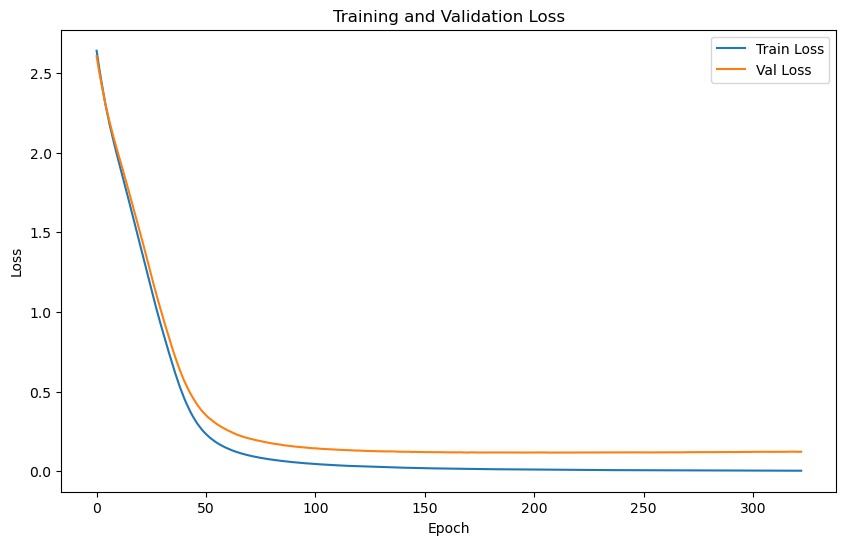

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2566 | Test Accuracy: 92.74%


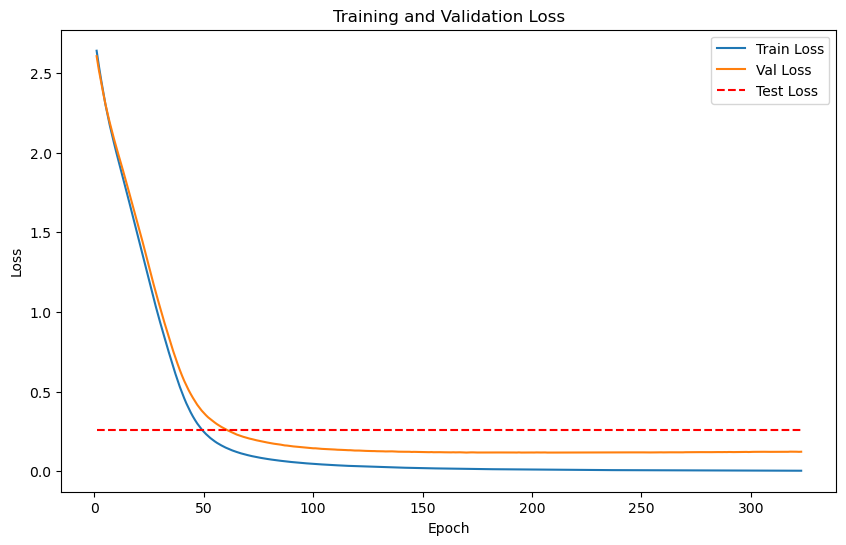

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


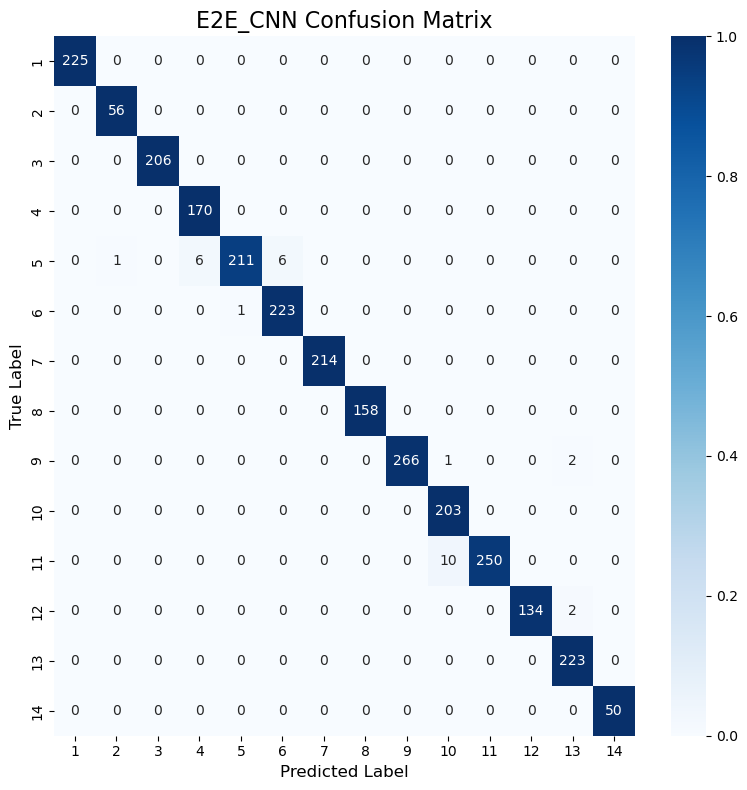

Classification Accuracy: 98.89%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


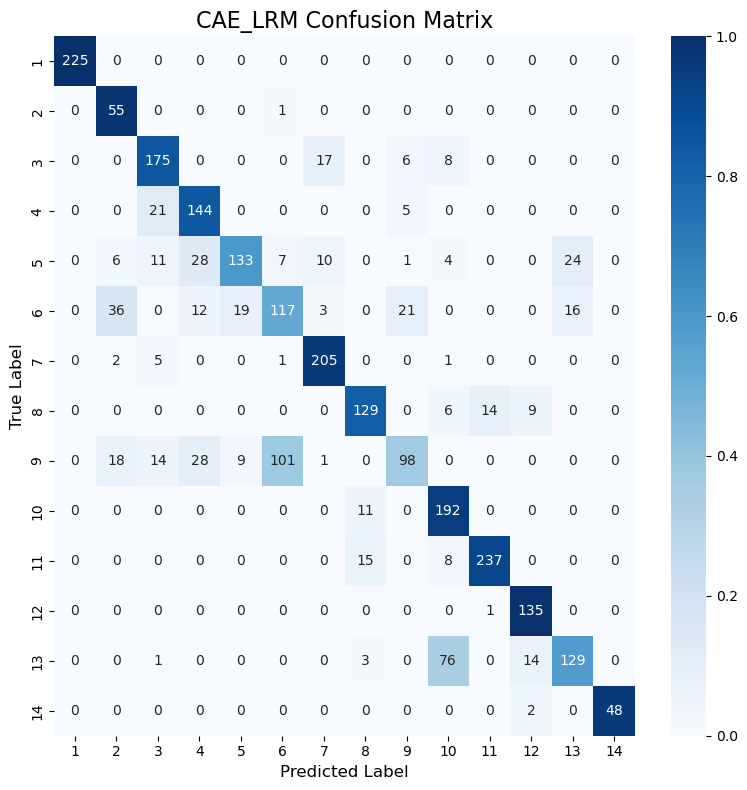

Classification Accuracy: 77.23%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


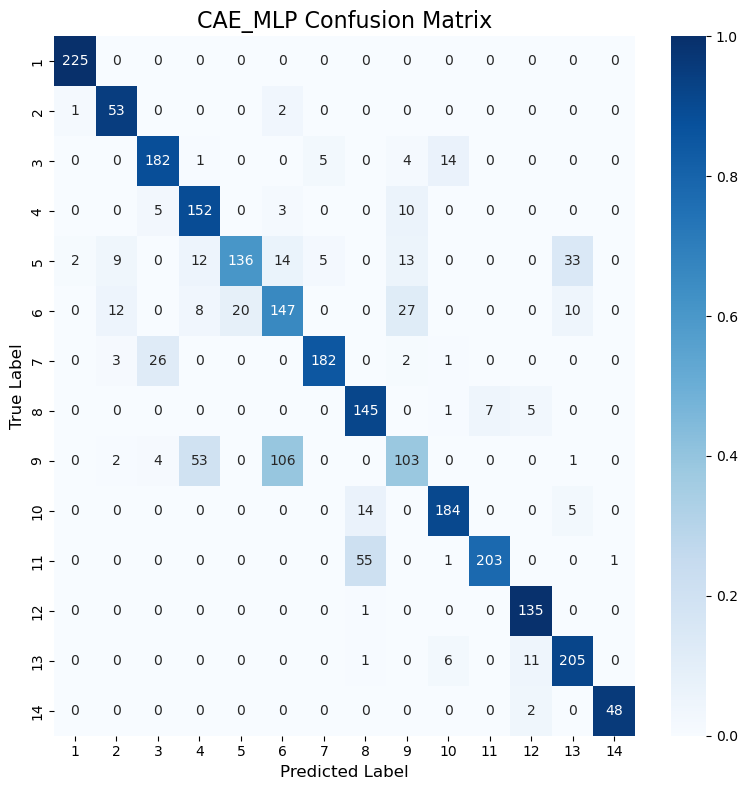

Classification Accuracy: 80.21%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


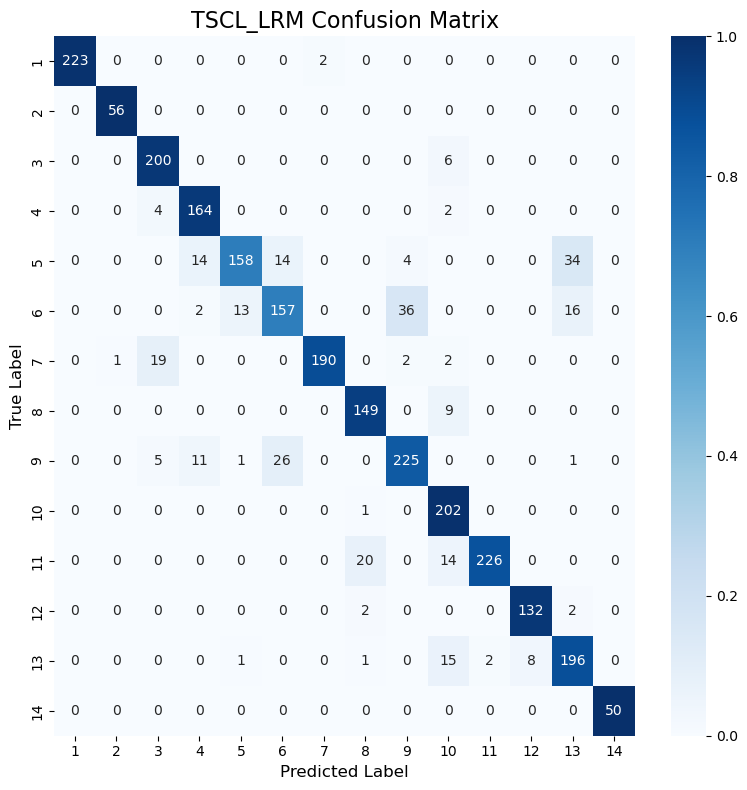

Classification Accuracy: 88.92%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


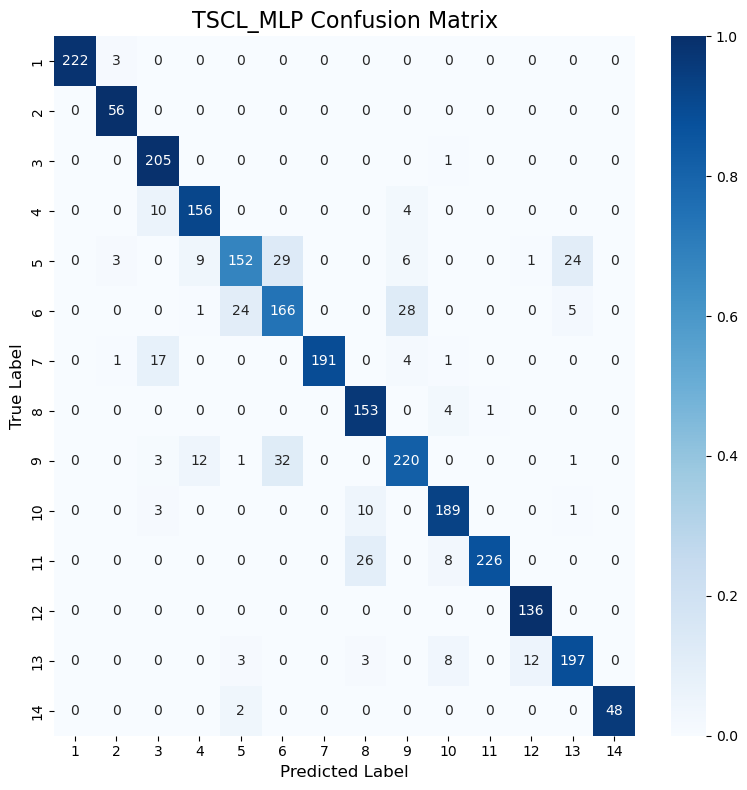

Classification Accuracy: 88.50%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


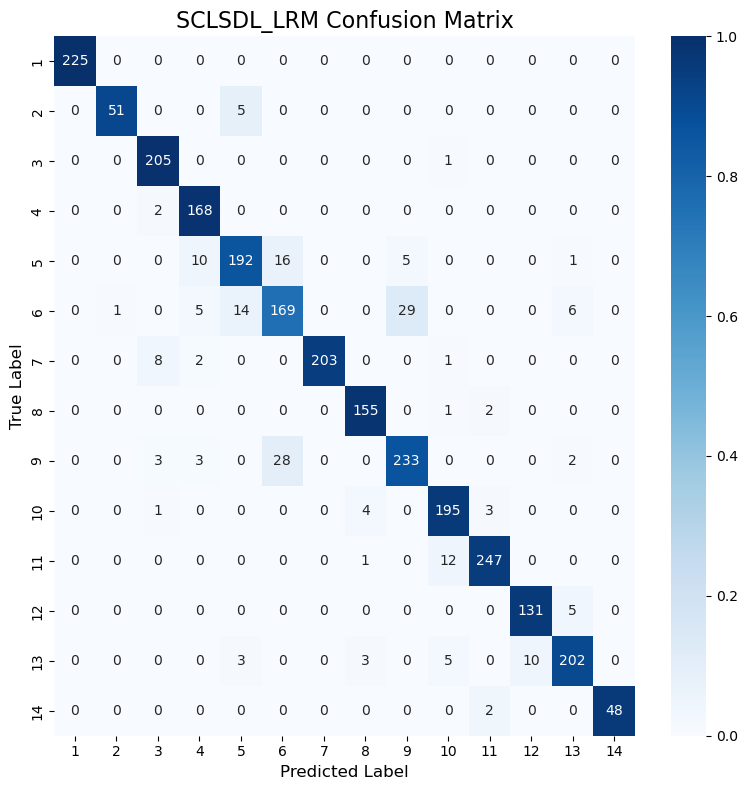

Classification Accuracy: 92.59%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


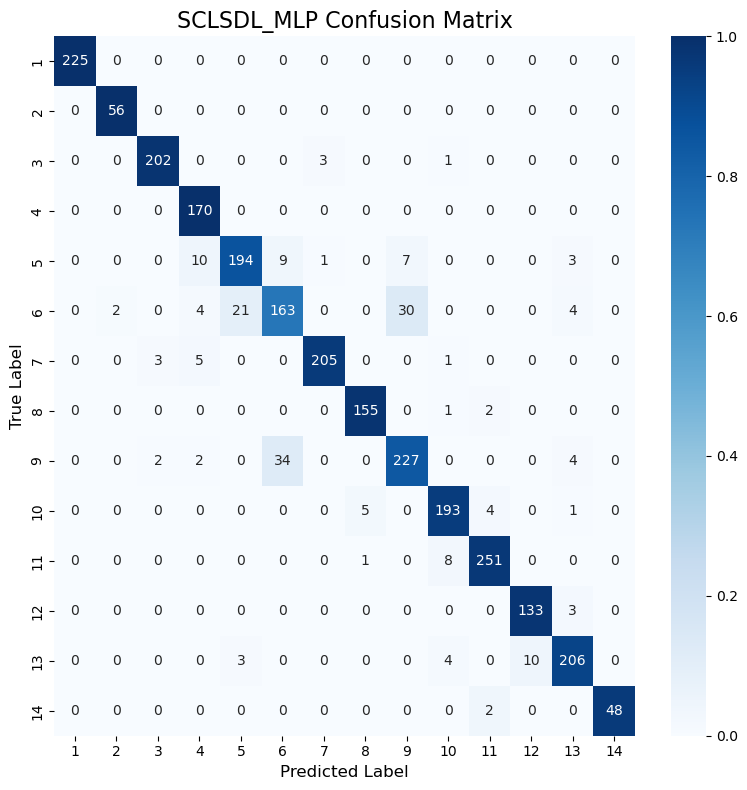

Classification Accuracy: 92.74%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.89
1    LRM (CAE)          77.23
2    MLP (CAE)          80.21
3     TSCL LRM          88.92
4     TSCL MLP          88.50
5  SCL_SDL LRM          92.59
6  SCL_SDL MLP          92.74

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.89
6  SCL_SDL MLP          92.74
5  SCL_SDL LRM          92.59
3     TSCL LRM          88.92
4     TSCL MLP          88.50
2    MLP (CAE)          80.21
1    LRM (CAE)          77.23
